In [2]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import astropy
from astropy.convolution import convolve, Box2DKernel, Gaussian2DKernel,Tophat2DKernel

import sys
sys.path.append('../..')
import snowFun

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)

In [4]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# load rgi names that have been saved to the classified folder
rgis_folder = list(set( [ i[3:17] for i in os.listdir(folder_class) if i!='merged.vrt' ] ))

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

# get rgi names for given o2 region
rgis_o2 = rgi_gdf[rgi_gdf['O2Region']=='4']['RGIId'].values

# select which rgis to analyze
if validation_only:
    rgis_to_analyze = list( set(rgis_folder).intersection(set(all_validation_df['RGIId'].values)) )
else:
    # rgis_to_analyze = ["RGI60-01.09162"] # just a single rgi
    rgis_to_analyze = rgis_folder # everything that is available
#     rgis_to_analyze = list( set(rgis_folder).intersection(set(rgis_o2)) ) # all the rgis in the folder than are in this o2region

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values


print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:40])

3031


In [6]:
skip = 0
for i in range(len(rgis_to_analyze)):
#     if i!=0: continue
    
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
#     if rgiid!='RGI60-01.09162': continue
    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area']
    
    # define path that this is going to be saved to
    path_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Slopes', f"S2_{rgiid}_slope.nc")
    
    # skip if it already exists
#     if os.path.exists(path_save):
#         continue
    
    # print progress
    print(f"Starting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga.values[0]} km2")
    
    # grab just this rgi geometry and info
    rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
    single_geometry = rgi_single.geometry

    # open the mask 
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    # open dem. just use 2013, because applying thinning rate leads to artifacts
    xr_dem = snowFun.get_year_DEM(single_geometry, 2013).squeeze('time')
    
    # slice edges to ensure same shape
    xr_dem = xr_dem.sel(x=slice( min(glacier_mask.x.values), max(glacier_mask.x.values) ), y=slice(max(glacier_mask.y.values),min(glacier_mask.y.values)))
    glacier_mask = glacier_mask.sel(x=slice( min(xr_dem.x.values), max(xr_dem.x.values) ), y=slice(max(xr_dem.y.values),min(xr_dem.y.values)))

    # set 0 to nan
    dem = xr_dem.values.astype(float)
    dem[dem==0]=np.nan
    
    # apply box smoothing
    kernel = Gaussian2DKernel(5)  #Tophat2DKernel(11) #Gaussian2DKernel(11) #Box2DKernel(11)
    dem_smooth = convolve(dem, kernel, boundary='fill', fill_value=np.nan)#, preserve_nan=True, nan_treatment='interpolate')
    
    # calculate surface slope here
    # Evaluate slope in x and y dimensions, combine, and then convert to degrees
    px, py = np.gradient(dem_smooth, 10)
    slope = np.sqrt(px ** 2 + py ** 2)
    slope = np.degrees(np.arctan(slope))
    
    # create mask to show where terrain is not too steep
#     max_slope = 25
#     slope_mask = (slope<=max_slope).astype('uint8')
    slope[dem==0]=np.nan
    
    # reset nan to 0
    slope[np.isnan(slope)]=0
    slope=slope.astype(int)
    
#     print(dem.shape)
#     print(glacier_mask.shape)
#     print(slope.shape)
    
    def format_xr_to_save(xr_da):
            xr_da.attrs["res"] = (10,10)
            xr_da.attrs["crs"] = "EPSG:3338"
            xr_da.attrs["transform"] = [10,0,0,0,-10,0]
#             xr_da.attrs["_FillValue"] = 0
            xr_da.attrs["long_name"] = rgiid
            xr_da.attrs["description"] = "surface slope, in degrees"
            xr_da.name = "slope"

            xr_da.x.attrs["units"] = "meters"
            xr_da.y.attrs["units"] = "meters"
            xr_da.x.attrs["long_name"] = 'x'
            xr_da.y.attrs["long_name"] = 'y'

            return xr_da
        
    # format everything correctly 
    xr_slope = glacier_mask.copy()
    xr_slope.values = slope
    
    slope = glacier_mask.where(glacier_mask==0, xr_slope)
    slope = format_xr_to_save(slope)#.astype('uint8')
    
    # specify compression/encoding
#     encoding = {"slope":{"dtype": 'uint8'}}#, "spatial_ref":{"zlib": False}}

    # save
    slope.to_netcdf(path_save,)# encoding=encoding)
#     slope_xr.to_netcdf(path_save, encoding=encoding)
        

Starting 1 of 3031: RGI60-01.20889  2.0 km2


Starting 2 of 3031: RGI60-01.11632  2.0 km2


Starting 3 of 3031: RGI60-01.08203  2.002 km2


Starting 4 of 3031: RGI60-01.25183  2.002 km2


Starting 5 of 3031: RGI60-01.11595  2.003 km2


Starting 6 of 3031: RGI60-01.03614  2.004 km2


Starting 7 of 3031: RGI60-01.05487  2.004 km2


Starting 8 of 3031: RGI60-01.09047  2.004 km2


Starting 9 of 3031: RGI60-01.03088  2.005 km2


Starting 10 of 3031: RGI60-01.17509  2.005 km2


Starting 11 of 3031: RGI60-01.10867  2.005 km2


Starting 12 of 3031: RGI60-01.12977  2.006 km2


Starting 13 of 3031: RGI60-01.08199  2.006 km2


Starting 14 of 3031: RGI60-01.02453  2.006 km2


Starting 15 of 3031: RGI60-01.19457  2.007 km2


Starting 16 of 3031: RGI60-01.05254  2.009 km2


Starting 17 of 3031: RGI60-01.02906  2.01 km2


Starting 18 of 3031: RGI60-01.03773  2.012 km2


Starting 19 of 3031: RGI60-01.19826  2.012 km2


Starting 20 of 3031: RGI60-01.00315  2.014 km2


Starting 21 of 3031: RGI60-01.00564  2.015 km2


Starting 22 of 3031: RGI60-01.02527  2.016 km2


Starting 23 of 3031: RGI60-01.08366  2.016 km2


Starting 24 of 3031: RGI60-01.23281  2.019 km2


Starting 25 of 3031: RGI60-01.02588  2.02 km2


Starting 26 of 3031: RGI60-01.05127  2.02 km2


Starting 27 of 3031: RGI60-01.22309  2.021 km2


Starting 28 of 3031: RGI60-01.12245  2.021 km2


Starting 29 of 3031: RGI60-01.10523  2.022 km2


Starting 30 of 3031: RGI60-01.19932  2.024 km2


Starting 31 of 3031: RGI60-01.21347  2.024 km2


Starting 32 of 3031: RGI60-01.09386  2.025 km2


Starting 33 of 3031: RGI60-01.23153  2.026 km2


Starting 34 of 3031: RGI60-01.21828  2.027 km2


Starting 35 of 3031: RGI60-01.20282  2.027 km2


Starting 36 of 3031: RGI60-01.06549  2.027 km2


Starting 37 of 3031: RGI60-01.17170  2.028 km2


Starting 38 of 3031: RGI60-01.07047  2.028 km2


Starting 39 of 3031: RGI60-01.07386  2.03 km2


Starting 40 of 3031: RGI60-01.00600  2.031 km2


Starting 41 of 3031: RGI60-01.05253  2.031 km2


Starting 42 of 3031: RGI60-01.11873  2.031 km2


Starting 43 of 3031: RGI60-01.02374  2.031 km2


Starting 44 of 3031: RGI60-01.05168  2.032 km2


Starting 45 of 3031: RGI60-01.01802  2.033 km2


Starting 46 of 3031: RGI60-01.02504  2.034 km2


Starting 47 of 3031: RGI60-01.16227  2.034 km2


Starting 48 of 3031: RGI60-01.00890  2.035 km2


Starting 49 of 3031: RGI60-01.11767  2.036 km2


Starting 50 of 3031: RGI60-01.03380  2.036 km2


Starting 51 of 3031: RGI60-01.19669  2.036 km2


Starting 52 of 3031: RGI60-01.19186  2.037 km2


Starting 53 of 3031: RGI60-01.09340  2.037 km2


Starting 54 of 3031: RGI60-01.11631  2.037 km2


Starting 55 of 3031: RGI60-01.23552  2.038 km2


Starting 56 of 3031: RGI60-01.13235  2.039 km2


Starting 57 of 3031: RGI60-01.20952  2.039 km2


Starting 58 of 3031: RGI60-01.20961  2.043 km2


Starting 59 of 3031: RGI60-01.19502  2.043 km2


Starting 60 of 3031: RGI60-01.20578  2.043 km2


Starting 61 of 3031: RGI60-01.18877  2.043 km2


Starting 62 of 3031: RGI60-01.19470  2.044 km2


Starting 63 of 3031: RGI60-01.15496  2.045 km2


Starting 64 of 3031: RGI60-01.05672  2.046 km2


Starting 65 of 3031: RGI60-01.07438  2.046 km2


Starting 66 of 3031: RGI60-01.23070  2.047 km2


Starting 67 of 3031: RGI60-01.03302  2.047 km2


Starting 68 of 3031: RGI60-01.16484  2.048 km2


Starting 69 of 3031: RGI60-01.00694  2.048 km2


Starting 70 of 3031: RGI60-01.19283  2.049 km2


Starting 71 of 3031: RGI60-01.00295  2.05 km2


Starting 72 of 3031: RGI60-01.21782  2.05 km2


Starting 73 of 3031: RGI60-01.15949  2.052 km2


Starting 74 of 3031: RGI60-01.03420  2.053 km2


Starting 75 of 3031: RGI60-01.25342  2.055 km2


Starting 76 of 3031: RGI60-01.19660  2.056 km2


Starting 77 of 3031: RGI60-01.16135  2.058 km2


Starting 78 of 3031: RGI60-01.14037  2.058 km2


Starting 79 of 3031: RGI60-01.15403  2.059 km2


Starting 80 of 3031: RGI60-01.14476  2.059 km2


Starting 81 of 3031: RGI60-01.23097  2.061 km2


Starting 82 of 3031: RGI60-01.07485  2.062 km2


Starting 83 of 3031: RGI60-01.23221  2.062 km2


Starting 84 of 3031: RGI60-01.06347  2.063 km2


Starting 85 of 3031: RGI60-01.02471  2.063 km2


Starting 86 of 3031: RGI60-01.09720  2.064 km2


Starting 87 of 3031: RGI60-01.04269  2.064 km2


Starting 88 of 3031: RGI60-01.09748  2.065 km2


Starting 89 of 3031: RGI60-01.12034  2.066 km2


Starting 90 of 3031: RGI60-01.23573  2.066 km2


Starting 91 of 3031: RGI60-01.22687  2.067 km2


Starting 92 of 3031: RGI60-01.19827  2.067 km2


Starting 93 of 3031: RGI60-01.26205  2.068 km2


Starting 94 of 3031: RGI60-01.07581  2.069 km2


Starting 95 of 3031: RGI60-01.06098  2.069 km2


Starting 96 of 3031: RGI60-01.22644  2.07 km2


Starting 97 of 3031: RGI60-01.18008  2.07 km2


Starting 98 of 3031: RGI60-01.18011  2.073 km2


Starting 99 of 3031: RGI60-01.19628  2.073 km2


Starting 100 of 3031: RGI60-01.02827  2.074 km2


Starting 101 of 3031: RGI60-01.00641  2.075 km2


Starting 102 of 3031: RGI60-01.23845  2.075 km2


Starting 103 of 3031: RGI60-01.23315  2.076 km2


Starting 104 of 3031: RGI60-01.09123  2.076 km2


Starting 105 of 3031: RGI60-01.25198  2.076 km2


Starting 106 of 3031: RGI60-01.22660  2.077 km2


Starting 107 of 3031: RGI60-01.13640  2.078 km2


Starting 108 of 3031: RGI60-01.13609  2.079 km2


Starting 109 of 3031: RGI60-01.05137  2.079 km2


Starting 110 of 3031: RGI60-01.22706  2.079 km2


Starting 111 of 3031: RGI60-01.20808  2.081 km2


Starting 112 of 3031: RGI60-01.25139  2.082 km2


Starting 113 of 3031: RGI60-01.08933  2.082 km2


Starting 114 of 3031: RGI60-01.16933  2.082 km2


Starting 115 of 3031: RGI60-01.03969  2.083 km2


Starting 116 of 3031: RGI60-01.10910  2.084 km2


Starting 117 of 3031: RGI60-01.09071  2.084 km2


Starting 118 of 3031: RGI60-01.10484  2.084 km2


Starting 119 of 3031: RGI60-01.06866  2.086 km2


Starting 120 of 3031: RGI60-01.15813  2.087 km2


Starting 121 of 3031: RGI60-01.07318  2.088 km2


Starting 122 of 3031: RGI60-01.17603  2.089 km2


Starting 123 of 3031: RGI60-01.16251  2.092 km2


Starting 124 of 3031: RGI60-01.10184  2.096 km2


Starting 125 of 3031: RGI60-01.20861  2.096 km2


Starting 126 of 3031: RGI60-01.12564  2.096 km2


Starting 127 of 3031: RGI60-01.21832  2.096 km2


Starting 128 of 3031: RGI60-01.00799  2.098 km2


Starting 129 of 3031: RGI60-01.16197  2.098 km2


Starting 130 of 3031: RGI60-01.00313  2.099 km2


Starting 131 of 3031: RGI60-01.05377  2.099 km2


Starting 132 of 3031: RGI60-01.00034  2.101 km2


Starting 133 of 3031: RGI60-01.08896  2.102 km2


Starting 134 of 3031: RGI60-01.17380  2.105 km2


Starting 135 of 3031: RGI60-01.16683  2.105 km2


Starting 136 of 3031: RGI60-01.16500  2.105 km2


Starting 137 of 3031: RGI60-01.19916  2.107 km2


Starting 138 of 3031: RGI60-01.19527  2.107 km2


Starting 139 of 3031: RGI60-01.19652  2.108 km2


Starting 140 of 3031: RGI60-01.07681  2.108 km2


Starting 141 of 3031: RGI60-01.09117  2.109 km2


Starting 142 of 3031: RGI60-01.06197  2.109 km2


Starting 143 of 3031: RGI60-01.15952  2.109 km2


Starting 144 of 3031: RGI60-01.08132  2.11 km2


Starting 145 of 3031: RGI60-01.05054  2.111 km2


Starting 146 of 3031: RGI60-01.01002  2.111 km2


Starting 147 of 3031: RGI60-01.03402  2.112 km2


Starting 148 of 3031: RGI60-01.00537  2.113 km2


Starting 149 of 3031: RGI60-01.22200  2.113 km2


Starting 150 of 3031: RGI60-01.14018  2.113 km2


Starting 151 of 3031: RGI60-01.20504  2.114 km2


Starting 152 of 3031: RGI60-01.03205  2.115 km2


Starting 153 of 3031: RGI60-01.22192  2.115 km2


Starting 154 of 3031: RGI60-01.11518  2.116 km2


Starting 155 of 3031: RGI60-01.24848  2.117 km2


Starting 156 of 3031: RGI60-01.17429  2.117 km2


Starting 157 of 3031: RGI60-01.08815  2.117 km2


Starting 158 of 3031: RGI60-01.23042  2.117 km2


Starting 159 of 3031: RGI60-01.14182  2.117 km2


Starting 160 of 3031: RGI60-01.18755  2.118 km2


Starting 161 of 3031: RGI60-01.05479  2.118 km2


Starting 162 of 3031: RGI60-01.05260  2.119 km2


Starting 163 of 3031: RGI60-01.00732  2.12 km2


Starting 164 of 3031: RGI60-01.08258  2.12 km2


Starting 165 of 3031: RGI60-01.02905  2.12 km2


Starting 166 of 3031: RGI60-01.03027  2.121 km2


Starting 167 of 3031: RGI60-01.16650  2.122 km2


Starting 168 of 3031: RGI60-01.19770  2.122 km2


Starting 169 of 3031: RGI60-01.18729  2.122 km2


Starting 170 of 3031: RGI60-01.07101  2.123 km2


Starting 171 of 3031: RGI60-01.18978  2.123 km2


Starting 172 of 3031: RGI60-01.00787  2.126 km2


Starting 173 of 3031: RGI60-01.12496  2.126 km2


Starting 174 of 3031: RGI60-01.19963  2.127 km2


Starting 175 of 3031: RGI60-01.15543  2.128 km2


Starting 176 of 3031: RGI60-01.17519  2.128 km2


Starting 177 of 3031: RGI60-01.00559  2.13 km2


Starting 178 of 3031: RGI60-01.02945  2.13 km2


Starting 179 of 3031: RGI60-01.13830  2.13 km2


Starting 180 of 3031: RGI60-01.00077  2.13 km2


Starting 181 of 3031: RGI60-01.03179  2.132 km2


Starting 182 of 3031: RGI60-01.20866  2.133 km2


Starting 183 of 3031: RGI60-01.10856  2.133 km2


Starting 184 of 3031: RGI60-01.00670  2.134 km2


Starting 185 of 3031: RGI60-01.05455  2.135 km2


Starting 186 of 3031: RGI60-01.09107  2.137 km2


Starting 187 of 3031: RGI60-01.01786  2.138 km2


Starting 188 of 3031: RGI60-01.06230  2.138 km2


Starting 189 of 3031: RGI60-01.01671  2.138 km2


Starting 190 of 3031: RGI60-01.24747  2.139 km2


Starting 191 of 3031: RGI60-01.22792  2.139 km2


Starting 192 of 3031: RGI60-01.23682  2.139 km2


Starting 193 of 3031: RGI60-01.07055  2.14 km2


Starting 194 of 3031: RGI60-01.23254  2.14 km2


Starting 195 of 3031: RGI60-01.04994  2.141 km2


Starting 196 of 3031: RGI60-01.23669  2.142 km2


Starting 197 of 3031: RGI60-01.18960  2.143 km2


Starting 198 of 3031: RGI60-01.13590  2.144 km2


Starting 199 of 3031: RGI60-01.21185  2.145 km2


Starting 200 of 3031: RGI60-01.04295  2.147 km2


Starting 201 of 3031: RGI60-01.20914  2.148 km2


Starting 202 of 3031: RGI60-01.13028  2.149 km2


Starting 203 of 3031: RGI60-01.03404  2.15 km2


Starting 204 of 3031: RGI60-01.08346  2.156 km2


Starting 205 of 3031: RGI60-01.00314  2.156 km2


Starting 206 of 3031: RGI60-01.10969  2.156 km2


Starting 207 of 3031: RGI60-01.03414  2.157 km2


Starting 208 of 3031: RGI60-01.17892  2.158 km2


Starting 209 of 3031: RGI60-01.24911  2.158 km2


Starting 210 of 3031: RGI60-01.11557  2.159 km2


Starting 211 of 3031: RGI60-01.00390  2.16 km2


Starting 212 of 3031: RGI60-01.00159  2.161 km2


Starting 213 of 3031: RGI60-01.25410  2.162 km2


Starting 214 of 3031: RGI60-01.21768  2.162 km2


Starting 215 of 3031: RGI60-01.11611  2.164 km2


Starting 216 of 3031: RGI60-01.04534  2.167 km2


Starting 217 of 3031: RGI60-01.24574  2.169 km2


Starting 218 of 3031: RGI60-01.15483  2.17 km2


Starting 219 of 3031: RGI60-01.20454  2.17 km2


Starting 220 of 3031: RGI60-01.15195  2.171 km2


Starting 221 of 3031: RGI60-01.24659  2.171 km2


Starting 222 of 3031: RGI60-01.05153  2.171 km2


Starting 223 of 3031: RGI60-01.11889  2.172 km2


Starting 224 of 3031: RGI60-01.18163  2.172 km2


Starting 225 of 3031: RGI60-01.23194  2.172 km2


Starting 226 of 3031: RGI60-01.15933  2.172 km2


Starting 227 of 3031: RGI60-01.03412  2.172 km2


Starting 228 of 3031: RGI60-01.23580  2.172 km2


Starting 229 of 3031: RGI60-01.20545  2.172 km2


Starting 230 of 3031: RGI60-01.00852  2.173 km2


Starting 231 of 3031: RGI60-01.19039  2.173 km2


Starting 232 of 3031: RGI60-01.14200  2.174 km2


Starting 233 of 3031: RGI60-01.03016  2.174 km2


Starting 234 of 3031: RGI60-01.15216  2.175 km2


Starting 235 of 3031: RGI60-01.22954  2.175 km2


Starting 236 of 3031: RGI60-01.16154  2.177 km2


Starting 237 of 3031: RGI60-01.25143  2.178 km2


Starting 238 of 3031: RGI60-01.03565  2.178 km2


Starting 239 of 3031: RGI60-01.00686  2.178 km2


Starting 240 of 3031: RGI60-01.20161  2.178 km2


Starting 241 of 3031: RGI60-01.10916  2.179 km2


Starting 242 of 3031: RGI60-01.18790  2.181 km2


Starting 243 of 3031: RGI60-01.12921  2.182 km2


Starting 244 of 3031: RGI60-01.03709  2.182 km2


Starting 245 of 3031: RGI60-01.20306  2.182 km2


Starting 246 of 3031: RGI60-01.02378  2.184 km2


Starting 247 of 3031: RGI60-01.04453  2.184 km2


Starting 248 of 3031: RGI60-01.12341  2.185 km2


Starting 249 of 3031: RGI60-01.12027  2.187 km2


Starting 250 of 3031: RGI60-01.01644  2.189 km2


Starting 251 of 3031: RGI60-01.23657  2.191 km2


Starting 252 of 3031: RGI60-01.03431  2.191 km2


Starting 253 of 3031: RGI60-01.26587  2.192 km2


Starting 254 of 3031: RGI60-01.07428  2.193 km2


Starting 255 of 3031: RGI60-01.23089  2.196 km2


Starting 256 of 3031: RGI60-01.20863  2.197 km2


Starting 257 of 3031: RGI60-01.02788  2.197 km2


Starting 258 of 3031: RGI60-01.06029  2.198 km2


Starting 259 of 3031: RGI60-01.04214  2.198 km2


Starting 260 of 3031: RGI60-01.14414  2.199 km2


Starting 261 of 3031: RGI60-01.20600  2.199 km2


Starting 262 of 3031: RGI60-01.17408  2.199 km2


Starting 263 of 3031: RGI60-01.08251  2.2 km2


Starting 264 of 3031: RGI60-01.06343  2.2 km2


Starting 265 of 3031: RGI60-01.26866  2.201 km2


Starting 266 of 3031: RGI60-01.07292  2.201 km2


Starting 267 of 3031: RGI60-01.11715  2.202 km2


Starting 268 of 3031: RGI60-01.04616  2.203 km2


Starting 269 of 3031: RGI60-01.23043  2.204 km2


Starting 270 of 3031: RGI60-01.23022  2.205 km2


Starting 271 of 3031: RGI60-01.20311  2.206 km2


Starting 272 of 3031: RGI60-01.24235  2.206 km2


Starting 273 of 3031: RGI60-01.13396  2.206 km2


Starting 274 of 3031: RGI60-01.03323  2.207 km2


Starting 275 of 3031: RGI60-01.16901  2.207 km2


Starting 276 of 3031: RGI60-01.12473  2.208 km2


Starting 277 of 3031: RGI60-01.06171  2.208 km2


Starting 278 of 3031: RGI60-01.05871  2.211 km2


Starting 279 of 3031: RGI60-01.04007  2.211 km2


Starting 280 of 3031: RGI60-01.01739  2.212 km2


Starting 281 of 3031: RGI60-01.17474  2.213 km2


Starting 282 of 3031: RGI60-01.23048  2.214 km2


Starting 283 of 3031: RGI60-01.11839  2.214 km2


Starting 284 of 3031: RGI60-01.23551  2.214 km2


Starting 285 of 3031: RGI60-01.16731  2.216 km2


Starting 286 of 3031: RGI60-01.01335  2.216 km2


Starting 287 of 3031: RGI60-01.19025  2.217 km2


Starting 288 of 3031: RGI60-01.02444  2.217 km2


Starting 289 of 3031: RGI60-01.04213  2.218 km2


Starting 290 of 3031: RGI60-01.03311  2.218 km2


Starting 291 of 3031: RGI60-01.05369  2.218 km2


Starting 292 of 3031: RGI60-01.05618  2.219 km2


Starting 293 of 3031: RGI60-01.21955  2.219 km2


Starting 294 of 3031: RGI60-01.08648  2.22 km2


Starting 295 of 3031: RGI60-01.10570  2.22 km2


Starting 296 of 3031: RGI60-01.16036  2.221 km2


Starting 297 of 3031: RGI60-01.03390  2.222 km2


Starting 298 of 3031: RGI60-01.23187  2.222 km2


Starting 299 of 3031: RGI60-01.05264  2.222 km2


Starting 300 of 3031: RGI60-01.03400  2.224 km2


Starting 301 of 3031: RGI60-01.19779  2.225 km2


Starting 302 of 3031: RGI60-01.19654  2.226 km2


Starting 303 of 3031: RGI60-01.19459  2.226 km2


Starting 304 of 3031: RGI60-01.09829  2.228 km2


Starting 305 of 3031: RGI60-01.25624  2.23 km2


Starting 306 of 3031: RGI60-01.24797  2.23 km2


Starting 307 of 3031: RGI60-01.03298  2.231 km2


Starting 308 of 3031: RGI60-01.14221  2.232 km2


Starting 309 of 3031: RGI60-01.01625  2.233 km2


Starting 310 of 3031: RGI60-01.04643  2.233 km2


Starting 311 of 3031: RGI60-01.17196  2.235 km2


Starting 312 of 3031: RGI60-01.04658  2.236 km2


Starting 313 of 3031: RGI60-01.04770  2.237 km2


Starting 314 of 3031: RGI60-01.03767  2.237 km2


Starting 315 of 3031: RGI60-01.11318  2.238 km2


Starting 316 of 3031: RGI60-01.04956  2.24 km2


Starting 317 of 3031: RGI60-01.12219  2.24 km2


Starting 318 of 3031: RGI60-01.16896  2.24 km2


Starting 319 of 3031: RGI60-01.20460  2.243 km2


Starting 320 of 3031: RGI60-01.03507  2.244 km2


Starting 321 of 3031: RGI60-01.23090  2.246 km2


Starting 322 of 3031: RGI60-01.03411  2.247 km2


Starting 323 of 3031: RGI60-01.02964  2.247 km2


Starting 324 of 3031: RGI60-01.12464  2.248 km2


Starting 325 of 3031: RGI60-01.17797  2.249 km2


Starting 326 of 3031: RGI60-01.04525  2.249 km2


Starting 327 of 3031: RGI60-01.22184  2.252 km2


Starting 328 of 3031: RGI60-01.08270  2.252 km2


Starting 329 of 3031: RGI60-01.14401  2.254 km2


Starting 330 of 3031: RGI60-01.24720  2.254 km2


Starting 331 of 3031: RGI60-01.23195  2.255 km2


Starting 332 of 3031: RGI60-01.07061  2.256 km2


Starting 333 of 3031: RGI60-01.23545  2.256 km2


Starting 334 of 3031: RGI60-01.20283  2.256 km2


Starting 335 of 3031: RGI60-01.18043  2.256 km2


Starting 336 of 3031: RGI60-01.23266  2.256 km2


Starting 337 of 3031: RGI60-01.07094  2.257 km2


Starting 338 of 3031: RGI60-01.06196  2.258 km2


Starting 339 of 3031: RGI60-01.20334  2.259 km2


Starting 340 of 3031: RGI60-01.22633  2.26 km2


Starting 341 of 3031: RGI60-01.05541  2.261 km2


Starting 342 of 3031: RGI60-01.03148  2.262 km2


Starting 343 of 3031: RGI60-01.17769  2.267 km2


Starting 344 of 3031: RGI60-01.03204  2.267 km2


Starting 345 of 3031: RGI60-01.05959  2.268 km2


Starting 346 of 3031: RGI60-01.17424  2.272 km2


Starting 347 of 3031: RGI60-01.08455  2.273 km2


Starting 348 of 3031: RGI60-01.05339  2.273 km2


Starting 349 of 3031: RGI60-01.05161  2.274 km2


Starting 350 of 3031: RGI60-01.13177  2.274 km2


Starting 351 of 3031: RGI60-01.01278  2.275 km2


Starting 352 of 3031: RGI60-01.21276  2.275 km2


Starting 353 of 3031: RGI60-01.20198  2.275 km2


Starting 354 of 3031: RGI60-01.07046  2.276 km2


Starting 355 of 3031: RGI60-01.15491  2.277 km2


Starting 356 of 3031: RGI60-01.04161  2.278 km2


Starting 357 of 3031: RGI60-01.03688  2.278 km2


Starting 358 of 3031: RGI60-01.20508  2.278 km2


Starting 359 of 3031: RGI60-01.19385  2.278 km2


Starting 360 of 3031: RGI60-01.15254  2.279 km2


Starting 361 of 3031: RGI60-01.05049  2.279 km2


Starting 362 of 3031: RGI60-01.13917  2.28 km2


Starting 363 of 3031: RGI60-01.16288  2.281 km2


Starting 364 of 3031: RGI60-01.16834  2.281 km2


Starting 365 of 3031: RGI60-01.08681  2.282 km2


Starting 366 of 3031: RGI60-01.08080  2.284 km2


Starting 367 of 3031: RGI60-01.01721  2.284 km2


Starting 368 of 3031: RGI60-01.01331  2.285 km2


Starting 369 of 3031: RGI60-01.19568  2.286 km2


Starting 370 of 3031: RGI60-01.20974  2.286 km2


Starting 371 of 3031: RGI60-01.08472  2.287 km2


Starting 372 of 3031: RGI60-01.03227  2.29 km2


Starting 373 of 3031: RGI60-01.23693  2.29 km2


Starting 374 of 3031: RGI60-01.19871  2.29 km2


Starting 375 of 3031: RGI60-01.24144  2.292 km2


Starting 376 of 3031: RGI60-01.23535  2.292 km2


Starting 377 of 3031: RGI60-01.21396  2.293 km2


Starting 378 of 3031: RGI60-01.05070  2.293 km2


Starting 379 of 3031: RGI60-01.16392  2.294 km2


Starting 380 of 3031: RGI60-01.20320  2.295 km2


Starting 381 of 3031: RGI60-01.15774  2.295 km2


Starting 382 of 3031: RGI60-01.19807  2.298 km2


Starting 383 of 3031: RGI60-01.11476  2.298 km2


Starting 384 of 3031: RGI60-01.01758  2.3 km2


Starting 385 of 3031: RGI60-01.24867  2.301 km2


Starting 386 of 3031: RGI60-01.12157  2.301 km2


Starting 387 of 3031: RGI60-01.20745  2.302 km2


Starting 388 of 3031: RGI60-01.03812  2.303 km2


Starting 389 of 3031: RGI60-01.22777  2.303 km2


Starting 390 of 3031: RGI60-01.18202  2.303 km2


Starting 391 of 3031: RGI60-01.05239  2.304 km2


Starting 392 of 3031: RGI60-01.05798  2.306 km2


Starting 393 of 3031: RGI60-01.19847  2.306 km2


Starting 394 of 3031: RGI60-01.16690  2.307 km2


Starting 395 of 3031: RGI60-01.19571  2.307 km2


Starting 396 of 3031: RGI60-01.01223  2.307 km2


Starting 397 of 3031: RGI60-01.22806  2.307 km2


Starting 398 of 3031: RGI60-01.06446  2.31 km2


Starting 399 of 3031: RGI60-01.05124  2.31 km2


Starting 400 of 3031: RGI60-01.02879  2.311 km2


Starting 401 of 3031: RGI60-01.05224  2.312 km2


Starting 402 of 3031: RGI60-01.23337  2.312 km2


Starting 403 of 3031: RGI60-01.16482  2.312 km2


Starting 404 of 3031: RGI60-01.03976  2.312 km2


Starting 405 of 3031: RGI60-01.02620  2.314 km2


Starting 406 of 3031: RGI60-01.02875  2.315 km2


Starting 407 of 3031: RGI60-01.04014  2.318 km2


Starting 408 of 3031: RGI60-01.16515  2.318 km2


Starting 409 of 3031: RGI60-01.09822  2.319 km2


Starting 410 of 3031: RGI60-01.25705  2.319 km2


Starting 411 of 3031: RGI60-01.05307  2.319 km2


Starting 412 of 3031: RGI60-01.19858  2.32 km2


Starting 413 of 3031: RGI60-01.09517  2.322 km2


Starting 414 of 3031: RGI60-01.23569  2.322 km2


Starting 415 of 3031: RGI60-01.22803  2.324 km2


Starting 416 of 3031: RGI60-01.13315  2.325 km2


Starting 417 of 3031: RGI60-01.13969  2.325 km2


Starting 418 of 3031: RGI60-01.15962  2.326 km2


Starting 419 of 3031: RGI60-01.01275  2.328 km2


Starting 420 of 3031: RGI60-01.02615  2.328 km2


Starting 421 of 3031: RGI60-01.23235  2.329 km2


Starting 422 of 3031: RGI60-01.19045  2.329 km2


Starting 423 of 3031: RGI60-01.11571  2.333 km2


Starting 424 of 3031: RGI60-01.21072  2.335 km2


Starting 425 of 3031: RGI60-01.19623  2.335 km2


Starting 426 of 3031: RGI60-01.18918  2.335 km2


Starting 427 of 3031: RGI60-01.15123  2.336 km2


Starting 428 of 3031: RGI60-01.20500  2.337 km2


Starting 429 of 3031: RGI60-01.20510  2.337 km2


Starting 430 of 3031: RGI60-01.16608  2.338 km2


Starting 431 of 3031: RGI60-01.23330  2.339 km2


Starting 432 of 3031: RGI60-01.08391  2.34 km2


Starting 433 of 3031: RGI60-01.15738  2.341 km2


Starting 434 of 3031: RGI60-01.02624  2.342 km2


Starting 435 of 3031: RGI60-01.09414  2.343 km2


Starting 436 of 3031: RGI60-01.04396  2.343 km2


Starting 437 of 3031: RGI60-01.02532  2.343 km2


Starting 438 of 3031: RGI60-01.06194  2.344 km2


Starting 439 of 3031: RGI60-01.08348  2.344 km2


Starting 440 of 3031: RGI60-01.23606  2.344 km2


Starting 441 of 3031: RGI60-01.22152  2.345 km2


Starting 442 of 3031: RGI60-01.11308  2.345 km2


Starting 443 of 3031: RGI60-01.22254  2.348 km2


Starting 444 of 3031: RGI60-01.16754  2.349 km2


Starting 445 of 3031: RGI60-01.03177  2.349 km2


Starting 446 of 3031: RGI60-01.08175  2.35 km2


Starting 447 of 3031: RGI60-01.13945  2.35 km2


Starting 448 of 3031: RGI60-01.19469  2.351 km2


Starting 449 of 3031: RGI60-01.04134  2.351 km2


Starting 450 of 3031: RGI60-01.12752  2.352 km2


Starting 451 of 3031: RGI60-01.11543  2.352 km2


Starting 452 of 3031: RGI60-01.24073  2.353 km2


Starting 453 of 3031: RGI60-01.18110  2.356 km2


Starting 454 of 3031: RGI60-01.13343  2.358 km2


Starting 455 of 3031: RGI60-01.04402  2.358 km2


Starting 456 of 3031: RGI60-01.10369  2.359 km2


Starting 457 of 3031: RGI60-01.22090  2.361 km2


Starting 458 of 3031: RGI60-01.23236  2.363 km2


Starting 459 of 3031: RGI60-01.10908  2.363 km2


Starting 460 of 3031: RGI60-01.14361  2.364 km2


Starting 461 of 3031: RGI60-01.20025  2.366 km2


Starting 462 of 3031: RGI60-01.17175  2.366 km2


Starting 463 of 3031: RGI60-01.05764  2.366 km2


Starting 464 of 3031: RGI60-01.02970  2.367 km2


Starting 465 of 3031: RGI60-01.09255  2.367 km2


Starting 466 of 3031: RGI60-01.06195  2.367 km2


Starting 467 of 3031: RGI60-01.07270  2.368 km2


Starting 468 of 3031: RGI60-01.11132  2.372 km2


Starting 469 of 3031: RGI60-01.03203  2.372 km2


Starting 470 of 3031: RGI60-01.00348  2.374 km2


Starting 471 of 3031: RGI60-01.15317  2.374 km2


Starting 472 of 3031: RGI60-01.24951  2.376 km2


Starting 473 of 3031: RGI60-01.26387  2.377 km2


Starting 474 of 3031: RGI60-01.17377  2.38 km2


Starting 475 of 3031: RGI60-01.26517  2.381 km2


Starting 476 of 3031: RGI60-01.08913  2.381 km2


Starting 477 of 3031: RGI60-01.24828  2.382 km2


Starting 478 of 3031: RGI60-01.03295  2.383 km2


Starting 479 of 3031: RGI60-01.19799  2.384 km2


Starting 480 of 3031: RGI60-01.17095  2.386 km2


Starting 481 of 3031: RGI60-01.19058  2.389 km2


Starting 482 of 3031: RGI60-01.16655  2.394 km2


Starting 483 of 3031: RGI60-01.21257  2.394 km2


Starting 484 of 3031: RGI60-01.07281  2.394 km2


Starting 485 of 3031: RGI60-01.01213  2.395 km2


Starting 486 of 3031: RGI60-01.03108  2.396 km2


Starting 487 of 3031: RGI60-01.19124  2.397 km2


Starting 488 of 3031: RGI60-01.05237  2.397 km2


Starting 489 of 3031: RGI60-01.04015  2.398 km2


Starting 490 of 3031: RGI60-01.24952  2.399 km2


Starting 491 of 3031: RGI60-01.04596  2.399 km2


Starting 492 of 3031: RGI60-01.03883  2.4 km2


Starting 493 of 3031: RGI60-01.14201  2.401 km2


Starting 494 of 3031: RGI60-01.17711  2.401 km2


Starting 495 of 3031: RGI60-01.22233  2.401 km2


Starting 496 of 3031: RGI60-01.16726  2.403 km2


Starting 497 of 3031: RGI60-01.24944  2.405 km2


Starting 498 of 3031: RGI60-01.18167  2.407 km2


Starting 499 of 3031: RGI60-01.06457  2.407 km2


Starting 500 of 3031: RGI60-01.19475  2.409 km2


Starting 501 of 3031: RGI60-01.22235  2.409 km2


Starting 502 of 3031: RGI60-01.17720  2.409 km2


Starting 503 of 3031: RGI60-01.14586  2.409 km2


Starting 504 of 3031: RGI60-01.20268  2.41 km2


Starting 505 of 3031: RGI60-01.04280  2.41 km2


Starting 506 of 3031: RGI60-01.25130  2.412 km2


Starting 507 of 3031: RGI60-01.23890  2.412 km2


Starting 508 of 3031: RGI60-01.23062  2.413 km2


Starting 509 of 3031: RGI60-01.14194  2.414 km2


Starting 510 of 3031: RGI60-01.04481  2.414 km2


Starting 511 of 3031: RGI60-01.01681  2.417 km2


Starting 512 of 3031: RGI60-01.19337  2.418 km2


Starting 513 of 3031: RGI60-01.02452  2.418 km2


Starting 514 of 3031: RGI60-01.19161  2.419 km2


Starting 515 of 3031: RGI60-01.18679  2.419 km2


Starting 516 of 3031: RGI60-01.11573  2.424 km2


Starting 517 of 3031: RGI60-01.13292  2.425 km2


Starting 518 of 3031: RGI60-01.14942  2.426 km2


Starting 519 of 3031: RGI60-01.09969  2.427 km2


Starting 520 of 3031: RGI60-01.16706  2.427 km2


Starting 521 of 3031: RGI60-01.22559  2.427 km2


Starting 522 of 3031: RGI60-01.11971  2.428 km2


Starting 523 of 3031: RGI60-01.19487  2.429 km2


Starting 524 of 3031: RGI60-01.08064  2.431 km2


Starting 525 of 3031: RGI60-01.03145  2.433 km2


Starting 526 of 3031: RGI60-01.18932  2.436 km2


Starting 527 of 3031: RGI60-01.19053  2.436 km2


Starting 528 of 3031: RGI60-01.20799  2.436 km2


Starting 529 of 3031: RGI60-01.11882  2.439 km2


Starting 530 of 3031: RGI60-01.06210  2.439 km2


Starting 531 of 3031: RGI60-01.15763  2.44 km2


Starting 532 of 3031: RGI60-01.12424  2.44 km2


Starting 533 of 3031: RGI60-01.25200  2.443 km2


Starting 534 of 3031: RGI60-01.01276  2.444 km2


Starting 535 of 3031: RGI60-01.06816  2.446 km2


Starting 536 of 3031: RGI60-01.19656  2.449 km2


Starting 537 of 3031: RGI60-01.12083  2.45 km2


Starting 538 of 3031: RGI60-01.09450  2.451 km2


Starting 539 of 3031: RGI60-01.05250  2.451 km2


Starting 540 of 3031: RGI60-01.03385  2.453 km2


Starting 541 of 3031: RGI60-01.19655  2.454 km2


Starting 542 of 3031: RGI60-01.26463  2.455 km2


Starting 543 of 3031: RGI60-01.08643  2.455 km2


Starting 544 of 3031: RGI60-01.08425  2.46 km2


Starting 545 of 3031: RGI60-01.03194  2.46 km2


Starting 546 of 3031: RGI60-01.10560  2.462 km2


Starting 547 of 3031: RGI60-01.05342  2.467 km2


Starting 548 of 3031: RGI60-01.01292  2.469 km2


Starting 549 of 3031: RGI60-01.12410  2.469 km2


Starting 550 of 3031: RGI60-01.17884  2.469 km2


Starting 551 of 3031: RGI60-01.18634  2.47 km2


Starting 552 of 3031: RGI60-01.22981  2.47 km2


Starting 553 of 3031: RGI60-01.05706  2.477 km2


Starting 554 of 3031: RGI60-01.18562  2.478 km2


Starting 555 of 3031: RGI60-01.18107  2.479 km2


Starting 556 of 3031: RGI60-01.16733  2.482 km2


Starting 557 of 3031: RGI60-01.26663  2.483 km2


Starting 558 of 3031: RGI60-01.23196  2.483 km2


Starting 559 of 3031: RGI60-01.12348  2.484 km2


Starting 560 of 3031: RGI60-01.22372  2.484 km2


Starting 561 of 3031: RGI60-01.16471  2.485 km2


Starting 562 of 3031: RGI60-01.12781  2.486 km2


Starting 563 of 3031: RGI60-01.03478  2.486 km2


Starting 564 of 3031: RGI60-01.02417  2.487 km2


Starting 565 of 3031: RGI60-01.23031  2.49 km2


Starting 566 of 3031: RGI60-01.05112  2.491 km2


Starting 567 of 3031: RGI60-01.01426  2.492 km2


Starting 568 of 3031: RGI60-01.04718  2.493 km2


Starting 569 of 3031: RGI60-01.18314  2.494 km2


Starting 570 of 3031: RGI60-01.01510  2.494 km2


Starting 571 of 3031: RGI60-01.15024  2.494 km2


Starting 572 of 3031: RGI60-01.08303  2.495 km2


Starting 573 of 3031: RGI60-01.24123  2.496 km2


Starting 574 of 3031: RGI60-01.01819  2.496 km2


Starting 575 of 3031: RGI60-01.19184  2.497 km2


Starting 576 of 3031: RGI60-01.16153  2.497 km2


Starting 577 of 3031: RGI60-01.12014  2.499 km2


Starting 578 of 3031: RGI60-01.09713  2.499 km2


Starting 579 of 3031: RGI60-01.01783  2.499 km2


Starting 580 of 3031: RGI60-01.23675  2.499 km2


Starting 581 of 3031: RGI60-01.07522  2.5 km2


Starting 582 of 3031: RGI60-01.00814  2.5 km2


Starting 583 of 3031: RGI60-01.20807  2.502 km2


Starting 584 of 3031: RGI60-01.04982  2.502 km2


Starting 585 of 3031: RGI60-01.17659  2.503 km2


Starting 586 of 3031: RGI60-01.00368  2.504 km2


Starting 587 of 3031: RGI60-01.16066  2.505 km2


Starting 588 of 3031: RGI60-01.05291  2.505 km2


Starting 589 of 3031: RGI60-01.11306  2.505 km2


Starting 590 of 3031: RGI60-01.11690  2.506 km2


Starting 591 of 3031: RGI60-01.23971  2.507 km2


Starting 592 of 3031: RGI60-01.26986  2.507 km2


Starting 593 of 3031: RGI60-01.20639  2.509 km2


Starting 594 of 3031: RGI60-01.08141  2.51 km2


Starting 595 of 3031: RGI60-01.13383  2.512 km2


Starting 596 of 3031: RGI60-01.03176  2.514 km2


Starting 597 of 3031: RGI60-01.02316  2.517 km2


Starting 598 of 3031: RGI60-01.16969  2.517 km2


Starting 599 of 3031: RGI60-01.05791  2.517 km2


Starting 600 of 3031: RGI60-01.03188  2.519 km2


Starting 601 of 3031: RGI60-01.19668  2.52 km2


Starting 602 of 3031: RGI60-01.02808  2.524 km2


Starting 603 of 3031: RGI60-01.18101  2.524 km2


Starting 604 of 3031: RGI60-01.24396  2.524 km2


Starting 605 of 3031: RGI60-01.06077  2.526 km2


Starting 606 of 3031: RGI60-01.11638  2.529 km2


Starting 607 of 3031: RGI60-01.16147  2.53 km2


Starting 608 of 3031: RGI60-01.19522  2.533 km2


Starting 609 of 3031: RGI60-01.04452  2.534 km2


Starting 610 of 3031: RGI60-01.11501  2.534 km2


Starting 611 of 3031: RGI60-01.18150  2.536 km2


Starting 612 of 3031: RGI60-01.03783  2.537 km2


Starting 613 of 3031: RGI60-01.11334  2.539 km2


Starting 614 of 3031: RGI60-01.15143  2.54 km2


Starting 615 of 3031: RGI60-01.11610  2.54 km2


Starting 616 of 3031: RGI60-01.16164  2.54 km2


Starting 617 of 3031: RGI60-01.14005  2.541 km2


Starting 618 of 3031: RGI60-01.04517  2.541 km2


Starting 619 of 3031: RGI60-01.03752  2.542 km2


Starting 620 of 3031: RGI60-01.15435  2.543 km2


Starting 621 of 3031: RGI60-01.10932  2.543 km2


Starting 622 of 3031: RGI60-01.22817  2.544 km2


Starting 623 of 3031: RGI60-01.09452  2.544 km2


Starting 624 of 3031: RGI60-01.19710  2.544 km2


Starting 625 of 3031: RGI60-01.06785  2.544 km2


Starting 626 of 3031: RGI60-01.20292  2.546 km2


Starting 627 of 3031: RGI60-01.03893  2.549 km2


Starting 628 of 3031: RGI60-01.26035  2.55 km2


Starting 629 of 3031: RGI60-01.26383  2.551 km2


Starting 630 of 3031: RGI60-01.15253  2.551 km2


Starting 631 of 3031: RGI60-01.05669  2.551 km2


Starting 632 of 3031: RGI60-01.03241  2.552 km2


Starting 633 of 3031: RGI60-01.23571  2.556 km2


Starting 634 of 3031: RGI60-01.10902  2.556 km2


Starting 635 of 3031: RGI60-01.20775  2.556 km2


Starting 636 of 3031: RGI60-01.10532  2.561 km2


Starting 637 of 3031: RGI60-01.07370  2.562 km2


Starting 638 of 3031: RGI60-01.19640  2.562 km2


Starting 639 of 3031: RGI60-01.04034  2.567 km2


Starting 640 of 3031: RGI60-01.22453  2.567 km2


Starting 641 of 3031: RGI60-01.16693  2.569 km2


Starting 642 of 3031: RGI60-01.05551  2.57 km2


Starting 643 of 3031: RGI60-01.05026  2.57 km2


Starting 644 of 3031: RGI60-01.26096  2.571 km2


Starting 645 of 3031: RGI60-01.17523  2.572 km2


Starting 646 of 3031: RGI60-01.00005  2.573 km2


Starting 647 of 3031: RGI60-01.19286  2.575 km2


Starting 648 of 3031: RGI60-01.03379  2.578 km2


Starting 649 of 3031: RGI60-01.03025  2.578 km2


Starting 650 of 3031: RGI60-01.03396  2.579 km2


Starting 651 of 3031: RGI60-01.05651  2.581 km2


Starting 652 of 3031: RGI60-01.04395  2.581 km2


Starting 653 of 3031: RGI60-01.16177  2.582 km2


Starting 654 of 3031: RGI60-01.03026  2.583 km2


Starting 655 of 3031: RGI60-01.10098  2.584 km2


Starting 656 of 3031: RGI60-01.08291  2.585 km2


Starting 657 of 3031: RGI60-01.19709  2.588 km2


Starting 658 of 3031: RGI60-01.18827  2.59 km2


Starting 659 of 3031: RGI60-01.04835  2.59 km2


Starting 660 of 3031: RGI60-01.01136  2.591 km2


Starting 661 of 3031: RGI60-01.09396  2.591 km2


Starting 662 of 3031: RGI60-01.04471  2.591 km2


Starting 663 of 3031: RGI60-01.20288  2.592 km2


Starting 664 of 3031: RGI60-01.20628  2.594 km2


Starting 665 of 3031: RGI60-01.09557  2.594 km2


Starting 666 of 3031: RGI60-01.08845  2.596 km2


Starting 667 of 3031: RGI60-01.20662  2.597 km2


Starting 668 of 3031: RGI60-01.09209  2.597 km2


Starting 669 of 3031: RGI60-01.01704  2.597 km2


Starting 670 of 3031: RGI60-01.00030  2.599 km2


Starting 671 of 3031: RGI60-01.04583  2.6 km2


Starting 672 of 3031: RGI60-01.10350  2.6 km2


Starting 673 of 3031: RGI60-01.23388  2.603 km2


Starting 674 of 3031: RGI60-01.05413  2.603 km2


Starting 675 of 3031: RGI60-01.12155  2.604 km2


Starting 676 of 3031: RGI60-01.00426  2.606 km2


Starting 677 of 3031: RGI60-01.22834  2.606 km2


Starting 678 of 3031: RGI60-01.02544  2.607 km2


Starting 679 of 3031: RGI60-01.11534  2.608 km2


Starting 680 of 3031: RGI60-01.19995  2.608 km2


Starting 681 of 3031: RGI60-01.08911  2.608 km2


Starting 682 of 3031: RGI60-01.15566  2.61 km2


Starting 683 of 3031: RGI60-01.05779  2.614 km2


Starting 684 of 3031: RGI60-01.04860  2.615 km2


Starting 685 of 3031: RGI60-01.18177  2.615 km2


Starting 686 of 3031: RGI60-01.04919  2.616 km2


Starting 687 of 3031: RGI60-01.04651  2.619 km2


Starting 688 of 3031: RGI60-01.06702  2.621 km2


Starting 689 of 3031: RGI60-01.04202  2.623 km2


Starting 690 of 3031: RGI60-01.14430  2.624 km2


Starting 691 of 3031: RGI60-01.01411  2.625 km2


Starting 692 of 3031: RGI60-01.17817  2.626 km2


Starting 693 of 3031: RGI60-01.17767  2.628 km2


Starting 694 of 3031: RGI60-01.00399  2.628 km2


Starting 695 of 3031: RGI60-01.14124  2.628 km2


Starting 696 of 3031: RGI60-01.00138  2.629 km2


Starting 697 of 3031: RGI60-01.01606  2.629 km2


Starting 698 of 3031: RGI60-01.26315  2.63 km2


Starting 699 of 3031: RGI60-01.08200  2.633 km2


Starting 700 of 3031: RGI60-01.13841  2.633 km2


Starting 701 of 3031: RGI60-01.08410  2.634 km2


Starting 702 of 3031: RGI60-01.08374  2.635 km2


Starting 703 of 3031: RGI60-01.03784  2.636 km2


Starting 704 of 3031: RGI60-01.04055  2.638 km2


Starting 705 of 3031: RGI60-01.03848  2.641 km2


Starting 706 of 3031: RGI60-01.06113  2.644 km2


Starting 707 of 3031: RGI60-01.10925  2.647 km2


Starting 708 of 3031: RGI60-01.20853  2.649 km2


Starting 709 of 3031: RGI60-01.01773  2.65 km2


Starting 710 of 3031: RGI60-01.00901  2.654 km2


Starting 711 of 3031: RGI60-01.08062  2.655 km2


Starting 712 of 3031: RGI60-01.17905  2.656 km2


Starting 713 of 3031: RGI60-01.08076  2.656 km2


Starting 714 of 3031: RGI60-01.23757  2.656 km2


Starting 715 of 3031: RGI60-01.03384  2.656 km2


Starting 716 of 3031: RGI60-01.12281  2.657 km2


Starting 717 of 3031: RGI60-01.01140  2.658 km2


Starting 718 of 3031: RGI60-01.20556  2.662 km2


Starting 719 of 3031: RGI60-01.01497  2.662 km2


Starting 720 of 3031: RGI60-01.00870  2.662 km2


Starting 721 of 3031: RGI60-01.13521  2.662 km2


Starting 722 of 3031: RGI60-01.18589  2.664 km2


Starting 723 of 3031: RGI60-01.08318  2.666 km2


Starting 724 of 3031: RGI60-01.19886  2.666 km2


Starting 725 of 3031: RGI60-01.10214  2.666 km2


Starting 726 of 3031: RGI60-01.09684  2.667 km2


Starting 727 of 3031: RGI60-01.22217  2.667 km2


Starting 728 of 3031: RGI60-01.10340  2.672 km2


Starting 729 of 3031: RGI60-01.19584  2.673 km2


Starting 730 of 3031: RGI60-01.07379  2.677 km2


Starting 731 of 3031: RGI60-01.00960  2.677 km2


Starting 732 of 3031: RGI60-01.16719  2.681 km2


Starting 733 of 3031: RGI60-01.14634  2.681 km2


Starting 734 of 3031: RGI60-01.00739  2.681 km2


Starting 735 of 3031: RGI60-01.20726  2.682 km2


Starting 736 of 3031: RGI60-01.08081  2.684 km2


Starting 737 of 3031: RGI60-01.04684  2.686 km2


Starting 738 of 3031: RGI60-01.03744  2.686 km2


Starting 739 of 3031: RGI60-01.05311  2.687 km2


Starting 740 of 3031: RGI60-01.22206  2.687 km2


Starting 741 of 3031: RGI60-01.15787  2.689 km2


Starting 742 of 3031: RGI60-01.17268  2.69 km2


Starting 743 of 3031: RGI60-01.23274  2.691 km2


Starting 744 of 3031: RGI60-01.12305  2.693 km2


Starting 745 of 3031: RGI60-01.03408  2.694 km2


Starting 746 of 3031: RGI60-01.01407  2.696 km2


Starting 747 of 3031: RGI60-01.03394  2.697 km2


Starting 748 of 3031: RGI60-01.12168  2.698 km2


Starting 749 of 3031: RGI60-01.22893  2.699 km2


Starting 750 of 3031: RGI60-01.06174  2.699 km2


Starting 751 of 3031: RGI60-01.03202  2.704 km2


Starting 752 of 3031: RGI60-01.01469  2.705 km2


Starting 753 of 3031: RGI60-01.13027  2.707 km2


Starting 754 of 3031: RGI60-01.03937  2.707 km2


Starting 755 of 3031: RGI60-01.26193  2.708 km2


Starting 756 of 3031: RGI60-01.15710  2.708 km2


Starting 757 of 3031: RGI60-01.19241  2.709 km2


Starting 758 of 3031: RGI60-01.11799  2.712 km2


Starting 759 of 3031: RGI60-01.03882  2.715 km2


Starting 760 of 3031: RGI60-01.01637  2.718 km2


Starting 761 of 3031: RGI60-01.12125  2.718 km2


Starting 762 of 3031: RGI60-01.02850  2.72 km2


Starting 763 of 3031: RGI60-01.10441  2.721 km2


Starting 764 of 3031: RGI60-01.13001  2.723 km2


Starting 765 of 3031: RGI60-01.05936  2.728 km2


Starting 766 of 3031: RGI60-01.03386  2.73 km2


Starting 767 of 3031: RGI60-01.03418  2.735 km2


Starting 768 of 3031: RGI60-01.18164  2.737 km2


Starting 769 of 3031: RGI60-01.11857  2.738 km2


Starting 770 of 3031: RGI60-01.15185  2.739 km2


Starting 771 of 3031: RGI60-01.09031  2.739 km2


Starting 772 of 3031: RGI60-01.14525  2.741 km2


Starting 773 of 3031: RGI60-01.14333  2.744 km2


Starting 774 of 3031: RGI60-01.07743  2.745 km2


Starting 775 of 3031: RGI60-01.24661  2.748 km2


Starting 776 of 3031: RGI60-01.04764  2.75 km2


Starting 777 of 3031: RGI60-01.10551  2.75 km2


Starting 778 of 3031: RGI60-01.13563  2.751 km2


Starting 779 of 3031: RGI60-01.19082  2.751 km2


Starting 780 of 3031: RGI60-01.02946  2.752 km2


Starting 781 of 3031: RGI60-01.04973  2.752 km2


Starting 782 of 3031: RGI60-01.09178  2.754 km2


Starting 783 of 3031: RGI60-01.00171  2.754 km2


Starting 784 of 3031: RGI60-01.14142  2.755 km2


Starting 785 of 3031: RGI60-01.15259  2.755 km2


Starting 786 of 3031: RGI60-01.01589  2.757 km2


Starting 787 of 3031: RGI60-01.10279  2.757 km2


Starting 788 of 3031: RGI60-01.17166  2.757 km2


Starting 789 of 3031: RGI60-01.05100  2.758 km2


Starting 790 of 3031: RGI60-01.26427  2.758 km2


Starting 791 of 3031: RGI60-01.27106  2.758 km2


Starting 792 of 3031: RGI60-01.07206  2.759 km2


Starting 793 of 3031: RGI60-01.19711  2.76 km2


Starting 794 of 3031: RGI60-01.00351  2.76 km2


Starting 795 of 3031: RGI60-01.19526  2.761 km2


Starting 796 of 3031: RGI60-01.12366  2.762 km2


Starting 797 of 3031: RGI60-01.08662  2.766 km2


Starting 798 of 3031: RGI60-01.02807  2.766 km2


Starting 799 of 3031: RGI60-01.25586  2.768 km2


Starting 800 of 3031: RGI60-01.16314  2.772 km2


Starting 801 of 3031: RGI60-01.12101  2.772 km2


Starting 802 of 3031: RGI60-01.20185  2.773 km2


Starting 803 of 3031: RGI60-01.04850  2.774 km2


Starting 804 of 3031: RGI60-01.01692  2.776 km2


Starting 805 of 3031: RGI60-01.17851  2.777 km2


Starting 806 of 3031: RGI60-01.08428  2.779 km2


Starting 807 of 3031: RGI60-01.20486  2.782 km2


Starting 808 of 3031: RGI60-01.01647  2.783 km2


Starting 809 of 3031: RGI60-01.23023  2.783 km2


Starting 810 of 3031: RGI60-01.00688  2.783 km2


Starting 811 of 3031: RGI60-01.18778  2.787 km2


Starting 812 of 3031: RGI60-01.19035  2.789 km2


Starting 813 of 3031: RGI60-01.19349  2.792 km2


Starting 814 of 3031: RGI60-01.18473  2.792 km2


Starting 815 of 3031: RGI60-01.09766  2.793 km2


Starting 816 of 3031: RGI60-01.22657  2.794 km2


Starting 817 of 3031: RGI60-01.19534  2.794 km2


Starting 818 of 3031: RGI60-01.11711  2.794 km2


Starting 819 of 3031: RGI60-01.10768  2.795 km2


Starting 820 of 3031: RGI60-01.08354  2.795 km2


Starting 821 of 3031: RGI60-01.16136  2.798 km2


Starting 822 of 3031: RGI60-01.11803  2.801 km2


Starting 823 of 3031: RGI60-01.00012  2.802 km2


Starting 824 of 3031: RGI60-01.05851  2.804 km2


Starting 825 of 3031: RGI60-01.14786  2.806 km2


Starting 826 of 3031: RGI60-01.16852  2.806 km2


Starting 827 of 3031: RGI60-01.23010  2.806 km2


Starting 828 of 3031: RGI60-01.02909  2.807 km2


Starting 829 of 3031: RGI60-01.02607  2.808 km2


Starting 830 of 3031: RGI60-01.02791  2.808 km2


Starting 831 of 3031: RGI60-01.23072  2.808 km2


Starting 832 of 3031: RGI60-01.04769  2.808 km2


Starting 833 of 3031: RGI60-01.01573  2.809 km2


Starting 834 of 3031: RGI60-01.03797  2.809 km2


Starting 835 of 3031: RGI60-01.18316  2.811 km2


Starting 836 of 3031: RGI60-01.04653  2.811 km2


Starting 837 of 3031: RGI60-01.03395  2.811 km2


Starting 838 of 3031: RGI60-01.19388  2.812 km2


Starting 839 of 3031: RGI60-01.19598  2.814 km2


Starting 840 of 3031: RGI60-01.16739  2.814 km2


Starting 841 of 3031: RGI60-01.19348  2.815 km2


Starting 842 of 3031: RGI60-01.05496  2.815 km2


Starting 843 of 3031: RGI60-01.20515  2.817 km2


Starting 844 of 3031: RGI60-01.05824  2.818 km2


Starting 845 of 3031: RGI60-01.04256  2.82 km2


Starting 846 of 3031: RGI60-01.03136  2.82 km2


Starting 847 of 3031: RGI60-01.05630  2.821 km2


Starting 848 of 3031: RGI60-01.08276  2.823 km2


Starting 849 of 3031: RGI60-01.26389  2.826 km2


Starting 850 of 3031: RGI60-01.04554  2.827 km2


Starting 851 of 3031: RGI60-01.06323  2.828 km2


Starting 852 of 3031: RGI60-01.24849  2.83 km2


Starting 853 of 3031: RGI60-01.15767  2.834 km2


Starting 854 of 3031: RGI60-01.16286  2.834 km2


Starting 855 of 3031: RGI60-01.01632  2.834 km2


Starting 856 of 3031: RGI60-01.23197  2.837 km2


Starting 857 of 3031: RGI60-01.12771  2.838 km2


Starting 858 of 3031: RGI60-01.10886  2.839 km2


Starting 859 of 3031: RGI60-01.22497  2.839 km2


Starting 860 of 3031: RGI60-01.16291  2.843 km2


Starting 861 of 3031: RGI60-01.08176  2.843 km2


Starting 862 of 3031: RGI60-01.19838  2.844 km2


Starting 863 of 3031: RGI60-01.07036  2.847 km2


Starting 864 of 3031: RGI60-01.15478  2.847 km2


Starting 865 of 3031: RGI60-01.08848  2.849 km2


Starting 866 of 3031: RGI60-01.08115  2.851 km2


Starting 867 of 3031: RGI60-01.06362  2.855 km2


Starting 868 of 3031: RGI60-01.22147  2.857 km2


Starting 869 of 3031: RGI60-01.14574  2.859 km2


Starting 870 of 3031: RGI60-01.10938  2.859 km2


Starting 871 of 3031: RGI60-01.19803  2.862 km2


Starting 872 of 3031: RGI60-01.20187  2.863 km2


Starting 873 of 3031: RGI60-01.16328  2.863 km2


Starting 874 of 3031: RGI60-01.14004  2.864 km2


Starting 875 of 3031: RGI60-01.03102  2.864 km2


Starting 876 of 3031: RGI60-01.26953  2.866 km2


Starting 877 of 3031: RGI60-01.07256  2.867 km2


Starting 878 of 3031: RGI60-01.22810  2.868 km2


Starting 879 of 3031: RGI60-01.20551  2.869 km2


Starting 880 of 3031: RGI60-01.16308  2.871 km2


Starting 881 of 3031: RGI60-01.04371  2.871 km2


Starting 882 of 3031: RGI60-01.03789  2.872 km2


Starting 883 of 3031: RGI60-01.14626  2.876 km2


Starting 884 of 3031: RGI60-01.14015  2.878 km2


Starting 885 of 3031: RGI60-01.17321  2.88 km2


Starting 886 of 3031: RGI60-01.23473  2.881 km2


Starting 887 of 3031: RGI60-01.17861  2.882 km2


Starting 888 of 3031: RGI60-01.09392  2.884 km2


Starting 889 of 3031: RGI60-01.20836  2.884 km2


Starting 890 of 3031: RGI60-01.09962  2.886 km2


Starting 891 of 3031: RGI60-01.17436  2.888 km2


Starting 892 of 3031: RGI60-01.06111  2.889 km2


Starting 893 of 3031: RGI60-01.22170  2.889 km2


Starting 894 of 3031: RGI60-01.09058  2.89 km2


Starting 895 of 3031: RGI60-01.20165  2.897 km2


Starting 896 of 3031: RGI60-01.08422  2.899 km2


Starting 897 of 3031: RGI60-01.05733  2.902 km2


Starting 898 of 3031: RGI60-01.19063  2.902 km2


Starting 899 of 3031: RGI60-01.12652  2.903 km2


Starting 900 of 3031: RGI60-01.22499  2.903 km2


Starting 901 of 3031: RGI60-01.21763  2.903 km2


Starting 902 of 3031: RGI60-01.10157  2.904 km2


Starting 903 of 3031: RGI60-01.15736  2.904 km2


Starting 904 of 3031: RGI60-01.00871  2.905 km2


Starting 905 of 3031: RGI60-01.05830  2.906 km2


Starting 906 of 3031: RGI60-01.08677  2.907 km2


Starting 907 of 3031: RGI60-01.15065  2.908 km2


Starting 908 of 3031: RGI60-01.26572  2.909 km2


Starting 909 of 3031: RGI60-01.19276  2.91 km2


Starting 910 of 3031: RGI60-01.23099  2.911 km2


Starting 911 of 3031: RGI60-01.07982  2.913 km2


Starting 912 of 3031: RGI60-01.20816  2.913 km2


Starting 913 of 3031: RGI60-01.06766  2.914 km2


Starting 914 of 3031: RGI60-01.11869  2.916 km2


Starting 915 of 3031: RGI60-01.22801  2.917 km2


Starting 916 of 3031: RGI60-01.16313  2.917 km2


Starting 917 of 3031: RGI60-01.19832  2.918 km2


Starting 918 of 3031: RGI60-01.17561  2.918 km2


Starting 919 of 3031: RGI60-01.01834  2.92 km2


Starting 920 of 3031: RGI60-01.12536  2.921 km2


Starting 921 of 3031: RGI60-01.06765  2.921 km2


Starting 922 of 3031: RGI60-01.25188  2.923 km2


Starting 923 of 3031: RGI60-01.11198  2.924 km2


Starting 924 of 3031: RGI60-01.08347  2.925 km2


Starting 925 of 3031: RGI60-01.09024  2.926 km2


Starting 926 of 3031: RGI60-01.22755  2.927 km2


Starting 927 of 3031: RGI60-01.12737  2.928 km2


Starting 928 of 3031: RGI60-01.13982  2.929 km2


Starting 929 of 3031: RGI60-01.05476  2.929 km2


Starting 930 of 3031: RGI60-01.03165  2.93 km2


Starting 931 of 3031: RGI60-01.13893  2.931 km2


Starting 932 of 3031: RGI60-01.03040  2.932 km2


Starting 933 of 3031: RGI60-01.00595  2.934 km2


Starting 934 of 3031: RGI60-01.12010  2.94 km2


Starting 935 of 3031: RGI60-01.03862  2.941 km2


Starting 936 of 3031: RGI60-01.16574  2.942 km2


Starting 937 of 3031: RGI60-01.02782  2.945 km2


Starting 938 of 3031: RGI60-01.14630  2.945 km2


Starting 939 of 3031: RGI60-01.04520  2.946 km2


Starting 940 of 3031: RGI60-01.16680  2.947 km2


Starting 941 of 3031: RGI60-01.19683  2.947 km2


Starting 942 of 3031: RGI60-01.14607  2.95 km2


Starting 943 of 3031: RGI60-01.05874  2.952 km2


Starting 944 of 3031: RGI60-01.20732  2.954 km2


Starting 945 of 3031: RGI60-01.09909  2.955 km2


Starting 946 of 3031: RGI60-01.07562  2.955 km2


Starting 947 of 3031: RGI60-01.18971  2.955 km2


Starting 948 of 3031: RGI60-01.01506  2.957 km2


Starting 949 of 3031: RGI60-01.10026  2.957 km2


Starting 950 of 3031: RGI60-01.03776  2.957 km2


Starting 951 of 3031: RGI60-01.02399  2.962 km2


Starting 952 of 3031: RGI60-01.00907  2.963 km2


Starting 953 of 3031: RGI60-01.21009  2.965 km2


Starting 954 of 3031: RGI60-01.05968  2.965 km2


Starting 955 of 3031: RGI60-01.12169  2.968 km2


Starting 956 of 3031: RGI60-01.03481  2.974 km2


Starting 957 of 3031: RGI60-01.03759  2.977 km2


Starting 958 of 3031: RGI60-01.09677  2.981 km2


Starting 959 of 3031: RGI60-01.01419  2.983 km2


Starting 960 of 3031: RGI60-01.09226  2.984 km2


Starting 961 of 3031: RGI60-01.10981  2.984 km2


Starting 962 of 3031: RGI60-01.14385  2.986 km2


Starting 963 of 3031: RGI60-01.05576  2.986 km2


Starting 964 of 3031: RGI60-01.03796  2.988 km2


Starting 965 of 3031: RGI60-01.13402  2.988 km2


Starting 966 of 3031: RGI60-01.20844  2.989 km2


Starting 967 of 3031: RGI60-01.04614  2.993 km2


Starting 968 of 3031: RGI60-01.05086  2.994 km2


Starting 969 of 3031: RGI60-01.12103  2.994 km2


Starting 970 of 3031: RGI60-01.22220  2.994 km2


Starting 971 of 3031: RGI60-01.22824  2.996 km2


Starting 972 of 3031: RGI60-01.05057  2.997 km2


Starting 973 of 3031: RGI60-01.19162  2.997 km2


Starting 974 of 3031: RGI60-01.16115  2.999 km2


Starting 975 of 3031: RGI60-01.14240  3.001 km2


Starting 976 of 3031: RGI60-01.01395  3.002 km2


Starting 977 of 3031: RGI60-01.05421  3.003 km2


Starting 978 of 3031: RGI60-01.13765  3.004 km2


Starting 979 of 3031: RGI60-01.19760  3.009 km2


Starting 980 of 3031: RGI60-01.11653  3.012 km2


Starting 981 of 3031: RGI60-01.20090  3.013 km2


Starting 982 of 3031: RGI60-01.05262  3.015 km2


Starting 983 of 3031: RGI60-01.19557  3.016 km2


Starting 984 of 3031: RGI60-01.11981  3.017 km2


Starting 985 of 3031: RGI60-01.20818  3.019 km2


Starting 986 of 3031: RGI60-01.07465  3.022 km2


Starting 987 of 3031: RGI60-01.09709  3.023 km2


Starting 988 of 3031: RGI60-01.07555  3.026 km2


Starting 989 of 3031: RGI60-01.10222  3.029 km2


Starting 990 of 3031: RGI60-01.18238  3.033 km2


Starting 991 of 3031: RGI60-01.14079  3.033 km2


Starting 992 of 3031: RGI60-01.03765  3.035 km2


Starting 993 of 3031: RGI60-01.25568  3.035 km2


Starting 994 of 3031: RGI60-01.11848  3.037 km2


Starting 995 of 3031: RGI60-01.19528  3.039 km2


Starting 996 of 3031: RGI60-01.03769  3.04 km2


Starting 997 of 3031: RGI60-01.20958  3.04 km2


Starting 998 of 3031: RGI60-01.02901  3.041 km2


Starting 999 of 3031: RGI60-01.16514  3.041 km2


Starting 1000 of 3031: RGI60-01.09616  3.042 km2


Starting 1001 of 3031: RGI60-01.22678  3.045 km2


Starting 1002 of 3031: RGI60-01.21792  3.046 km2


Starting 1003 of 3031: RGI60-01.08295  3.048 km2


Starting 1004 of 3031: RGI60-01.23555  3.053 km2


Starting 1005 of 3031: RGI60-01.09421  3.054 km2


Starting 1006 of 3031: RGI60-01.19462  3.056 km2


Starting 1007 of 3031: RGI60-01.05097  3.059 km2


Starting 1008 of 3031: RGI60-01.05970  3.061 km2


Starting 1009 of 3031: RGI60-01.08323  3.062 km2


Starting 1010 of 3031: RGI60-01.23053  3.063 km2


Starting 1011 of 3031: RGI60-01.05142  3.065 km2


Starting 1012 of 3031: RGI60-01.02605  3.066 km2


Starting 1013 of 3031: RGI60-01.07360  3.069 km2


Starting 1014 of 3031: RGI60-01.00660  3.07 km2


Starting 1015 of 3031: RGI60-01.20753  3.072 km2


Starting 1016 of 3031: RGI60-01.08400  3.073 km2


Starting 1017 of 3031: RGI60-01.14129  3.074 km2


Starting 1018 of 3031: RGI60-01.07545  3.078 km2


Starting 1019 of 3031: RGI60-01.15703  3.087 km2


Starting 1020 of 3031: RGI60-01.05656  3.092 km2


Starting 1021 of 3031: RGI60-01.20606  3.094 km2


Starting 1022 of 3031: RGI60-01.19791  3.094 km2


Starting 1023 of 3031: RGI60-01.14491  3.094 km2


Starting 1024 of 3031: RGI60-01.09199  3.095 km2


Starting 1025 of 3031: RGI60-01.20965  3.097 km2


Starting 1026 of 3031: RGI60-01.16371  3.097 km2


Starting 1027 of 3031: RGI60-01.00019  3.102 km2


Starting 1028 of 3031: RGI60-01.12145  3.102 km2


Starting 1029 of 3031: RGI60-01.00165  3.104 km2


Starting 1030 of 3031: RGI60-01.08435  3.104 km2


Starting 1031 of 3031: RGI60-01.09674  3.109 km2


Starting 1032 of 3031: RGI60-01.21809  3.115 km2


Starting 1033 of 3031: RGI60-01.10079  3.117 km2


Starting 1034 of 3031: RGI60-01.23730  3.118 km2


Starting 1035 of 3031: RGI60-01.04370  3.118 km2


Starting 1036 of 3031: RGI60-01.03399  3.12 km2


Starting 1037 of 3031: RGI60-01.01050  3.121 km2


Starting 1038 of 3031: RGI60-01.12736  3.122 km2


Starting 1039 of 3031: RGI60-01.16841  3.124 km2


Starting 1040 of 3031: RGI60-01.02843  3.127 km2


Starting 1041 of 3031: RGI60-01.00903  3.127 km2


Starting 1042 of 3031: RGI60-01.11794  3.13 km2


Starting 1043 of 3031: RGI60-01.00865  3.13 km2


Starting 1044 of 3031: RGI60-01.08150  3.132 km2


Starting 1045 of 3031: RGI60-01.01747  3.133 km2


Starting 1046 of 3031: RGI60-01.02616  3.134 km2


Starting 1047 of 3031: RGI60-01.19449  3.136 km2


Starting 1048 of 3031: RGI60-01.22926  3.138 km2


Starting 1049 of 3031: RGI60-01.13074  3.139 km2


Starting 1050 of 3031: RGI60-01.06753  3.14 km2


Starting 1051 of 3031: RGI60-01.22491  3.148 km2


Starting 1052 of 3031: RGI60-01.14552  3.151 km2


Starting 1053 of 3031: RGI60-01.20192  3.151 km2


Starting 1054 of 3031: RGI60-01.11561  3.158 km2


Starting 1055 of 3031: RGI60-01.18135  3.158 km2


Starting 1056 of 3031: RGI60-01.08113  3.159 km2


Starting 1057 of 3031: RGI60-01.22052  3.16 km2


Starting 1058 of 3031: RGI60-01.14165  3.163 km2


Starting 1059 of 3031: RGI60-01.20316  3.164 km2


Starting 1060 of 3031: RGI60-01.19021  3.169 km2


Starting 1061 of 3031: RGI60-01.22930  3.17 km2


Starting 1062 of 3031: RGI60-01.16327  3.171 km2


Starting 1063 of 3031: RGI60-01.12753  3.173 km2


Starting 1064 of 3031: RGI60-01.02860  3.174 km2


Starting 1065 of 3031: RGI60-01.18433  3.174 km2


Starting 1066 of 3031: RGI60-01.08646  3.174 km2


Starting 1067 of 3031: RGI60-01.22561  3.175 km2


Starting 1068 of 3031: RGI60-01.06166  3.18 km2


Starting 1069 of 3031: RGI60-01.08349  3.181 km2


Starting 1070 of 3031: RGI60-01.04714  3.183 km2


Starting 1071 of 3031: RGI60-01.00140  3.185 km2


Starting 1072 of 3031: RGI60-01.12969  3.187 km2


Starting 1073 of 3031: RGI60-01.00023  3.188 km2


Starting 1074 of 3031: RGI60-01.16311  3.189 km2


Starting 1075 of 3031: RGI60-01.14148  3.189 km2


Starting 1076 of 3031: RGI60-01.23482  3.19 km2


Starting 1077 of 3031: RGI60-01.20269  3.193 km2


Starting 1078 of 3031: RGI60-01.05131  3.195 km2


Starting 1079 of 3031: RGI60-01.09291  3.197 km2


Starting 1080 of 3031: RGI60-01.24666  3.204 km2


Starting 1081 of 3031: RGI60-01.13462  3.206 km2


Starting 1082 of 3031: RGI60-01.17007  3.206 km2


Starting 1083 of 3031: RGI60-01.23021  3.207 km2


Starting 1084 of 3031: RGI60-01.00705  3.208 km2


Starting 1085 of 3031: RGI60-01.12068  3.208 km2


Starting 1086 of 3031: RGI60-01.20999  3.213 km2


Starting 1087 of 3031: RGI60-01.25137  3.214 km2


Starting 1088 of 3031: RGI60-01.11214  3.214 km2


Starting 1089 of 3031: RGI60-01.13483  3.216 km2


Starting 1090 of 3031: RGI60-01.03667  3.22 km2


Starting 1091 of 3031: RGI60-01.14582  3.222 km2


Starting 1092 of 3031: RGI60-01.19065  3.224 km2


Starting 1093 of 3031: RGI60-01.03216  3.227 km2


Starting 1094 of 3031: RGI60-01.09954  3.229 km2


Starting 1095 of 3031: RGI60-01.23026  3.232 km2


Starting 1096 of 3031: RGI60-01.13431  3.234 km2


Starting 1097 of 3031: RGI60-01.11315  3.239 km2


Starting 1098 of 3031: RGI60-01.17863  3.239 km2


Starting 1099 of 3031: RGI60-01.03220  3.239 km2


Starting 1100 of 3031: RGI60-01.19048  3.243 km2


Starting 1101 of 3031: RGI60-01.08972  3.243 km2


Starting 1102 of 3031: RGI60-01.00377  3.244 km2


Starting 1103 of 3031: RGI60-01.03768  3.247 km2


Starting 1104 of 3031: RGI60-01.03750  3.256 km2


Starting 1105 of 3031: RGI60-01.12312  3.256 km2


Starting 1106 of 3031: RGI60-01.13491  3.257 km2


Starting 1107 of 3031: RGI60-01.22781  3.257 km2


Starting 1108 of 3031: RGI60-01.05728  3.258 km2


Starting 1109 of 3031: RGI60-01.10761  3.26 km2


Starting 1110 of 3031: RGI60-01.15489  3.26 km2


Starting 1111 of 3031: RGI60-01.16910  3.26 km2


Starting 1112 of 3031: RGI60-01.11240  3.263 km2


Starting 1113 of 3031: RGI60-01.12853  3.263 km2


Starting 1114 of 3031: RGI60-01.21370  3.264 km2


Starting 1115 of 3031: RGI60-01.08300  3.266 km2


Starting 1116 of 3031: RGI60-01.21004  3.269 km2


Starting 1117 of 3031: RGI60-01.14181  3.27 km2


Starting 1118 of 3031: RGI60-01.11988  3.27 km2


Starting 1119 of 3031: RGI60-01.05794  3.271 km2


Starting 1120 of 3031: RGI60-01.05017  3.271 km2


Starting 1121 of 3031: RGI60-01.08287  3.278 km2


Starting 1122 of 3031: RGI60-01.16417  3.278 km2


Starting 1123 of 3031: RGI60-01.16103  3.284 km2


Starting 1124 of 3031: RGI60-01.14374  3.285 km2


Starting 1125 of 3031: RGI60-01.09456  3.286 km2


Starting 1126 of 3031: RGI60-01.19649  3.287 km2


Starting 1127 of 3031: RGI60-01.25138  3.292 km2


Starting 1128 of 3031: RGI60-01.17804  3.297 km2


Starting 1129 of 3031: RGI60-01.16684  3.297 km2


Starting 1130 of 3031: RGI60-01.21751  3.297 km2


Starting 1131 of 3031: RGI60-01.03398  3.303 km2


Starting 1132 of 3031: RGI60-01.06002  3.306 km2


Starting 1133 of 3031: RGI60-01.19593  3.307 km2


Starting 1134 of 3031: RGI60-01.10962  3.308 km2


Starting 1135 of 3031: RGI60-01.22747  3.311 km2


Starting 1136 of 3031: RGI60-01.25412  3.316 km2


Starting 1137 of 3031: RGI60-01.16540  3.318 km2


Starting 1138 of 3031: RGI60-01.01268  3.319 km2


Starting 1139 of 3031: RGI60-01.05804  3.319 km2


Starting 1140 of 3031: RGI60-01.04078  3.321 km2


Starting 1141 of 3031: RGI60-01.12160  3.321 km2


Starting 1142 of 3031: RGI60-01.20848  3.322 km2


Starting 1143 of 3031: RGI60-01.10253  3.324 km2


Starting 1144 of 3031: RGI60-01.19289  3.325 km2


Starting 1145 of 3031: RGI60-01.02813  3.327 km2


Starting 1146 of 3031: RGI60-01.21080  3.33 km2


Starting 1147 of 3031: RGI60-01.09436  3.334 km2


Starting 1148 of 3031: RGI60-01.11074  3.335 km2


Starting 1149 of 3031: RGI60-01.20176  3.335 km2


Starting 1150 of 3031: RGI60-01.18100  3.337 km2


Starting 1151 of 3031: RGI60-01.09525  3.338 km2


Starting 1152 of 3031: RGI60-01.22812  3.338 km2


Starting 1153 of 3031: RGI60-01.04487  3.34 km2


Starting 1154 of 3031: RGI60-01.02697  3.34 km2


Starting 1155 of 3031: RGI60-01.10440  3.341 km2


Starting 1156 of 3031: RGI60-01.15735  3.341 km2


Starting 1157 of 3031: RGI60-01.02831  3.342 km2


Starting 1158 of 3031: RGI60-01.19540  3.342 km2


Starting 1159 of 3031: RGI60-01.09319  3.343 km2


Starting 1160 of 3031: RGI60-01.01822  3.351 km2


Starting 1161 of 3031: RGI60-01.17190  3.352 km2


Starting 1162 of 3031: RGI60-01.19695  3.354 km2


Starting 1163 of 3031: RGI60-01.04544  3.355 km2


Starting 1164 of 3031: RGI60-01.19390  3.355 km2


Starting 1165 of 3031: RGI60-01.08841  3.356 km2


Starting 1166 of 3031: RGI60-01.02628  3.356 km2


Starting 1167 of 3031: RGI60-01.19942  3.356 km2


Starting 1168 of 3031: RGI60-01.04758  3.359 km2


Starting 1169 of 3031: RGI60-01.16129  3.36 km2


Starting 1170 of 3031: RGI60-01.07463  3.36 km2


Starting 1171 of 3031: RGI60-01.01516  3.361 km2


Starting 1172 of 3031: RGI60-01.16755  3.363 km2


Starting 1173 of 3031: RGI60-01.20179  3.37 km2


Starting 1174 of 3031: RGI60-01.05710  3.37 km2


Starting 1175 of 3031: RGI60-01.03778  3.375 km2


Starting 1176 of 3031: RGI60-01.15360  3.381 km2


Starting 1177 of 3031: RGI60-01.11503  3.381 km2


Starting 1178 of 3031: RGI60-01.20447  3.382 km2


Starting 1179 of 3031: RGI60-01.24660  3.382 km2


Starting 1180 of 3031: RGI60-01.22279  3.383 km2


Starting 1181 of 3031: RGI60-01.08418  3.383 km2


Starting 1182 of 3031: RGI60-01.19495  3.383 km2


Starting 1183 of 3031: RGI60-01.20785  3.39 km2


Starting 1184 of 3031: RGI60-01.21773  3.392 km2


Starting 1185 of 3031: RGI60-01.23846  3.392 km2


Starting 1186 of 3031: RGI60-01.07263  3.395 km2


Starting 1187 of 3031: RGI60-01.03785  3.402 km2


Starting 1188 of 3031: RGI60-01.00675  3.403 km2


Starting 1189 of 3031: RGI60-01.17780  3.404 km2


Starting 1190 of 3031: RGI60-01.08876  3.407 km2


Starting 1191 of 3031: RGI60-01.01706  3.408 km2


Starting 1192 of 3031: RGI60-01.19734  3.409 km2


Starting 1193 of 3031: RGI60-01.16343  3.412 km2


Starting 1194 of 3031: RGI60-01.05313  3.415 km2


Starting 1195 of 3031: RGI60-01.00409  3.417 km2


Starting 1196 of 3031: RGI60-01.23784  3.42 km2


Starting 1197 of 3031: RGI60-01.19631  3.423 km2


Starting 1198 of 3031: RGI60-01.14564  3.426 km2


Starting 1199 of 3031: RGI60-01.16856  3.428 km2


Starting 1200 of 3031: RGI60-01.17194  3.429 km2


Starting 1201 of 3031: RGI60-01.05047  3.429 km2


Starting 1202 of 3031: RGI60-01.17458  3.434 km2


Starting 1203 of 3031: RGI60-01.02606  3.439 km2


Starting 1204 of 3031: RGI60-01.02584  3.441 km2


Starting 1205 of 3031: RGI60-01.05704  3.442 km2


Starting 1206 of 3031: RGI60-01.15388  3.448 km2


Starting 1207 of 3031: RGI60-01.08409  3.45 km2


Starting 1208 of 3031: RGI60-01.15232  3.451 km2


Starting 1209 of 3031: RGI60-01.26549  3.457 km2


Starting 1210 of 3031: RGI60-01.18038  3.459 km2


Starting 1211 of 3031: RGI60-01.09619  3.46 km2


Starting 1212 of 3031: RGI60-01.16315  3.46 km2


Starting 1213 of 3031: RGI60-01.10232  3.463 km2


Starting 1214 of 3031: RGI60-01.12365  3.465 km2


Starting 1215 of 3031: RGI60-01.00436  3.467 km2


Starting 1216 of 3031: RGI60-01.21767  3.468 km2


Starting 1217 of 3031: RGI60-01.07196  3.468 km2


Starting 1218 of 3031: RGI60-01.11766  3.472 km2


Starting 1219 of 3031: RGI60-01.14056  3.475 km2


Starting 1220 of 3031: RGI60-01.17996  3.476 km2


Starting 1221 of 3031: RGI60-01.09680  3.478 km2


Starting 1222 of 3031: RGI60-01.16511  3.485 km2


Starting 1223 of 3031: RGI60-01.20754  3.485 km2


Starting 1224 of 3031: RGI60-01.19641  3.486 km2


Starting 1225 of 3031: RGI60-01.21459  3.489 km2


Starting 1226 of 3031: RGI60-01.03991  3.489 km2


Starting 1227 of 3031: RGI60-01.23973  3.49 km2


Starting 1228 of 3031: RGI60-01.21755  3.491 km2


Starting 1229 of 3031: RGI60-01.21715  3.498 km2


Starting 1230 of 3031: RGI60-01.02975  3.499 km2


Starting 1231 of 3031: RGI60-01.05869  3.499 km2


Starting 1232 of 3031: RGI60-01.23932  3.501 km2


Starting 1233 of 3031: RGI60-01.15181  3.505 km2


Starting 1234 of 3031: RGI60-01.22577  3.506 km2


Starting 1235 of 3031: RGI60-01.08456  3.507 km2


Starting 1236 of 3031: RGI60-01.14492  3.509 km2


Starting 1237 of 3031: RGI60-01.19569  3.509 km2


Starting 1238 of 3031: RGI60-01.06001  3.51 km2


Starting 1239 of 3031: RGI60-01.07987  3.512 km2


Starting 1240 of 3031: RGI60-01.09914  3.512 km2


Starting 1241 of 3031: RGI60-01.07658  3.521 km2


Starting 1242 of 3031: RGI60-01.23572  3.521 km2


Starting 1243 of 3031: RGI60-01.18042  3.527 km2


Starting 1244 of 3031: RGI60-01.20237  3.53 km2


Starting 1245 of 3031: RGI60-01.01239  3.535 km2


Starting 1246 of 3031: RGI60-01.19625  3.541 km2


Starting 1247 of 3031: RGI60-01.12883  3.541 km2


Starting 1248 of 3031: RGI60-01.00118  3.544 km2


Starting 1249 of 3031: RGI60-01.00434  3.544 km2


Starting 1250 of 3031: RGI60-01.05572  3.545 km2


Starting 1251 of 3031: RGI60-01.26861  3.545 km2


Starting 1252 of 3031: RGI60-01.20312  3.547 km2


Starting 1253 of 3031: RGI60-01.03338  3.548 km2


Starting 1254 of 3031: RGI60-01.16829  3.548 km2


Starting 1255 of 3031: RGI60-01.23014  3.549 km2


Starting 1256 of 3031: RGI60-01.25375  3.549 km2


Starting 1257 of 3031: RGI60-01.21748  3.551 km2


Starting 1258 of 3031: RGI60-01.08159  3.554 km2


Starting 1259 of 3031: RGI60-01.02899  3.556 km2


Starting 1260 of 3031: RGI60-01.03748  3.559 km2


Starting 1261 of 3031: RGI60-01.05803  3.563 km2


Starting 1262 of 3031: RGI60-01.27110  3.564 km2


Starting 1263 of 3031: RGI60-01.05937  3.564 km2


Starting 1264 of 3031: RGI60-01.05528  3.564 km2


Starting 1265 of 3031: RGI60-01.24194  3.564 km2


Starting 1266 of 3031: RGI60-01.18872  3.565 km2


Starting 1267 of 3031: RGI60-01.22750  3.566 km2


Starting 1268 of 3031: RGI60-01.14599  3.567 km2


Starting 1269 of 3031: RGI60-01.10594  3.568 km2


Starting 1270 of 3031: RGI60-01.08269  3.573 km2


Starting 1271 of 3031: RGI60-01.00291  3.574 km2


Starting 1272 of 3031: RGI60-01.02784  3.578 km2


Starting 1273 of 3031: RGI60-01.03728  3.582 km2


Starting 1274 of 3031: RGI60-01.07203  3.584 km2


Starting 1275 of 3031: RGI60-01.24845  3.584 km2


Starting 1276 of 3031: RGI60-01.20902  3.585 km2


Starting 1277 of 3031: RGI60-01.14316  3.588 km2


Starting 1278 of 3031: RGI60-01.14246  3.593 km2


Starting 1279 of 3031: RGI60-01.20802  3.594 km2


Starting 1280 of 3031: RGI60-01.08415  3.597 km2


Starting 1281 of 3031: RGI60-01.05338  3.601 km2


Starting 1282 of 3031: RGI60-01.08074  3.603 km2


Starting 1283 of 3031: RGI60-01.23930  3.605 km2


Starting 1284 of 3031: RGI60-01.16281  3.606 km2


Starting 1285 of 3031: RGI60-01.16403  3.611 km2


Starting 1286 of 3031: RGI60-01.08114  3.612 km2


Starting 1287 of 3031: RGI60-01.20635  3.613 km2


Starting 1288 of 3031: RGI60-01.16610  3.614 km2


Starting 1289 of 3031: RGI60-01.03896  3.62 km2


Starting 1290 of 3031: RGI60-01.13470  3.626 km2


Starting 1291 of 3031: RGI60-01.20971  3.629 km2


Starting 1292 of 3031: RGI60-01.01684  3.631 km2


Starting 1293 of 3031: RGI60-01.05102  3.638 km2


Starting 1294 of 3031: RGI60-01.09513  3.64 km2


Starting 1295 of 3031: RGI60-01.13500  3.641 km2


Starting 1296 of 3031: RGI60-01.14990  3.646 km2


Starting 1297 of 3031: RGI60-01.00697  3.646 km2


Starting 1298 of 3031: RGI60-01.26733  3.647 km2


Starting 1299 of 3031: RGI60-01.12743  3.647 km2


Starting 1300 of 3031: RGI60-01.11054  3.648 km2


Starting 1301 of 3031: RGI60-01.13080  3.65 km2


Starting 1302 of 3031: RGI60-01.09507  3.651 km2


Starting 1303 of 3031: RGI60-01.16161  3.652 km2


Starting 1304 of 3031: RGI60-01.11835  3.653 km2


Starting 1305 of 3031: RGI60-01.18787  3.655 km2


Starting 1306 of 3031: RGI60-01.26833  3.657 km2


Starting 1307 of 3031: RGI60-01.11055  3.659 km2


Starting 1308 of 3031: RGI60-01.08264  3.662 km2


Starting 1309 of 3031: RGI60-01.00336  3.665 km2


Starting 1310 of 3031: RGI60-01.20648  3.666 km2


Starting 1311 of 3031: RGI60-01.16304  3.667 km2


Starting 1312 of 3031: RGI60-01.19443  3.669 km2


Starting 1313 of 3031: RGI60-01.22811  3.671 km2


Starting 1314 of 3031: RGI60-01.20910  3.674 km2


Starting 1315 of 3031: RGI60-01.18034  3.677 km2


Starting 1316 of 3031: RGI60-01.03756  3.678 km2


Starting 1317 of 3031: RGI60-01.20641  3.678 km2


Starting 1318 of 3031: RGI60-01.22201  3.679 km2


Starting 1319 of 3031: RGI60-01.14049  3.68 km2


Starting 1320 of 3031: RGI60-01.00004  3.681 km2


Starting 1321 of 3031: RGI60-01.15691  3.682 km2


Starting 1322 of 3031: RGI60-01.03798  3.686 km2


Starting 1323 of 3031: RGI60-01.03140  3.687 km2


Starting 1324 of 3031: RGI60-01.17855  3.687 km2


Starting 1325 of 3031: RGI60-01.04646  3.687 km2


Starting 1326 of 3031: RGI60-01.02787  3.698 km2


Starting 1327 of 3031: RGI60-01.07462  3.7 km2


Starting 1328 of 3031: RGI60-01.08430  3.701 km2


Starting 1329 of 3031: RGI60-01.05756  3.702 km2


Starting 1330 of 3031: RGI60-01.23530  3.705 km2


Starting 1331 of 3031: RGI60-01.19400  3.706 km2


Starting 1332 of 3031: RGI60-01.04555  3.71 km2


Starting 1333 of 3031: RGI60-01.13330  3.712 km2


Starting 1334 of 3031: RGI60-01.23524  3.712 km2


Starting 1335 of 3031: RGI60-01.17798  3.719 km2


Starting 1336 of 3031: RGI60-01.13468  3.721 km2


Starting 1337 of 3031: RGI60-01.20814  3.728 km2


Starting 1338 of 3031: RGI60-01.22232  3.729 km2


Starting 1339 of 3031: RGI60-01.01708  3.731 km2


Starting 1340 of 3031: RGI60-01.05973  3.736 km2


Starting 1341 of 3031: RGI60-01.08198  3.737 km2


Starting 1342 of 3031: RGI60-01.22276  3.738 km2


Starting 1343 of 3031: RGI60-01.25626  3.739 km2


Starting 1344 of 3031: RGI60-01.17521  3.739 km2


Starting 1345 of 3031: RGI60-01.16424  3.743 km2


Starting 1346 of 3031: RGI60-01.03809  3.751 km2


Starting 1347 of 3031: RGI60-01.12232  3.754 km2


Starting 1348 of 3031: RGI60-01.01670  3.755 km2


Starting 1349 of 3031: RGI60-01.18140  3.755 km2


Starting 1350 of 3031: RGI60-01.05836  3.756 km2


Starting 1351 of 3031: RGI60-01.15707  3.757 km2


Starting 1352 of 3031: RGI60-01.03742  3.757 km2


Starting 1353 of 3031: RGI60-01.15334  3.757 km2


Starting 1354 of 3031: RGI60-01.12179  3.761 km2


Starting 1355 of 3031: RGI60-01.12204  3.764 km2


Starting 1356 of 3031: RGI60-01.00017  3.765 km2


Starting 1357 of 3031: RGI60-01.06212  3.765 km2


Starting 1358 of 3031: RGI60-01.05130  3.772 km2


Starting 1359 of 3031: RGI60-01.10525  3.778 km2


Starting 1360 of 3031: RGI60-01.05799  3.781 km2


Starting 1361 of 3031: RGI60-01.20955  3.782 km2


Starting 1362 of 3031: RGI60-01.09160  3.782 km2


Starting 1363 of 3031: RGI60-01.14627  3.787 km2


Starting 1364 of 3031: RGI60-01.03979  3.789 km2


Starting 1365 of 3031: RGI60-01.25419  3.792 km2


Starting 1366 of 3031: RGI60-01.22004  3.795 km2


Starting 1367 of 3031: RGI60-01.16728  3.795 km2


Starting 1368 of 3031: RGI60-01.15709  3.797 km2


Starting 1369 of 3031: RGI60-01.00036  3.798 km2


Starting 1370 of 3031: RGI60-01.09264  3.799 km2


Starting 1371 of 3031: RGI60-01.16555  3.805 km2


Starting 1372 of 3031: RGI60-01.00010  3.806 km2


Starting 1373 of 3031: RGI60-01.17637  3.807 km2


Starting 1374 of 3031: RGI60-01.21714  3.808 km2


Starting 1375 of 3031: RGI60-01.03780  3.809 km2


Starting 1376 of 3031: RGI60-01.26970  3.81 km2


Starting 1377 of 3031: RGI60-01.00792  3.816 km2


Starting 1378 of 3031: RGI60-01.11808  3.82 km2


Starting 1379 of 3031: RGI60-01.08075  3.826 km2


Starting 1380 of 3031: RGI60-01.04218  3.828 km2


Starting 1381 of 3031: RGI60-01.10008  3.828 km2


Starting 1382 of 3031: RGI60-01.04622  3.83 km2


Starting 1383 of 3031: RGI60-01.04922  3.833 km2


Starting 1384 of 3031: RGI60-01.09685  3.834 km2


Starting 1385 of 3031: RGI60-01.19703  3.835 km2


Starting 1386 of 3031: RGI60-01.16669  3.844 km2


Starting 1387 of 3031: RGI60-01.08414  3.845 km2


Starting 1388 of 3031: RGI60-01.16035  3.845 km2


Starting 1389 of 3031: RGI60-01.03014  3.851 km2


Starting 1390 of 3031: RGI60-01.08786  3.854 km2


Starting 1391 of 3031: RGI60-01.16155  3.857 km2


Starting 1392 of 3031: RGI60-01.04960  3.857 km2


Starting 1393 of 3031: RGI60-01.17883  3.859 km2


Starting 1394 of 3031: RGI60-01.09270  3.859 km2


Starting 1395 of 3031: RGI60-01.19728  3.861 km2


Starting 1396 of 3031: RGI60-01.20815  3.866 km2


Starting 1397 of 3031: RGI60-01.01560  3.87 km2


Starting 1398 of 3031: RGI60-01.17226  3.875 km2


Starting 1399 of 3031: RGI60-01.01682  3.876 km2


Starting 1400 of 3031: RGI60-01.18182  3.877 km2


Starting 1401 of 3031: RGI60-01.13918  3.881 km2


Starting 1402 of 3031: RGI60-01.03310  3.882 km2


Starting 1403 of 3031: RGI60-01.04049  3.883 km2


Starting 1404 of 3031: RGI60-01.05648  3.885 km2


Starting 1405 of 3031: RGI60-01.09599  3.891 km2


Starting 1406 of 3031: RGI60-01.15476  3.896 km2


Starting 1407 of 3031: RGI60-01.03081  3.898 km2


Starting 1408 of 3031: RGI60-01.19686  3.9 km2


Starting 1409 of 3031: RGI60-01.03233  3.9 km2


Starting 1410 of 3031: RGI60-01.23636  3.9 km2


Starting 1411 of 3031: RGI60-01.19509  3.903 km2


Starting 1412 of 3031: RGI60-01.02986  3.908 km2


Starting 1413 of 3031: RGI60-01.17911  3.908 km2


Starting 1414 of 3031: RGI60-01.20619  3.91 km2


Starting 1415 of 3031: RGI60-01.09015  3.913 km2


Starting 1416 of 3031: RGI60-01.08429  3.913 km2


Starting 1417 of 3031: RGI60-01.02957  3.913 km2


Starting 1418 of 3031: RGI60-01.16741  3.914 km2


Starting 1419 of 3031: RGI60-01.16259  3.914 km2


Starting 1420 of 3031: RGI60-01.19558  3.915 km2


Starting 1421 of 3031: RGI60-01.10543  3.915 km2


Starting 1422 of 3031: RGI60-01.19712  3.918 km2


Starting 1423 of 3031: RGI60-01.05357  3.918 km2


Starting 1424 of 3031: RGI60-01.01649  3.919 km2


Starting 1425 of 3031: RGI60-01.16192  3.92 km2


Starting 1426 of 3031: RGI60-01.03130  3.921 km2


Starting 1427 of 3031: RGI60-01.05235  3.921 km2


Starting 1428 of 3031: RGI60-01.17418  3.922 km2


Starting 1429 of 3031: RGI60-01.17177  3.927 km2


Starting 1430 of 3031: RGI60-01.08959  3.933 km2


Starting 1431 of 3031: RGI60-01.26831  3.936 km2


Starting 1432 of 3031: RGI60-01.23136  3.937 km2


Starting 1433 of 3031: RGI60-01.15761  3.941 km2


Starting 1434 of 3031: RGI60-01.00746  3.954 km2


Starting 1435 of 3031: RGI60-01.17355  3.957 km2


Starting 1436 of 3031: RGI60-01.15969  3.958 km2


Starting 1437 of 3031: RGI60-01.05300  3.964 km2


Starting 1438 of 3031: RGI60-01.12824  3.966 km2


Starting 1439 of 3031: RGI60-01.19338  3.971 km2


Starting 1440 of 3031: RGI60-01.10619  3.974 km2


Starting 1441 of 3031: RGI60-01.03895  3.975 km2


Starting 1442 of 3031: RGI60-01.07550  3.978 km2


Starting 1443 of 3031: RGI60-01.16871  3.979 km2


Starting 1444 of 3031: RGI60-01.21003  3.98 km2


Starting 1445 of 3031: RGI60-01.10531  3.981 km2


Starting 1446 of 3031: RGI60-01.10894  3.985 km2


Starting 1447 of 3031: RGI60-01.15162  3.994 km2


Starting 1448 of 3031: RGI60-01.22787  3.998 km2


Starting 1449 of 3031: RGI60-01.03215  3.998 km2


Starting 1450 of 3031: RGI60-01.19170  3.998 km2


Starting 1451 of 3031: RGI60-01.20629  4.0 km2


Starting 1452 of 3031: RGI60-01.19164  4.001 km2


Starting 1453 of 3031: RGI60-01.17475  4.004 km2


Starting 1454 of 3031: RGI60-01.13414  4.004 km2


Starting 1455 of 3031: RGI60-01.20559  4.004 km2


Starting 1456 of 3031: RGI60-01.02912  4.005 km2


Starting 1457 of 3031: RGI60-01.09453  4.005 km2


Starting 1458 of 3031: RGI60-01.05352  4.008 km2


Starting 1459 of 3031: RGI60-01.02569  4.009 km2


Starting 1460 of 3031: RGI60-01.00706  4.01 km2


Starting 1461 of 3031: RGI60-01.04740  4.01 km2


Starting 1462 of 3031: RGI60-01.03383  4.014 km2


Starting 1463 of 3031: RGI60-01.26031  4.017 km2


Starting 1464 of 3031: RGI60-01.20182  4.026 km2


Starting 1465 of 3031: RGI60-01.05355  4.029 km2


Starting 1466 of 3031: RGI60-01.19344  4.031 km2


Starting 1467 of 3031: RGI60-01.04449  4.036 km2


Starting 1468 of 3031: RGI60-01.05713  4.037 km2


Starting 1469 of 3031: RGI60-01.23036  4.038 km2


Starting 1470 of 3031: RGI60-01.05875  4.039 km2


Starting 1471 of 3031: RGI60-01.20554  4.039 km2


Starting 1472 of 3031: RGI60-01.01775  4.046 km2


Starting 1473 of 3031: RGI60-01.22746  4.046 km2


Starting 1474 of 3031: RGI60-01.08389  4.049 km2


Starting 1475 of 3031: RGI60-01.06281  4.054 km2


Starting 1476 of 3031: RGI60-01.04617  4.056 km2


Starting 1477 of 3031: RGI60-01.25142  4.061 km2


Starting 1478 of 3031: RGI60-01.07059  4.061 km2


Starting 1479 of 3031: RGI60-01.19699  4.074 km2


Starting 1480 of 3031: RGI60-01.11603  4.074 km2


Starting 1481 of 3031: RGI60-01.01836  4.078 km2


Starting 1482 of 3031: RGI60-01.12945  4.081 km2


Starting 1483 of 3031: RGI60-01.02992  4.085 km2


Starting 1484 of 3031: RGI60-01.04451  4.088 km2


Starting 1485 of 3031: RGI60-01.09202  4.089 km2


Starting 1486 of 3031: RGI60-01.03723  4.092 km2


Starting 1487 of 3031: RGI60-01.14209  4.096 km2


Starting 1488 of 3031: RGI60-01.24266  4.1 km2


Starting 1489 of 3031: RGI60-01.09499  4.107 km2


Starting 1490 of 3031: RGI60-01.05238  4.116 km2


Starting 1491 of 3031: RGI60-01.16866  4.12 km2


Starting 1492 of 3031: RGI60-01.23527  4.122 km2


Starting 1493 of 3031: RGI60-01.06585  4.131 km2


Starting 1494 of 3031: RGI60-01.02702  4.133 km2


Starting 1495 of 3031: RGI60-01.00982  4.134 km2


Starting 1496 of 3031: RGI60-01.25141  4.135 km2


Starting 1497 of 3031: RGI60-01.14057  4.135 km2


Starting 1498 of 3031: RGI60-01.22225  4.142 km2


Starting 1499 of 3031: RGI60-01.05419  4.142 km2


Starting 1500 of 3031: RGI60-01.16250  4.143 km2


Starting 1501 of 3031: RGI60-01.05164  4.143 km2


Starting 1502 of 3031: RGI60-01.15480  4.143 km2


Starting 1503 of 3031: RGI60-01.10930  4.148 km2


Starting 1504 of 3031: RGI60-01.15960  4.152 km2


Starting 1505 of 3031: RGI60-01.11607  4.153 km2


Starting 1506 of 3031: RGI60-01.08119  4.156 km2


Starting 1507 of 3031: RGI60-01.00425  4.162 km2


Starting 1508 of 3031: RGI60-01.09978  4.165 km2


Starting 1509 of 3031: RGI60-01.12021  4.167 km2


Starting 1510 of 3031: RGI60-01.03745  4.174 km2


Starting 1511 of 3031: RGI60-01.20982  4.175 km2


Starting 1512 of 3031: RGI60-01.20874  4.177 km2


Starting 1513 of 3031: RGI60-01.10182  4.177 km2


Starting 1514 of 3031: RGI60-01.20809  4.182 km2


Starting 1515 of 3031: RGI60-01.19179  4.185 km2


Starting 1516 of 3031: RGI60-01.14128  4.186 km2


Starting 1517 of 3031: RGI60-01.22396  4.189 km2


Starting 1518 of 3031: RGI60-01.00593  4.192 km2


Starting 1519 of 3031: RGI60-01.18053  4.194 km2


Starting 1520 of 3031: RGI60-01.05958  4.195 km2


Starting 1521 of 3031: RGI60-01.16613  4.2 km2


Starting 1522 of 3031: RGI60-01.04823  4.202 km2


Starting 1523 of 3031: RGI60-01.20638  4.202 km2


Starting 1524 of 3031: RGI60-01.21732  4.205 km2


Starting 1525 of 3031: RGI60-01.09927  4.207 km2


Starting 1526 of 3031: RGI60-01.17396  4.209 km2


Starting 1527 of 3031: RGI60-01.19503  4.216 km2


Starting 1528 of 3031: RGI60-01.08764  4.224 km2


Starting 1529 of 3031: RGI60-01.13469  4.227 km2


Starting 1530 of 3031: RGI60-01.20721  4.238 km2


Starting 1531 of 3031: RGI60-01.14828  4.242 km2


Starting 1532 of 3031: RGI60-01.01602  4.242 km2


Starting 1533 of 3031: RGI60-01.01666  4.243 km2


Starting 1534 of 3031: RGI60-01.26384  4.243 km2


Starting 1535 of 3031: RGI60-01.18085  4.244 km2


Starting 1536 of 3031: RGI60-01.14512  4.244 km2


Starting 1537 of 3031: RGI60-01.09316  4.244 km2


Starting 1538 of 3031: RGI60-01.00326  4.246 km2


Starting 1539 of 3031: RGI60-01.19141  4.248 km2


Starting 1540 of 3031: RGI60-01.19673  4.261 km2


Starting 1541 of 3031: RGI60-01.00780  4.261 km2


Starting 1542 of 3031: RGI60-01.01329  4.262 km2


Starting 1543 of 3031: RGI60-01.11195  4.266 km2


Starting 1544 of 3031: RGI60-01.19169  4.276 km2


Starting 1545 of 3031: RGI60-01.04299  4.278 km2


Starting 1546 of 3031: RGI60-01.16384  4.28 km2


Starting 1547 of 3031: RGI60-01.14646  4.283 km2


Starting 1548 of 3031: RGI60-01.26762  4.283 km2


Starting 1549 of 3031: RGI60-01.04618  4.286 km2


Starting 1550 of 3031: RGI60-01.03766  4.287 km2


Starting 1551 of 3031: RGI60-01.22227  4.291 km2


Starting 1552 of 3031: RGI60-01.16326  4.293 km2


Starting 1553 of 3031: RGI60-01.23661  4.294 km2


Starting 1554 of 3031: RGI60-01.16295  4.298 km2


Starting 1555 of 3031: RGI60-01.17139  4.303 km2


Starting 1556 of 3031: RGI60-01.21785  4.306 km2


Starting 1557 of 3031: RGI60-01.09570  4.311 km2


Starting 1558 of 3031: RGI60-01.11781  4.312 km2


Starting 1559 of 3031: RGI60-01.03793  4.313 km2


Starting 1560 of 3031: RGI60-01.12548  4.314 km2


Starting 1561 of 3031: RGI60-01.04753  4.315 km2


Starting 1562 of 3031: RGI60-01.09672  4.319 km2


Starting 1563 of 3031: RGI60-01.13822  4.327 km2


Starting 1564 of 3031: RGI60-01.20649  4.327 km2


Starting 1565 of 3031: RGI60-01.18996  4.33 km2


Starting 1566 of 3031: RGI60-01.11140  4.331 km2


Starting 1567 of 3031: RGI60-01.17726  4.334 km2


Starting 1568 of 3031: RGI60-01.11748  4.338 km2


Starting 1569 of 3031: RGI60-01.19267  4.347 km2


Starting 1570 of 3031: RGI60-01.16668  4.349 km2


Starting 1571 of 3031: RGI60-01.19006  4.349 km2


Starting 1572 of 3031: RGI60-01.14829  4.353 km2


Starting 1573 of 3031: RGI60-01.05709  4.361 km2


Starting 1574 of 3031: RGI60-01.24651  4.362 km2


Starting 1575 of 3031: RGI60-01.16615  4.363 km2


Starting 1576 of 3031: RGI60-01.16351  4.364 km2


Starting 1577 of 3031: RGI60-01.20723  4.364 km2


Starting 1578 of 3031: RGI60-01.02679  4.375 km2


Starting 1579 of 3031: RGI60-01.19835  4.377 km2


Starting 1580 of 3031: RGI60-01.11535  4.38 km2


Starting 1581 of 3031: RGI60-01.18105  4.384 km2


Starting 1582 of 3031: RGI60-01.19629  4.39 km2


Starting 1583 of 3031: RGI60-01.16391  4.394 km2


Starting 1584 of 3031: RGI60-01.19240  4.394 km2


Starting 1585 of 3031: RGI60-01.10550  4.395 km2


Starting 1586 of 3031: RGI60-01.16557  4.4 km2


Starting 1587 of 3031: RGI60-01.13930  4.404 km2


Starting 1588 of 3031: RGI60-01.05314  4.404 km2


Starting 1589 of 3031: RGI60-01.20634  4.409 km2


Starting 1590 of 3031: RGI60-01.14164  4.411 km2


Starting 1591 of 3031: RGI60-01.17623  4.42 km2


Starting 1592 of 3031: RGI60-01.25176  4.427 km2


Starting 1593 of 3031: RGI60-01.06576  4.43 km2


Starting 1594 of 3031: RGI60-01.20278  4.438 km2


Starting 1595 of 3031: RGI60-01.18136  4.442 km2


Starting 1596 of 3031: RGI60-01.18233  4.443 km2


Starting 1597 of 3031: RGI60-01.06000  4.444 km2


Starting 1598 of 3031: RGI60-01.06296  4.447 km2


Starting 1599 of 3031: RGI60-01.22366  4.453 km2


Starting 1600 of 3031: RGI60-01.01623  4.46 km2


Starting 1601 of 3031: RGI60-01.08293  4.467 km2


Starting 1602 of 3031: RGI60-01.14686  4.469 km2


Starting 1603 of 3031: RGI60-01.09571  4.47 km2


Starting 1604 of 3031: RGI60-01.21962  4.472 km2


Starting 1605 of 3031: RGI60-01.08268  4.482 km2


Starting 1606 of 3031: RGI60-01.03185  4.487 km2


Starting 1607 of 3031: RGI60-01.09624  4.487 km2


Starting 1608 of 3031: RGI60-01.08283  4.495 km2


Starting 1609 of 3031: RGI60-01.13066  4.496 km2


Starting 1610 of 3031: RGI60-01.19116  4.499 km2


Starting 1611 of 3031: RGI60-01.14016  4.501 km2


Starting 1612 of 3031: RGI60-01.08204  4.502 km2


Starting 1613 of 3031: RGI60-01.07556  4.505 km2


Starting 1614 of 3031: RGI60-01.20793  4.51 km2


Starting 1615 of 3031: RGI60-01.20406  4.511 km2


Starting 1616 of 3031: RGI60-01.14149  4.515 km2


Starting 1617 of 3031: RGI60-01.11617  4.519 km2


Starting 1618 of 3031: RGI60-01.03771  4.528 km2


Starting 1619 of 3031: RGI60-01.20291  4.529 km2


Starting 1620 of 3031: RGI60-01.05781  4.531 km2


Starting 1621 of 3031: RGI60-01.01810  4.534 km2


Starting 1622 of 3031: RGI60-01.10002  4.534 km2


Starting 1623 of 3031: RGI60-01.23032  4.534 km2


Starting 1624 of 3031: RGI60-01.01077  4.535 km2


Starting 1625 of 3031: RGI60-01.04866  4.536 km2


Starting 1626 of 3031: RGI60-01.16370  4.536 km2


Starting 1627 of 3031: RGI60-01.16411  4.536 km2


Starting 1628 of 3031: RGI60-01.22045  4.538 km2


Starting 1629 of 3031: RGI60-01.21007  4.54 km2


Starting 1630 of 3031: RGI60-01.22538  4.544 km2


Starting 1631 of 3031: RGI60-01.18047  4.545 km2


Starting 1632 of 3031: RGI60-01.26204  4.549 km2


Starting 1633 of 3031: RGI60-01.12166  4.55 km2


Starting 1634 of 3031: RGI60-01.09096  4.557 km2


Starting 1635 of 3031: RGI60-01.15499  4.557 km2


Starting 1636 of 3031: RGI60-01.08351  4.558 km2


Starting 1637 of 3031: RGI60-01.20488  4.56 km2


Starting 1638 of 3031: RGI60-01.08197  4.56 km2


Starting 1639 of 3031: RGI60-01.13807  4.565 km2


Starting 1640 of 3031: RGI60-01.05489  4.568 km2


Starting 1641 of 3031: RGI60-01.08984  4.57 km2


Starting 1642 of 3031: RGI60-01.08446  4.572 km2


Starting 1643 of 3031: RGI60-01.01811  4.572 km2


Starting 1644 of 3031: RGI60-01.17091  4.575 km2


Starting 1645 of 3031: RGI60-01.03897  4.59 km2


Starting 1646 of 3031: RGI60-01.01794  4.592 km2


Starting 1647 of 3031: RGI60-01.06557  4.593 km2


Starting 1648 of 3031: RGI60-01.03314  4.593 km2


Starting 1649 of 3031: RGI60-01.17894  4.601 km2


Starting 1650 of 3031: RGI60-01.19479  4.602 km2


Starting 1651 of 3031: RGI60-01.00033  4.604 km2


Starting 1652 of 3031: RGI60-01.23019  4.608 km2


Starting 1653 of 3031: RGI60-01.01394  4.609 km2


Starting 1654 of 3031: RGI60-01.10853  4.615 km2


Starting 1655 of 3031: RGI60-01.12020  4.623 km2


Starting 1656 of 3031: RGI60-01.11876  4.627 km2


Starting 1657 of 3031: RGI60-01.08666  4.629 km2


Starting 1658 of 3031: RGI60-01.08427  4.633 km2


Starting 1659 of 3031: RGI60-01.17830  4.633 km2


Starting 1660 of 3031: RGI60-01.11810  4.65 km2


Starting 1661 of 3031: RGI60-01.20621  4.659 km2


Starting 1662 of 3031: RGI60-01.17374  4.66 km2


Starting 1663 of 3031: RGI60-01.08247  4.66 km2


Starting 1664 of 3031: RGI60-01.14606  4.662 km2


Starting 1665 of 3031: RGI60-01.01512  4.665 km2


Starting 1666 of 3031: RGI60-01.24477  4.666 km2


Starting 1667 of 3031: RGI60-01.09744  4.67 km2


Starting 1668 of 3031: RGI60-01.08402  4.675 km2


Starting 1669 of 3031: RGI60-01.20323  4.678 km2


Starting 1670 of 3031: RGI60-01.21305  4.682 km2


Starting 1671 of 3031: RGI60-01.16838  4.686 km2


Starting 1672 of 3031: RGI60-01.12233  4.686 km2


Starting 1673 of 3031: RGI60-01.11473  4.689 km2


Starting 1674 of 3031: RGI60-01.20752  4.69 km2


Starting 1675 of 3031: RGI60-01.22434  4.695 km2


Starting 1676 of 3031: RGI60-01.17154  4.696 km2


Starting 1677 of 3031: RGI60-01.16128  4.696 km2


Starting 1678 of 3031: RGI60-01.18171  4.701 km2


Starting 1679 of 3031: RGI60-01.01713  4.703 km2


Starting 1680 of 3031: RGI60-01.05344  4.707 km2


Starting 1681 of 3031: RGI60-01.16553  4.712 km2


Starting 1682 of 3031: RGI60-01.07369  4.713 km2


Starting 1683 of 3031: RGI60-01.19176  4.713 km2


Starting 1684 of 3031: RGI60-01.09638  4.728 km2


Starting 1685 of 3031: RGI60-01.20739  4.728 km2


Starting 1686 of 3031: RGI60-01.20160  4.729 km2


Starting 1687 of 3031: RGI60-01.13530  4.734 km2


Starting 1688 of 3031: RGI60-01.03743  4.74 km2


Starting 1689 of 3031: RGI60-01.18151  4.742 km2


Starting 1690 of 3031: RGI60-01.03339  4.749 km2


Starting 1691 of 3031: RGI60-01.13472  4.75 km2


Starting 1692 of 3031: RGI60-01.20535  4.752 km2


Starting 1693 of 3031: RGI60-01.03761  4.753 km2


Starting 1694 of 3031: RGI60-01.20801  4.762 km2


Starting 1695 of 3031: RGI60-01.15516  4.764 km2


Starting 1696 of 3031: RGI60-01.01150  4.765 km2


Starting 1697 of 3031: RGI60-01.00558  4.772 km2


Starting 1698 of 3031: RGI60-01.20234  4.776 km2


Starting 1699 of 3031: RGI60-01.14180  4.778 km2


Starting 1700 of 3031: RGI60-01.03740  4.781 km2


Starting 1701 of 3031: RGI60-01.13511  4.782 km2


Starting 1702 of 3031: RGI60-01.17895  4.785 km2


Starting 1703 of 3031: RGI60-01.04436  4.79 km2


Starting 1704 of 3031: RGI60-01.08398  4.793 km2


Starting 1705 of 3031: RGI60-01.19548  4.796 km2


Starting 1706 of 3031: RGI60-01.03747  4.809 km2


Starting 1707 of 3031: RGI60-01.09847  4.81 km2


Starting 1708 of 3031: RGI60-01.23220  4.819 km2


Starting 1709 of 3031: RGI60-01.16606  4.822 km2


Starting 1710 of 3031: RGI60-01.14295  4.824 km2


Starting 1711 of 3031: RGI60-01.17472  4.828 km2


Starting 1712 of 3031: RGI60-01.11464  4.828 km2


Starting 1713 of 3031: RGI60-01.02897  4.83 km2


Starting 1714 of 3031: RGI60-01.07505  4.83 km2


Starting 1715 of 3031: RGI60-01.08286  4.837 km2


Starting 1716 of 3031: RGI60-01.14386  4.843 km2


Starting 1717 of 3031: RGI60-01.16157  4.844 km2


Starting 1718 of 3031: RGI60-01.22241  4.845 km2


Starting 1719 of 3031: RGI60-01.05312  4.849 km2


Starting 1720 of 3031: RGI60-01.01807  4.857 km2


Starting 1721 of 3031: RGI60-01.11585  4.863 km2


Starting 1722 of 3031: RGI60-01.22656  4.864 km2


Starting 1723 of 3031: RGI60-01.22779  4.871 km2


Starting 1724 of 3031: RGI60-01.12406  4.875 km2


Starting 1725 of 3031: RGI60-01.08077  4.878 km2


Starting 1726 of 3031: RGI60-01.03196  4.885 km2


Starting 1727 of 3031: RGI60-01.02846  4.896 km2


Starting 1728 of 3031: RGI60-01.15991  4.898 km2


Starting 1729 of 3031: RGI60-01.14722  4.9 km2


Starting 1730 of 3031: RGI60-01.17849  4.905 km2


Starting 1731 of 3031: RGI60-01.26823  4.907 km2


Starting 1732 of 3031: RGI60-01.15979  4.91 km2


Starting 1733 of 3031: RGI60-01.05027  4.924 km2


Starting 1734 of 3031: RGI60-01.20890  4.928 km2


Starting 1735 of 3031: RGI60-01.04486  4.929 km2


Starting 1736 of 3031: RGI60-01.09702  4.936 km2


Starting 1737 of 3031: RGI60-01.00942  4.951 km2


Starting 1738 of 3031: RGI60-01.01402  4.953 km2


Starting 1739 of 3031: RGI60-01.01711  4.965 km2


Starting 1740 of 3031: RGI60-01.05448  4.988 km2


Starting 1741 of 3031: RGI60-01.16745  4.994 km2


Starting 1742 of 3031: RGI60-01.26404  4.997 km2


Starting 1743 of 3031: RGI60-01.06665  4.998 km2


Starting 1744 of 3031: RGI60-01.17841  5.001 km2


Starting 1745 of 3031: RGI60-01.16193  5.003 km2


Starting 1746 of 3031: RGI60-01.03535  5.011 km2


Starting 1747 of 3031: RGI60-01.16381  5.012 km2


Starting 1748 of 3031: RGI60-01.02896  5.015 km2


Starting 1749 of 3031: RGI60-01.02674  5.023 km2


Starting 1750 of 3031: RGI60-01.00826  5.027 km2


Starting 1751 of 3031: RGI60-01.12345  5.028 km2


Starting 1752 of 3031: RGI60-01.24343  5.03 km2


Starting 1753 of 3031: RGI60-01.20705  5.04 km2


Starting 1754 of 3031: RGI60-01.03736  5.043 km2


Starting 1755 of 3031: RGI60-01.22118  5.045 km2


Starting 1756 of 3031: RGI60-01.14402  5.046 km2


Starting 1757 of 3031: RGI60-01.14328  5.055 km2


Starting 1758 of 3031: RGI60-01.22889  5.057 km2


Starting 1759 of 3031: RGI60-01.11572  5.06 km2


Starting 1760 of 3031: RGI60-01.20719  5.067 km2


Starting 1761 of 3031: RGI60-01.05376  5.069 km2


Starting 1762 of 3031: RGI60-01.03324  5.079 km2


Starting 1763 of 3031: RGI60-01.17342  5.087 km2


Starting 1764 of 3031: RGI60-01.05006  5.089 km2


Starting 1765 of 3031: RGI60-01.05954  5.092 km2


Starting 1766 of 3031: RGI60-01.05176  5.093 km2


Starting 1767 of 3031: RGI60-01.08248  5.094 km2


Starting 1768 of 3031: RGI60-01.16611  5.097 km2


Starting 1769 of 3031: RGI60-01.20824  5.102 km2


Starting 1770 of 3031: RGI60-01.04585  5.102 km2


Starting 1771 of 3031: RGI60-01.20725  5.109 km2


Starting 1772 of 3031: RGI60-01.13510  5.12 km2


Starting 1773 of 3031: RGI60-01.25145  5.123 km2


Starting 1774 of 3031: RGI60-01.19047  5.126 km2


Starting 1775 of 3031: RGI60-01.12343  5.127 km2


Starting 1776 of 3031: RGI60-01.08055  5.146 km2


Starting 1777 of 3031: RGI60-01.13366  5.152 km2


Starting 1778 of 3031: RGI60-01.23037  5.152 km2


Starting 1779 of 3031: RGI60-01.19606  5.157 km2


Starting 1780 of 3031: RGI60-01.15340  5.162 km2


Starting 1781 of 3031: RGI60-01.15326  5.163 km2


Starting 1782 of 3031: RGI60-01.22655  5.183 km2


Starting 1783 of 3031: RGI60-01.00951  5.186 km2


Starting 1784 of 3031: RGI60-01.23747  5.192 km2


Starting 1785 of 3031: RGI60-01.17618  5.201 km2


Starting 1786 of 3031: RGI60-01.17388  5.204 km2


Starting 1787 of 3031: RGI60-01.12976  5.224 km2


Starting 1788 of 3031: RGI60-01.01162  5.236 km2


Starting 1789 of 3031: RGI60-01.09658  5.242 km2


Starting 1790 of 3031: RGI60-01.01284  5.243 km2


Starting 1791 of 3031: RGI60-01.16872  5.247 km2


Starting 1792 of 3031: RGI60-01.12851  5.247 km2


Starting 1793 of 3031: RGI60-01.21450  5.26 km2


Starting 1794 of 3031: RGI60-01.08155  5.261 km2


Starting 1795 of 3031: RGI60-01.01709  5.262 km2


Starting 1796 of 3031: RGI60-01.16224  5.264 km2


Starting 1797 of 3031: RGI60-01.19578  5.265 km2


Starting 1798 of 3031: RGI60-01.20319  5.27 km2


Starting 1799 of 3031: RGI60-01.05917  5.286 km2


Starting 1800 of 3031: RGI60-01.01791  5.289 km2


Starting 1801 of 3031: RGI60-01.20630  5.293 km2


Starting 1802 of 3031: RGI60-01.04723  5.298 km2


Starting 1803 of 3031: RGI60-01.03770  5.305 km2


Starting 1804 of 3031: RGI60-01.21852  5.309 km2


Starting 1805 of 3031: RGI60-01.15490  5.309 km2


Starting 1806 of 3031: RGI60-01.19466  5.321 km2


Starting 1807 of 3031: RGI60-01.20653  5.322 km2


Starting 1808 of 3031: RGI60-01.10851  5.324 km2


Starting 1809 of 3031: RGI60-01.23597  5.327 km2


Starting 1810 of 3031: RGI60-01.09647  5.33 km2


Starting 1811 of 3031: RGI60-01.19343  5.332 km2


Starting 1812 of 3031: RGI60-01.21762  5.338 km2


Starting 1813 of 3031: RGI60-01.02604  5.34 km2


Starting 1814 of 3031: RGI60-01.14562  5.344 km2


Starting 1815 of 3031: RGI60-01.08202  5.354 km2


Starting 1816 of 3031: RGI60-01.17893  5.361 km2


Starting 1817 of 3031: RGI60-01.20191  5.362 km2


Starting 1818 of 3031: RGI60-01.14420  5.363 km2


Starting 1819 of 3031: RGI60-01.21012  5.377 km2


Starting 1820 of 3031: RGI60-01.17305  5.378 km2


Starting 1821 of 3031: RGI60-01.21724  5.384 km2


Starting 1822 of 3031: RGI60-01.03151  5.388 km2


Starting 1823 of 3031: RGI60-01.17838  5.396 km2


Starting 1824 of 3031: RGI60-01.22479  5.399 km2


Starting 1825 of 3031: RGI60-01.03104  5.403 km2


Starting 1826 of 3031: RGI60-01.04463  5.411 km2


Starting 1827 of 3031: RGI60-01.13981  5.413 km2


Starting 1828 of 3031: RGI60-01.04330  5.416 km2


Starting 1829 of 3031: RGI60-01.05333  5.421 km2


Starting 1830 of 3031: RGI60-01.03406  5.422 km2


Starting 1831 of 3031: RGI60-01.21770  5.423 km2


Starting 1832 of 3031: RGI60-01.23299  5.427 km2


Starting 1833 of 3031: RGI60-01.00080  5.433 km2


Starting 1834 of 3031: RGI60-01.17375  5.434 km2


Starting 1835 of 3031: RGI60-01.12854  5.442 km2


Starting 1836 of 3031: RGI60-01.20897  5.445 km2


Starting 1837 of 3031: RGI60-01.05251  5.459 km2


Starting 1838 of 3031: RGI60-01.10613  5.46 km2


Starting 1839 of 3031: RGI60-01.17818  5.463 km2


Starting 1840 of 3031: RGI60-01.04641  5.465 km2


Starting 1841 of 3031: RGI60-01.11118  5.466 km2


Starting 1842 of 3031: RGI60-01.05096  5.478 km2


Starting 1843 of 3031: RGI60-01.23639  5.481 km2


Starting 1844 of 3031: RGI60-01.19617  5.482 km2


Starting 1845 of 3031: RGI60-01.08399  5.49 km2


Starting 1846 of 3031: RGI60-01.14133  5.492 km2


Starting 1847 of 3031: RGI60-01.16350  5.497 km2


Starting 1848 of 3031: RGI60-01.16076  5.501 km2


Starting 1849 of 3031: RGI60-01.14612  5.503 km2


Starting 1850 of 3031: RGI60-01.19845  5.503 km2


Starting 1851 of 3031: RGI60-01.05128  5.514 km2


Starting 1852 of 3031: RGI60-01.01690  5.518 km2


Starting 1853 of 3031: RGI60-01.20794  5.521 km2


Starting 1854 of 3031: RGI60-01.08112  5.529 km2


Starting 1855 of 3031: RGI60-01.09975  5.529 km2


Starting 1856 of 3031: RGI60-01.00941  5.534 km2


Starting 1857 of 3031: RGI60-01.10616  5.537 km2


Starting 1858 of 3031: RGI60-01.09019  5.538 km2


Starting 1859 of 3031: RGI60-01.16199  5.54 km2


Starting 1860 of 3031: RGI60-01.25941  5.547 km2


Starting 1861 of 3031: RGI60-01.09131  5.553 km2


Starting 1862 of 3031: RGI60-01.14495  5.559 km2


Starting 1863 of 3031: RGI60-01.19572  5.56 km2


Starting 1864 of 3031: RGI60-01.03731  5.568 km2


Starting 1865 of 3031: RGI60-01.01479  5.569 km2


Starting 1866 of 3031: RGI60-01.23523  5.573 km2


Starting 1867 of 3031: RGI60-01.06795  5.576 km2


Starting 1868 of 3031: RGI60-01.05727  5.581 km2


Starting 1869 of 3031: RGI60-01.15299  5.583 km2


Starting 1870 of 3031: RGI60-01.12745  5.586 km2


Starting 1871 of 3031: RGI60-01.00135  5.598 km2


Starting 1872 of 3031: RGI60-01.19586  5.61 km2


Starting 1873 of 3031: RGI60-01.19037  5.611 km2


Starting 1874 of 3031: RGI60-01.13222  5.617 km2


Starting 1875 of 3031: RGI60-01.09177  5.618 km2


Starting 1876 of 3031: RGI60-01.14413  5.62 km2


Starting 1877 of 3031: RGI60-01.09606  5.624 km2


Starting 1878 of 3031: RGI60-01.11474  5.63 km2


Starting 1879 of 3031: RGI60-01.12551  5.641 km2


Starting 1880 of 3031: RGI60-01.00298  5.645 km2


Starting 1881 of 3031: RGI60-01.16195  5.655 km2


Starting 1882 of 3031: RGI60-01.03734  5.655 km2


Starting 1883 of 3031: RGI60-01.07390  5.656 km2


Starting 1884 of 3031: RGI60-01.03716  5.674 km2


Starting 1885 of 3031: RGI60-01.12016  5.682 km2


Starting 1886 of 3031: RGI60-01.20303  5.687 km2


Starting 1887 of 3031: RGI60-01.08299  5.7 km2


Starting 1888 of 3031: RGI60-01.10756  5.702 km2


Starting 1889 of 3031: RGI60-01.21788  5.707 km2


Starting 1890 of 3031: RGI60-01.05255  5.712 km2


Starting 1891 of 3031: RGI60-01.19937  5.714 km2


Starting 1892 of 3031: RGI60-01.14783  5.714 km2


Starting 1893 of 3031: RGI60-01.23306  5.716 km2


Starting 1894 of 3031: RGI60-01.03738  5.728 km2


Starting 1895 of 3031: RGI60-01.21002  5.746 km2


Starting 1896 of 3031: RGI60-01.10870  5.769 km2


Starting 1897 of 3031: RGI60-01.19870  5.771 km2


Starting 1898 of 3031: RGI60-01.16756  5.794 km2


Starting 1899 of 3031: RGI60-01.15454  5.809 km2


Starting 1900 of 3031: RGI60-01.01490  5.827 km2


Starting 1901 of 3031: RGI60-01.08262  5.827 km2


Starting 1902 of 3031: RGI60-01.11477  5.837 km2


Starting 1903 of 3031: RGI60-01.21996  5.838 km2


Starting 1904 of 3031: RGI60-01.19612  5.847 km2


Starting 1905 of 3031: RGI60-01.20181  5.849 km2


Starting 1906 of 3031: RGI60-01.26718  5.853 km2


Starting 1907 of 3031: RGI60-01.26742  5.854 km2


Starting 1908 of 3031: RGI60-01.05002  5.854 km2


Starting 1909 of 3031: RGI60-01.16374  5.859 km2


Starting 1910 of 3031: RGI60-01.15257  5.861 km2


Starting 1911 of 3031: RGI60-01.05038  5.865 km2


Starting 1912 of 3031: RGI60-01.07461  5.885 km2


Starting 1913 of 3031: RGI60-01.05000  5.895 km2


Starting 1914 of 3031: RGI60-01.19844  5.897 km2


Starting 1915 of 3031: RGI60-01.03746  5.903 km2


Starting 1916 of 3031: RGI60-01.03697  5.91 km2


Starting 1917 of 3031: RGI60-01.14137  5.927 km2


Starting 1918 of 3031: RGI60-01.16421  5.935 km2


Starting 1919 of 3031: RGI60-01.08353  5.936 km2


Starting 1920 of 3031: RGI60-01.20786  5.938 km2


Starting 1921 of 3031: RGI60-01.03260  5.943 km2


Starting 1922 of 3031: RGI60-01.01422  5.949 km2


Starting 1923 of 3031: RGI60-01.15390  5.951 km2


Starting 1924 of 3031: RGI60-01.05918  5.964 km2


Starting 1925 of 3031: RGI60-01.13097  5.966 km2


Starting 1926 of 3031: RGI60-01.11069  5.968 km2


Starting 1927 of 3031: RGI60-01.13763  5.977 km2


Starting 1928 of 3031: RGI60-01.23566  5.98 km2


Starting 1929 of 3031: RGI60-01.08436  5.981 km2


Starting 1930 of 3031: RGI60-01.14322  5.99 km2


Starting 1931 of 3031: RGI60-01.04624  5.998 km2


Starting 1932 of 3031: RGI60-01.10973  6.014 km2


Starting 1933 of 3031: RGI60-01.20236  6.018 km2


Starting 1934 of 3031: RGI60-01.04459  6.03 km2


Starting 1935 of 3031: RGI60-01.08294  6.035 km2


Starting 1936 of 3031: RGI60-01.08193  6.04 km2


Starting 1937 of 3031: RGI60-01.23387  6.042 km2


Starting 1938 of 3031: RGI60-01.21366  6.045 km2


Starting 1939 of 3031: RGI60-01.03666  6.061 km2


Starting 1940 of 3031: RGI60-01.04567  6.07 km2


Starting 1941 of 3031: RGI60-01.01546  6.078 km2


Starting 1942 of 3031: RGI60-01.04747  6.085 km2


Starting 1943 of 3031: RGI60-01.21051  6.091 km2


Starting 1944 of 3031: RGI60-01.21814  6.124 km2


Starting 1945 of 3031: RGI60-01.12182  6.133 km2


Starting 1946 of 3031: RGI60-01.03760  6.147 km2


Starting 1947 of 3031: RGI60-01.08626  6.148 km2


Starting 1948 of 3031: RGI60-01.10308  6.152 km2


Starting 1949 of 3031: RGI60-01.02466  6.152 km2


Starting 1950 of 3031: RGI60-01.15355  6.161 km2


Starting 1951 of 3031: RGI60-01.04127  6.173 km2


Starting 1952 of 3031: RGI60-01.08073  6.183 km2


Starting 1953 of 3031: RGI60-01.19211  6.217 km2


Starting 1954 of 3031: RGI60-01.03733  6.217 km2


Starting 1955 of 3031: RGI60-01.00962  6.225 km2


Starting 1956 of 3031: RGI60-01.12187  6.229 km2


Starting 1957 of 3031: RGI60-01.14059  6.232 km2


Starting 1958 of 3031: RGI60-01.02908  6.236 km2


Starting 1959 of 3031: RGI60-01.19681  6.248 km2


Starting 1960 of 3031: RGI60-01.16530  6.265 km2


Starting 1961 of 3031: RGI60-01.05118  6.266 km2


Starting 1962 of 3031: RGI60-01.17477  6.27 km2


Starting 1963 of 3031: RGI60-01.21367  6.274 km2


Starting 1964 of 3031: RGI60-01.04425  6.275 km2


Starting 1965 of 3031: RGI60-01.17616  6.276 km2


Starting 1966 of 3031: RGI60-01.03171  6.282 km2


Starting 1967 of 3031: RGI60-01.01756  6.295 km2


Starting 1968 of 3031: RGI60-01.08071  6.31 km2


Starting 1969 of 3031: RGI60-01.15176  6.344 km2


Starting 1970 of 3031: RGI60-01.16722  6.345 km2


Starting 1971 of 3031: RGI60-01.16309  6.348 km2


Starting 1972 of 3031: RGI60-01.20857  6.373 km2


Starting 1973 of 3031: RGI60-01.08778  6.38 km2


Starting 1974 of 3031: RGI60-01.01436  6.38 km2


Starting 1975 of 3031: RGI60-01.15719  6.401 km2


Starting 1976 of 3031: RGI60-01.19456  6.421 km2


Starting 1977 of 3031: RGI60-01.21721  6.422 km2


Starting 1978 of 3031: RGI60-01.00148  6.425 km2


Starting 1979 of 3031: RGI60-01.11129  6.432 km2


Starting 1980 of 3031: RGI60-01.04754  6.438 km2


Starting 1981 of 3031: RGI60-01.01778  6.439 km2


Starting 1982 of 3031: RGI60-01.00029  6.45 km2


Starting 1983 of 3031: RGI60-01.22207  6.459 km2


Starting 1984 of 3031: RGI60-01.04637  6.464 km2


Starting 1985 of 3031: RGI60-01.02328  6.477 km2


Starting 1986 of 3031: RGI60-01.04457  6.478 km2


Starting 1987 of 3031: RGI60-01.19494  6.479 km2


Starting 1988 of 3031: RGI60-01.12308  6.491 km2


Starting 1989 of 3031: RGI60-01.23219  6.5 km2


Starting 1990 of 3031: RGI60-01.15684  6.5 km2


Starting 1991 of 3031: RGI60-01.23094  6.501 km2


Starting 1992 of 3031: RGI60-01.18051  6.525 km2


Starting 1993 of 3031: RGI60-01.22197  6.526 km2


Starting 1994 of 3031: RGI60-01.19713  6.528 km2


Starting 1995 of 3031: RGI60-01.12535  6.532 km2


Starting 1996 of 3031: RGI60-01.22010  6.539 km2


Starting 1997 of 3031: RGI60-01.05561  6.544 km2


Starting 1998 of 3031: RGI60-01.20773  6.545 km2


Starting 1999 of 3031: RGI60-01.09538  6.554 km2


Starting 2000 of 3031: RGI60-01.02885  6.567 km2


Starting 2001 of 3031: RGI60-01.16481  6.567 km2


Starting 2002 of 3031: RGI60-01.19429  6.581 km2


Starting 2003 of 3031: RGI60-01.17919  6.594 km2


Starting 2004 of 3031: RGI60-01.15840  6.596 km2


Starting 2005 of 3031: RGI60-01.24677  6.605 km2


Starting 2006 of 3031: RGI60-01.19516  6.61 km2


Starting 2007 of 3031: RGI60-01.08463  6.614 km2


Starting 2008 of 3031: RGI60-01.07558  6.626 km2


Starting 2009 of 3031: RGI60-01.07540  6.632 km2


Starting 2010 of 3031: RGI60-01.19815  6.632 km2


Starting 2011 of 3031: RGI60-01.18130  6.634 km2


Starting 2012 of 3031: RGI60-01.23531  6.639 km2


Starting 2013 of 3031: RGI60-01.04197  6.678 km2


Starting 2014 of 3031: RGI60-01.06064  6.687 km2


Starting 2015 of 3031: RGI60-01.11157  6.696 km2


Starting 2016 of 3031: RGI60-01.00297  6.709 km2


Starting 2017 of 3031: RGI60-01.00560  6.719 km2


Starting 2018 of 3031: RGI60-01.04674  6.737 km2


Starting 2019 of 3031: RGI60-01.23185  6.739 km2


Starting 2020 of 3031: RGI60-01.01502  6.753 km2


Starting 2021 of 3031: RGI60-01.11953  6.756 km2


Starting 2022 of 3031: RGI60-01.15498  6.772 km2


Starting 2023 of 3031: RGI60-01.24650  6.786 km2


Starting 2024 of 3031: RGI60-01.16609  6.798 km2


Starting 2025 of 3031: RGI60-01.11897  6.8 km2


Starting 2026 of 3031: RGI60-01.14114  6.811 km2


Starting 2027 of 3031: RGI60-01.05695  6.83 km2


Starting 2028 of 3031: RGI60-01.05441  6.844 km2


Starting 2029 of 3031: RGI60-01.20933  6.858 km2


Starting 2030 of 3031: RGI60-01.22247  6.862 km2


Starting 2031 of 3031: RGI60-01.16654  6.864 km2


Starting 2032 of 3031: RGI60-01.22776  6.867 km2


Starting 2033 of 3031: RGI60-01.12750  6.873 km2


Starting 2034 of 3031: RGI60-01.22218  6.883 km2


Starting 2035 of 3031: RGI60-01.01289  6.886 km2


Starting 2036 of 3031: RGI60-01.06303  6.891 km2


Starting 2037 of 3031: RGI60-01.17795  6.899 km2


Starting 2038 of 3031: RGI60-01.17359  6.905 km2


Starting 2039 of 3031: RGI60-01.16835  6.906 km2


Starting 2040 of 3031: RGI60-01.09145  6.908 km2


Starting 2041 of 3031: RGI60-01.00581  6.929 km2


Starting 2042 of 3031: RGI60-01.20858  6.94 km2


Starting 2043 of 3031: RGI60-01.07366  6.958 km2


Starting 2044 of 3031: RGI60-01.13965  6.959 km2


Starting 2045 of 3031: RGI60-01.07445  6.973 km2


Starting 2046 of 3031: RGI60-01.10134  6.974 km2


Starting 2047 of 3031: RGI60-01.20286  6.976 km2


Starting 2048 of 3031: RGI60-01.18158  6.983 km2


Starting 2049 of 3031: RGI60-01.15484  6.995 km2


Starting 2050 of 3031: RGI60-01.25403  7.001 km2


Starting 2051 of 3031: RGI60-01.17621  7.058 km2


Starting 2052 of 3031: RGI60-01.20455  7.058 km2


Starting 2053 of 3031: RGI60-01.20998  7.064 km2


Starting 2054 of 3031: RGI60-01.19394  7.085 km2


Starting 2055 of 3031: RGI60-01.22668  7.089 km2


Starting 2056 of 3031: RGI60-01.16509  7.096 km2


Starting 2057 of 3031: RGI60-01.03735  7.111 km2


Starting 2058 of 3031: RGI60-01.19155  7.114 km2


Starting 2059 of 3031: RGI60-01.20774  7.114 km2


Starting 2060 of 3031: RGI60-01.04294  7.12 km2


Starting 2061 of 3031: RGI60-01.03129  7.121 km2


Starting 2062 of 3031: RGI60-01.05126  7.126 km2


Starting 2063 of 3031: RGI60-01.15171  7.142 km2


Starting 2064 of 3031: RGI60-01.14422  7.151 km2


Starting 2065 of 3031: RGI60-01.12747  7.156 km2


Starting 2066 of 3031: RGI60-01.04937  7.157 km2


Starting 2067 of 3031: RGI60-01.20831  7.167 km2


Starting 2068 of 3031: RGI60-01.20337  7.168 km2


Starting 2069 of 3031: RGI60-01.05816  7.178 km2


Starting 2070 of 3031: RGI60-01.17748  7.195 km2


Starting 2071 of 3031: RGI60-01.26794  7.214 km2


Starting 2072 of 3031: RGI60-01.15680  7.215 km2


Starting 2073 of 3031: RGI60-01.19052  7.223 km2


Starting 2074 of 3031: RGI60-01.21230  7.233 km2


Starting 2075 of 3031: RGI60-01.05200  7.238 km2


Starting 2076 of 3031: RGI60-01.16438  7.245 km2


Starting 2077 of 3031: RGI60-01.00187  7.246 km2


Starting 2078 of 3031: RGI60-01.10255  7.262 km2


Starting 2079 of 3031: RGI60-01.11025  7.266 km2


Starting 2080 of 3031: RGI60-01.05167  7.285 km2


Starting 2081 of 3031: RGI60-01.04695  7.292 km2


Starting 2082 of 3031: RGI60-01.19619  7.304 km2


Starting 2083 of 3031: RGI60-01.13455  7.31 km2


Starting 2084 of 3031: RGI60-01.20906  7.312 km2


Starting 2085 of 3031: RGI60-01.00582  7.315 km2


Starting 2086 of 3031: RGI60-01.10446  7.327 km2


Starting 2087 of 3031: RGI60-01.16853  7.33 km2


Starting 2088 of 3031: RGI60-01.13471  7.344 km2


Starting 2089 of 3031: RGI60-01.05143  7.351 km2


Starting 2090 of 3031: RGI60-01.03654  7.377 km2


Starting 2091 of 3031: RGI60-01.03737  7.388 km2


Starting 2092 of 3031: RGI60-01.22216  7.405 km2


Starting 2093 of 3031: RGI60-01.10411  7.42 km2


Starting 2094 of 3031: RGI60-01.23550  7.423 km2


Starting 2095 of 3031: RGI60-01.20328  7.424 km2


Starting 2096 of 3031: RGI60-01.14325  7.467 km2


Starting 2097 of 3031: RGI60-01.19378  7.469 km2


Starting 2098 of 3031: RGI60-01.07359  7.472 km2


Starting 2099 of 3031: RGI60-01.23199  7.486 km2


Starting 2100 of 3031: RGI60-01.11616  7.487 km2


Starting 2101 of 3031: RGI60-01.20711  7.491 km2


Starting 2102 of 3031: RGI60-01.17848  7.501 km2


Starting 2103 of 3031: RGI60-01.16730  7.501 km2


Starting 2104 of 3031: RGI60-01.19002  7.51 km2


Starting 2105 of 3031: RGI60-01.04934  7.512 km2


Starting 2106 of 3031: RGI60-01.17890  7.522 km2


Starting 2107 of 3031: RGI60-01.16293  7.525 km2


Starting 2108 of 3031: RGI60-01.19575  7.526 km2


Starting 2109 of 3031: RGI60-01.17681  7.526 km2


Starting 2110 of 3031: RGI60-01.00119  7.579 km2


Starting 2111 of 3031: RGI60-01.03239  7.58 km2


Starting 2112 of 3031: RGI60-01.19627  7.583 km2


Starting 2113 of 3031: RGI60-01.10075  7.597 km2


Starting 2114 of 3031: RGI60-01.23401  7.631 km2


Starting 2115 of 3031: RGI60-01.21709  7.656 km2


Starting 2116 of 3031: RGI60-01.14141  7.662 km2


Starting 2117 of 3031: RGI60-01.22223  7.664 km2


Starting 2118 of 3031: RGI60-01.03127  7.67 km2


Starting 2119 of 3031: RGI60-01.23193  7.675 km2


Starting 2120 of 3031: RGI60-01.23645  7.68 km2


Starting 2121 of 3031: RGI60-01.05925  7.681 km2


Starting 2122 of 3031: RGI60-01.02691  7.691 km2


Starting 2123 of 3031: RGI60-01.04702  7.71 km2


Starting 2124 of 3031: RGI60-01.14147  7.72 km2


Starting 2125 of 3031: RGI60-01.04506  7.724 km2


Starting 2126 of 3031: RGI60-01.05022  7.744 km2


Starting 2127 of 3031: RGI60-01.00321  7.777 km2


Starting 2128 of 3031: RGI60-01.06544  7.786 km2


Starting 2129 of 3031: RGI60-01.07237  7.787 km2


Starting 2130 of 3031: RGI60-01.16612  7.791 km2


Starting 2131 of 3031: RGI60-01.03690  7.797 km2


Starting 2132 of 3031: RGI60-01.19952  7.816 km2


Starting 2133 of 3031: RGI60-01.03023  7.821 km2


Starting 2134 of 3031: RGI60-01.00592  7.832 km2


Starting 2135 of 3031: RGI60-01.16329  7.838 km2


Starting 2136 of 3031: RGI60-01.10957  7.842 km2


Starting 2137 of 3031: RGI60-01.01425  7.844 km2


Starting 2138 of 3031: RGI60-01.22437  7.848 km2


Starting 2139 of 3031: RGI60-01.18060  7.857 km2


Starting 2140 of 3031: RGI60-01.16462  7.926 km2


Starting 2141 of 3031: RGI60-01.20341  7.937 km2


Starting 2142 of 3031: RGI60-01.14553  7.944 km2


Starting 2143 of 3031: RGI60-01.20715  7.951 km2


Starting 2144 of 3031: RGI60-01.12165  7.969 km2


Starting 2145 of 3031: RGI60-01.19050  7.982 km2


Starting 2146 of 3031: RGI60-01.23679  7.983 km2


Starting 2147 of 3031: RGI60-01.15789  7.989 km2


Starting 2148 of 3031: RGI60-01.00594  7.999 km2


Starting 2149 of 3031: RGI60-01.15342  8.0 km2


Starting 2150 of 3031: RGI60-01.20718  8.003 km2


Starting 2151 of 3031: RGI60-01.14146  8.011 km2


Starting 2152 of 3031: RGI60-01.06769  8.015 km2


Starting 2153 of 3031: RGI60-01.09373  8.023 km2


Starting 2154 of 3031: RGI60-01.20302  8.028 km2


Starting 2155 of 3031: RGI60-01.08301  8.04 km2


Starting 2156 of 3031: RGI60-01.14589  8.06 km2


Starting 2157 of 3031: RGI60-01.14779  8.061 km2


Starting 2158 of 3031: RGI60-01.23532  8.073 km2


Starting 2159 of 3031: RGI60-01.00596  8.076 km2


Starting 2160 of 3031: RGI60-01.01835  8.09 km2


Starting 2161 of 3031: RGI60-01.15693  8.102 km2


Starting 2162 of 3031: RGI60-01.00039  8.106 km2


Starting 2163 of 3031: RGI60-01.03022  8.124 km2


Starting 2164 of 3031: RGI60-01.04950  8.14 km2


Starting 2165 of 3031: RGI60-01.10764  8.185 km2


Starting 2166 of 3031: RGI60-01.16440  8.196 km2


Starting 2167 of 3031: RGI60-01.19031  8.272 km2


Starting 2168 of 3031: RGI60-01.21758  8.284 km2


Starting 2169 of 3031: RGI60-01.14979  8.291 km2


Starting 2170 of 3031: RGI60-01.08284  8.309 km2


Starting 2171 of 3031: RGI60-01.20931  8.309 km2


Starting 2172 of 3031: RGI60-01.13659  8.327 km2


Starting 2173 of 3031: RGI60-01.05754  8.384 km2


Starting 2174 of 3031: RGI60-01.17195  8.386 km2


Starting 2175 of 3031: RGI60-01.18159  8.397 km2


Starting 2176 of 3031: RGI60-01.15544  8.398 km2


Starting 2177 of 3031: RGI60-01.18460  8.402 km2


Starting 2178 of 3031: RGI60-01.00574  8.432 km2


Starting 2179 of 3031: RGI60-01.15163  8.481 km2


Starting 2180 of 3031: RGI60-01.12242  8.482 km2


Starting 2181 of 3031: RGI60-01.17188  8.51 km2


Starting 2182 of 3031: RGI60-01.03871  8.543 km2


Starting 2183 of 3031: RGI60-01.01337  8.548 km2


Starting 2184 of 3031: RGI60-01.18143  8.592 km2


Starting 2185 of 3031: RGI60-01.03684  8.635 km2


Starting 2186 of 3031: RGI60-01.09492  8.638 km2


Starting 2187 of 3031: RGI60-01.19836  8.643 km2


Starting 2188 of 3031: RGI60-01.16993  8.649 km2


Starting 2189 of 3031: RGI60-01.15190  8.652 km2


Starting 2190 of 3031: RGI60-01.09201  8.66 km2


Starting 2191 of 3031: RGI60-01.03790  8.679 km2


Starting 2192 of 3031: RGI60-01.23564  8.684 km2


Starting 2193 of 3031: RGI60-01.20699  8.687 km2


Starting 2194 of 3031: RGI60-01.05916  8.701 km2


Starting 2195 of 3031: RGI60-01.05263  8.714 km2


Starting 2196 of 3031: RGI60-01.04762  8.737 km2


Starting 2197 of 3031: RGI60-01.03633  8.747 km2


Starting 2198 of 3031: RGI60-01.19453  8.77 km2


Starting 2199 of 3031: RGI60-01.01401  8.792 km2


Starting 2200 of 3031: RGI60-01.13950  8.795 km2


Starting 2201 of 3031: RGI60-01.15356  8.799 km2


Starting 2202 of 3031: RGI60-01.01745  8.81 km2


Starting 2203 of 3031: RGI60-01.16312  8.819 km2


Starting 2204 of 3031: RGI60-01.13958  8.832 km2


Starting 2205 of 3031: RGI60-01.13980  8.838 km2


Starting 2206 of 3031: RGI60-01.19783  8.873 km2


Starting 2207 of 3031: RGI60-01.01403  8.885 km2


Starting 2208 of 3031: RGI60-01.03707  8.892 km2


Starting 2209 of 3031: RGI60-01.13024  8.893 km2


Starting 2210 of 3031: RGI60-01.15764  8.904 km2


Starting 2211 of 3031: RGI60-01.05163  8.917 km2


Starting 2212 of 3031: RGI60-01.03594  8.94 km2


Starting 2213 of 3031: RGI60-01.15341  9.003 km2


Starting 2214 of 3031: RGI60-01.19590  9.006 km2


Starting 2215 of 3031: RGI60-01.01180  9.01 km2


Starting 2216 of 3031: RGI60-01.16855  9.034 km2


Starting 2217 of 3031: RGI60-01.12120  9.036 km2


Starting 2218 of 3031: RGI60-01.15452  9.052 km2


Starting 2219 of 3031: RGI60-01.01153  9.058 km2


Starting 2220 of 3031: RGI60-01.23233  9.059 km2


Starting 2221 of 3031: RGI60-01.15549  9.081 km2


Starting 2222 of 3031: RGI60-01.03017  9.09 km2


Starting 2223 of 3031: RGI60-01.15184  9.093 km2


Starting 2224 of 3031: RGI60-01.19483  9.133 km2


Starting 2225 of 3031: RGI60-01.13988  9.145 km2


Starting 2226 of 3031: RGI60-01.22240  9.145 km2


Starting 2227 of 3031: RGI60-01.18004  9.172 km2


Starting 2228 of 3031: RGI60-01.10394  9.188 km2


Starting 2229 of 3031: RGI60-01.11775  9.201 km2


Starting 2230 of 3031: RGI60-01.14104  9.211 km2


Starting 2231 of 3031: RGI60-01.05007  9.216 km2


Starting 2232 of 3031: RGI60-01.18237  9.244 km2


Starting 2233 of 3031: RGI60-01.12311  9.244 km2


Starting 2234 of 3031: RGI60-01.04675  9.249 km2


Starting 2235 of 3031: RGI60-01.11590  9.249 km2


Starting 2236 of 3031: RGI60-01.01433  9.26 km2


Starting 2237 of 3031: RGI60-01.16902  9.326 km2


Starting 2238 of 3031: RGI60-01.26940  9.33 km2


Starting 2239 of 3031: RGI60-01.08710  9.353 km2


Starting 2240 of 3031: RGI60-01.22191  9.375 km2


Starting 2241 of 3031: RGI60-01.01828  9.383 km2


Starting 2242 of 3031: RGI60-01.14332  9.386 km2


Starting 2243 of 3031: RGI60-01.17902  9.404 km2


Starting 2244 of 3031: RGI60-01.22222  9.496 km2


Starting 2245 of 3031: RGI60-01.20926  9.518 km2


Starting 2246 of 3031: RGI60-01.01104  9.528 km2


Starting 2247 of 3031: RGI60-01.22715  9.535 km2


Starting 2248 of 3031: RGI60-01.16847  9.581 km2


Starting 2249 of 3031: RGI60-01.19454  9.583 km2


Starting 2250 of 3031: RGI60-01.16867  9.593 km2


Starting 2251 of 3031: RGI60-01.00242  9.635 km2


Starting 2252 of 3031: RGI60-01.01607  9.649 km2


Starting 2253 of 3031: RGI60-01.04979  9.66 km2


Starting 2254 of 3031: RGI60-01.09344  9.68 km2


Starting 2255 of 3031: RGI60-01.19616  9.697 km2


Starting 2256 of 3031: RGI60-01.15950  9.71 km2


Starting 2257 of 3031: RGI60-01.04968  9.728 km2


Starting 2258 of 3031: RGI60-01.13622  9.738 km2


Starting 2259 of 3031: RGI60-01.17480  9.757 km2


Starting 2260 of 3031: RGI60-01.05331  9.771 km2


Starting 2261 of 3031: RGI60-01.11307  9.772 km2


Starting 2262 of 3031: RGI60-01.09012  9.776 km2


Starting 2263 of 3031: RGI60-01.00748  9.777 km2


Starting 2264 of 3031: RGI60-01.06467  9.79 km2


Starting 2265 of 3031: RGI60-01.15522  9.791 km2


Starting 2266 of 3031: RGI60-01.23308  9.791 km2


Starting 2267 of 3031: RGI60-01.05302  9.793 km2


Starting 2268 of 3031: RGI60-01.16534  9.794 km2


Starting 2269 of 3031: RGI60-01.17845  9.831 km2


Starting 2270 of 3031: RGI60-01.12400  9.855 km2


Starting 2271 of 3031: RGI60-01.10482  9.881 km2


Starting 2272 of 3031: RGI60-01.19347  9.886 km2


Starting 2273 of 3031: RGI60-01.00342  9.918 km2


Starting 2274 of 3031: RGI60-01.08397  9.958 km2


Starting 2275 of 3031: RGI60-01.14575  9.967 km2


Starting 2276 of 3031: RGI60-01.00176  10.001 km2


Starting 2277 of 3031: RGI60-01.01488  10.008 km2


Starting 2278 of 3031: RGI60-01.19448  10.017 km2


Starting 2279 of 3031: RGI60-01.14639  10.018 km2


Starting 2280 of 3031: RGI60-01.20279  10.064 km2


Starting 2281 of 3031: RGI60-01.09483  10.083 km2


Starting 2282 of 3031: RGI60-01.03757  10.098 km2


Starting 2283 of 3031: RGI60-01.20324  10.118 km2


Starting 2284 of 3031: RGI60-01.10236  10.172 km2


Starting 2285 of 3031: RGI60-01.08419  10.19 km2


Starting 2286 of 3031: RGI60-01.23222  10.195 km2


Starting 2287 of 3031: RGI60-01.05543  10.196 km2


Starting 2288 of 3031: RGI60-01.01839  10.259 km2


Starting 2289 of 3031: RGI60-01.19661  10.289 km2


Starting 2290 of 3031: RGI60-01.16169  10.292 km2


Starting 2291 of 3031: RGI60-01.10424  10.314 km2


Starting 2292 of 3031: RGI60-01.05044  10.327 km2


Starting 2293 of 3031: RGI60-01.20945  10.349 km2


Starting 2294 of 3031: RGI60-01.03644  10.401 km2


Starting 2295 of 3031: RGI60-01.22231  10.403 km2


Starting 2296 of 3031: RGI60-01.16180  10.41 km2


Starting 2297 of 3031: RGI60-01.14560  10.425 km2


Starting 2298 of 3031: RGI60-01.19106  10.458 km2


Starting 2299 of 3031: RGI60-01.05625  10.465 km2


Starting 2300 of 3031: RGI60-01.00006  10.47 km2


Starting 2301 of 3031: RGI60-01.22977  10.495 km2


Starting 2302 of 3031: RGI60-01.05838  10.5 km2


Starting 2303 of 3031: RGI60-01.19674  10.536 km2


Starting 2304 of 3031: RGI60-01.05490  10.56 km2


Starting 2305 of 3031: RGI60-01.08183  10.622 km2


Starting 2306 of 3031: RGI60-01.19564  10.627 km2


Starting 2307 of 3031: RGI60-01.23648  10.63 km2


Starting 2308 of 3031: RGI60-01.14572  10.648 km2


Starting 2309 of 3031: RGI60-01.04593  10.739 km2


Starting 2310 of 3031: RGI60-01.14839  10.833 km2


Starting 2311 of 3031: RGI60-01.01437  10.901 km2


Starting 2312 of 3031: RGI60-01.10781  10.907 km2


Starting 2313 of 3031: RGI60-01.14170  10.98 km2


Starting 2314 of 3031: RGI60-01.17987  11.032 km2


Starting 2315 of 3031: RGI60-01.12186  11.05 km2


Starting 2316 of 3031: RGI60-01.16425  11.106 km2


Starting 2317 of 3031: RGI60-01.09534  11.108 km2


Starting 2318 of 3031: RGI60-01.08246  11.147 km2


Starting 2319 of 3031: RGI60-01.03571  11.173 km2


Starting 2320 of 3031: RGI60-01.01271  11.188 km2


Starting 2321 of 3031: RGI60-01.15446  11.188 km2


Starting 2322 of 3031: RGI60-01.14238  11.199 km2


Starting 2323 of 3031: RGI60-01.15981  11.203 km2


Starting 2324 of 3031: RGI60-01.08413  11.208 km2


Starting 2325 of 3031: RGI60-01.17917  11.242 km2


Starting 2326 of 3031: RGI60-01.16793  11.27 km2


Starting 2327 of 3031: RGI60-01.11654  11.298 km2


Starting 2328 of 3031: RGI60-01.16339  11.375 km2


Starting 2329 of 3031: RGI60-01.01320  11.39 km2


Starting 2330 of 3031: RGI60-01.18146  11.403 km2


Starting 2331 of 3031: RGI60-01.04815  11.41 km2


Starting 2332 of 3031: RGI60-01.11621  11.437 km2


Starting 2333 of 3031: RGI60-01.14298  11.451 km2


Starting 2334 of 3031: RGI60-01.23512  11.491 km2


Starting 2335 of 3031: RGI60-01.01648  11.497 km2


Starting 2336 of 3031: RGI60-01.09707  11.526 km2


Starting 2337 of 3031: RGI60-01.07052  11.533 km2


Starting 2338 of 3031: RGI60-01.22782  11.589 km2


Starting 2339 of 3031: RGI60-01.04995  11.601 km2


Starting 2340 of 3031: RGI60-01.19637  11.602 km2


Starting 2341 of 3031: RGI60-01.22175  11.633 km2


Starting 2342 of 3031: RGI60-01.08285  11.669 km2


Starting 2343 of 3031: RGI60-01.20300  11.715 km2


Starting 2344 of 3031: RGI60-01.13948  11.742 km2


Starting 2345 of 3031: RGI60-01.15766  11.767 km2


Starting 2346 of 3031: RGI60-01.20704  11.774 km2


Starting 2347 of 3031: RGI60-01.01151  11.78 km2


Starting 2348 of 3031: RGI60-01.10732  11.782 km2


Starting 2349 of 3031: RGI60-01.15238  11.788 km2


Starting 2350 of 3031: RGI60-01.00068  11.803 km2


Starting 2351 of 3031: RGI60-01.06696  11.827 km2


Starting 2352 of 3031: RGI60-01.03584  11.829 km2


Starting 2353 of 3031: RGI60-01.13457  11.833 km2


Starting 2354 of 3031: RGI60-01.20309  11.838 km2


Starting 2355 of 3031: RGI60-01.15189  11.858 km2


Starting 2356 of 3031: RGI60-01.01286  11.915 km2


Starting 2357 of 3031: RGI60-01.09862  11.933 km2


Starting 2358 of 3031: RGI60-01.09546  11.952 km2


Starting 2359 of 3031: RGI60-01.09664  11.962 km2


Starting 2360 of 3031: RGI60-01.01518  11.977 km2


Starting 2361 of 3031: RGI60-01.01803  11.985 km2


Starting 2362 of 3031: RGI60-01.22430  12.027 km2


Starting 2363 of 3031: RGI60-01.03063  12.076 km2


Starting 2364 of 3031: RGI60-01.18750  12.187 km2


Starting 2365 of 3031: RGI60-01.12237  12.2 km2


Starting 2366 of 3031: RGI60-01.16556  12.206 km2


Starting 2367 of 3031: RGI60-01.10948  12.26 km2


Starting 2368 of 3031: RGI60-01.04473  12.282 km2


Starting 2369 of 3031: RGI60-01.14236  12.338 km2


Starting 2370 of 3031: RGI60-01.14394  12.375 km2


Starting 2371 of 3031: RGI60-01.09522  12.377 km2


Starting 2372 of 3031: RGI60-01.07470  12.392 km2


Starting 2373 of 3031: RGI60-01.04564  12.411 km2


Starting 2374 of 3031: RGI60-01.05912  12.412 km2


Starting 2375 of 3031: RGI60-01.17889  12.422 km2


Starting 2376 of 3031: RGI60-01.00025  12.491 km2


Starting 2377 of 3031: RGI60-01.10941  12.518 km2


Starting 2378 of 3031: RGI60-01.19492  12.531 km2


Starting 2379 of 3031: RGI60-01.19599  12.565 km2


Starting 2380 of 3031: RGI60-01.22428  12.573 km2


Starting 2381 of 3031: RGI60-01.05354  12.602 km2


Starting 2382 of 3031: RGI60-01.17171  12.638 km2


Starting 2383 of 3031: RGI60-01.05472  12.64 km2


Starting 2384 of 3031: RGI60-01.00579  12.658 km2


Starting 2385 of 3031: RGI60-01.10415  12.661 km2


Starting 2386 of 3031: RGI60-01.09608  12.677 km2


Starting 2387 of 3031: RGI60-01.06747  12.69 km2


Starting 2388 of 3031: RGI60-01.19788  12.707 km2


Starting 2389 of 3031: RGI60-01.01328  12.76 km2


Starting 2390 of 3031: RGI60-01.05976  12.764 km2


Starting 2391 of 3031: RGI60-01.03787  12.869 km2


Starting 2392 of 3031: RGI60-01.02657  12.892 km2


Starting 2393 of 3031: RGI60-01.03560  12.933 km2


Starting 2394 of 3031: RGI60-01.04743  13.013 km2


Starting 2395 of 3031: RGI60-01.03792  13.049 km2


Starting 2396 of 3031: RGI60-01.17995  13.064 km2


Starting 2397 of 3031: RGI60-01.12180  13.142 km2


Starting 2398 of 3031: RGI60-01.03549  13.2 km2


Starting 2399 of 3031: RGI60-01.15779  13.222 km2


Starting 2400 of 3031: RGI60-01.13478  13.241 km2


Starting 2401 of 3031: RGI60-01.20947  13.255 km2


Starting 2402 of 3031: RGI60-01.09532  13.263 km2


Starting 2403 of 3031: RGI60-01.19745  13.278 km2


Starting 2404 of 3031: RGI60-01.08772  13.289 km2


Starting 2405 of 3031: RGI60-01.00027  13.29 km2


Starting 2406 of 3031: RGI60-01.09693  13.353 km2


Starting 2407 of 3031: RGI60-01.26717  13.445 km2


Starting 2408 of 3031: RGI60-01.15689  13.448 km2


Starting 2409 of 3031: RGI60-01.10928  13.507 km2


Starting 2410 of 3031: RGI60-01.09641  13.525 km2


Starting 2411 of 3031: RGI60-01.08434  13.527 km2


Starting 2412 of 3031: RGI60-01.09462  13.553 km2


Starting 2413 of 3031: RGI60-01.26719  13.612 km2


Starting 2414 of 3031: RGI60-01.08336  13.637 km2


Starting 2415 of 3031: RGI60-01.01486  13.651 km2


Starting 2416 of 3031: RGI60-01.20967  13.673 km2


Starting 2417 of 3031: RGI60-01.04586  13.706 km2


Starting 2418 of 3031: RGI60-01.20742  13.754 km2


Starting 2419 of 3031: RGI60-01.09656  13.791 km2


Starting 2420 of 3031: RGI60-01.00016  13.795 km2


Starting 2421 of 3031: RGI60-01.19724  13.86 km2


Starting 2422 of 3031: RGI60-01.06051  13.877 km2


Starting 2423 of 3031: RGI60-01.09124  13.897 km2


Starting 2424 of 3031: RGI60-01.05995  13.946 km2


Starting 2425 of 3031: RGI60-01.01808  13.959 km2


Starting 2426 of 3031: RGI60-01.23638  13.962 km2


Starting 2427 of 3031: RGI60-01.19664  13.995 km2


Starting 2428 of 3031: RGI60-01.06722  14.062 km2


Starting 2429 of 3031: RGI60-01.10355  14.066 km2


Starting 2430 of 3031: RGI60-01.08174  14.099 km2


Starting 2431 of 3031: RGI60-01.02703  14.122 km2


Starting 2432 of 3031: RGI60-01.04579  14.162 km2


Starting 2433 of 3031: RGI60-01.05993  14.204 km2


Starting 2434 of 3031: RGI60-01.00032  14.205 km2


Starting 2435 of 3031: RGI60-01.09592  14.225 km2


Starting 2436 of 3031: RGI60-01.16467  14.393 km2


Starting 2437 of 3031: RGI60-01.20180  14.414 km2


Starting 2438 of 3031: RGI60-01.19823  14.446 km2


Starting 2439 of 3031: RGI60-01.23668  14.54 km2


Starting 2440 of 3031: RGI60-01.20186  14.558 km2


Starting 2441 of 3031: RGI60-01.17852  14.597 km2


Starting 2442 of 3031: RGI60-01.15998  14.6 km2


Starting 2443 of 3031: RGI60-01.22224  14.688 km2


Starting 2444 of 3031: RGI60-01.12879  14.701 km2


Starting 2445 of 3031: RGI60-01.17784  14.773 km2


Starting 2446 of 3031: RGI60-01.19135  14.827 km2


Starting 2447 of 3031: RGI60-01.18148  14.834 km2


Starting 2448 of 3031: RGI60-01.09173  14.846 km2


Starting 2449 of 3031: RGI60-01.03764  14.929 km2


Starting 2450 of 3031: RGI60-01.15175  14.958 km2


Starting 2451 of 3031: RGI60-01.01310  14.994 km2


Starting 2452 of 3031: RGI60-01.26714  15.024 km2


Starting 2453 of 3031: RGI60-01.02704  15.028 km2


Starting 2454 of 3031: RGI60-01.17478  15.088 km2


Starting 2455 of 3031: RGI60-01.20959  15.096 km2


Starting 2456 of 3031: RGI60-01.05380  15.136 km2


Starting 2457 of 3031: RGI60-01.00544  15.172 km2


Starting 2458 of 3031: RGI60-01.01420  15.281 km2


Starting 2459 of 3031: RGI60-01.14493  15.336 km2


Starting 2460 of 3031: RGI60-01.16816  15.448 km2


Starting 2461 of 3031: RGI60-01.09550  15.461 km2


Starting 2462 of 3031: RGI60-01.04667  15.462 km2


Starting 2463 of 3031: RGI60-01.01334  15.549 km2


Starting 2464 of 3031: RGI60-01.08412  15.605 km2


Starting 2465 of 3031: RGI60-01.12403  15.639 km2


Starting 2466 of 3031: RGI60-01.05965  15.647 km2


Starting 2467 of 3031: RGI60-01.15734  15.688 km2


Starting 2468 of 3031: RGI60-01.15519  15.695 km2


Starting 2469 of 3031: RGI60-01.23643  15.732 km2


Starting 2470 of 3031: RGI60-01.03795  15.761 km2


Starting 2471 of 3031: RGI60-01.19209  15.762 km2


Starting 2472 of 3031: RGI60-01.22188  15.835 km2


Starting 2473 of 3031: RGI60-01.20196  15.89 km2


Starting 2474 of 3031: RGI60-01.06003  15.913 km2


Starting 2475 of 3031: RGI60-01.03540  15.914 km2


Starting 2476 of 3031: RGI60-01.03523  16.025 km2


Starting 2477 of 3031: RGI60-01.04531  16.038 km2


Starting 2478 of 3031: RGI60-01.19778  16.052 km2


Starting 2479 of 3031: RGI60-01.19921  16.053 km2


Starting 2480 of 3031: RGI60-01.12734  16.098 km2


Starting 2481 of 3031: RGI60-01.09431  16.143 km2


Starting 2482 of 3031: RGI60-01.01270  16.163 km2


Starting 2483 of 3031: RGI60-01.15149  16.241 km2


Starting 2484 of 3031: RGI60-01.09240  16.25 km2


Starting 2485 of 3031: RGI60-01.20997  16.269 km2


Starting 2486 of 3031: RGI60-01.10188  16.276 km2


Starting 2487 of 3031: RGI60-01.00584  16.3 km2


Starting 2488 of 3031: RGI60-01.16748  16.31 km2


Starting 2489 of 3031: RGI60-01.20859  16.346 km2


Starting 2490 of 3031: RGI60-01.20273  16.393 km2


Starting 2491 of 3031: RGI60-01.15995  16.484 km2


Starting 2492 of 3031: RGI60-01.20708  16.495 km2


Starting 2493 of 3031: RGI60-01.20915  16.513 km2


Starting 2494 of 3031: RGI60-01.19369  16.529 km2


Starting 2495 of 3031: RGI60-01.15517  16.563 km2


Starting 2496 of 3031: RGI60-01.19419  16.67 km2


Starting 2497 of 3031: RGI60-01.22213  16.7 km2


Starting 2498 of 3031: RGI60-01.20272  16.74 km2


Starting 2499 of 3031: RGI60-01.09162  16.749 km2


Starting 2500 of 3031: RGI60-01.20954  16.765 km2


Starting 2501 of 3031: RGI60-01.10431  16.803 km2


Starting 2502 of 3031: RGI60-01.08297  16.925 km2


Starting 2503 of 3031: RGI60-01.21761  17.191 km2


Starting 2504 of 3031: RGI60-01.05078  17.259 km2


Starting 2505 of 3031: RGI60-01.05748  17.33 km2


Starting 2506 of 3031: RGI60-01.00569  17.35 km2


Starting 2507 of 3031: RGI60-01.09635  17.437 km2


Starting 2508 of 3031: RGI60-01.19399  17.488 km2


Starting 2509 of 3031: RGI60-01.01485  17.54 km2


Starting 2510 of 3031: RGI60-01.00570  17.567 km2


Starting 2511 of 3031: RGI60-01.05862  17.59 km2


Starting 2512 of 3031: RGI60-01.01764  17.604 km2


Starting 2513 of 3031: RGI60-01.14248  17.629 km2


Starting 2514 of 3031: RGI60-01.08396  17.728 km2


Starting 2515 of 3031: RGI60-01.15378  17.799 km2


Starting 2516 of 3031: RGI60-01.05708  17.805 km2


Starting 2517 of 3031: RGI60-01.04439  17.84 km2


Starting 2518 of 3031: RGI60-01.16334  17.883 km2


Starting 2519 of 3031: RGI60-01.20981  17.901 km2


Starting 2520 of 3031: RGI60-01.19592  17.956 km2


Starting 2521 of 3031: RGI60-01.00557  18.042 km2


Starting 2522 of 3031: RGI60-01.17594  18.047 km2


Starting 2523 of 3031: RGI60-01.14879  18.073 km2


Starting 2524 of 3031: RGI60-01.23666  18.1 km2


Starting 2525 of 3031: RGI60-01.01525  18.123 km2


Starting 2526 of 3031: RGI60-01.04826  18.143 km2


Starting 2527 of 3031: RGI60-01.17920  18.199 km2


Starting 2528 of 3031: RGI60-01.04620  18.252 km2


Starting 2529 of 3031: RGI60-01.10997  18.272 km2


Starting 2530 of 3031: RGI60-01.18045  18.272 km2


Starting 2531 of 3031: RGI60-01.23563  18.299 km2


Starting 2532 of 3031: RGI60-01.20264  18.497 km2


Starting 2533 of 3031: RGI60-01.04954  18.52 km2


Starting 2534 of 3031: RGI60-01.12372  18.551 km2


Starting 2535 of 3031: RGI60-01.05372  18.576 km2


Starting 2536 of 3031: RGI60-01.09216  18.634 km2


Starting 2537 of 3031: RGI60-01.01415  18.639 km2


Starting 2538 of 3031: RGI60-01.09358  18.732 km2


Starting 2539 of 3031: RGI60-01.18948  18.745 km2


Starting 2540 of 3031: RGI60-01.04971  18.765 km2


Starting 2541 of 3031: RGI60-01.22677  18.771 km2


Starting 2542 of 3031: RGI60-01.06033  18.821 km2


Starting 2543 of 3031: RGI60-01.09223  18.855 km2


Starting 2544 of 3031: RGI60-01.08702  18.901 km2


Starting 2545 of 3031: RGI60-01.05999  18.916 km2


Starting 2546 of 3031: RGI60-01.10909  19.053 km2


Starting 2547 of 3031: RGI60-01.12347  19.072 km2


Starting 2548 of 3031: RGI60-01.20235  19.076 km2


Starting 2549 of 3031: RGI60-01.09251  19.088 km2


Starting 2550 of 3031: RGI60-01.09451  19.104 km2


Starting 2551 of 3031: RGI60-01.12208  19.14 km2


Starting 2552 of 3031: RGI60-01.10299  19.282 km2


Starting 2553 of 3031: RGI60-01.11127  19.296 km2


Starting 2554 of 3031: RGI60-01.00703  19.335 km2


Starting 2555 of 3031: RGI60-01.17910  19.445 km2


Starting 2556 of 3031: RGI60-01.18156  19.524 km2


Starting 2557 of 3031: RGI60-01.15180  19.579 km2


Starting 2558 of 3031: RGI60-01.03532  19.586 km2


Starting 2559 of 3031: RGI60-01.05940  19.588 km2


Starting 2560 of 3031: RGI60-01.22239  19.6 km2


Starting 2561 of 3031: RGI60-01.16194  19.663 km2


Starting 2562 of 3031: RGI60-01.05345  19.794 km2


Starting 2563 of 3031: RGI60-01.15675  19.823 km2


Starting 2564 of 3031: RGI60-01.16348  20.108 km2


Starting 2565 of 3031: RGI60-01.13608  20.117 km2


Starting 2566 of 3031: RGI60-01.26731  20.207 km2


Starting 2567 of 3031: RGI60-01.16544  20.467 km2


Starting 2568 of 3031: RGI60-01.20361  20.523 km2


Starting 2569 of 3031: RGI60-01.22180  20.66 km2


Starting 2570 of 3031: RGI60-01.17899  20.755 km2


Starting 2571 of 3031: RGI60-01.09411  20.772 km2


Starting 2572 of 3031: RGI60-01.12791  20.843 km2


Starting 2573 of 3031: RGI60-01.17165  20.844 km2


Starting 2574 of 3031: RGI60-01.24715  20.882 km2


Starting 2575 of 3031: RGI60-01.01282  20.978 km2


Starting 2576 of 3031: RGI60-01.15644  21.055 km2


Starting 2577 of 3031: RGI60-01.03514  21.071 km2


Starting 2578 of 3031: RGI60-01.20840  21.093 km2


Starting 2579 of 3031: RGI60-01.09761  21.314 km2


Starting 2580 of 3031: RGI60-01.20297  21.359 km2


Starting 2581 of 3031: RGI60-01.22230  21.394 km2


Starting 2582 of 3031: RGI60-01.20868  21.56 km2


Starting 2583 of 3031: RGI60-01.16789  21.594 km2


Starting 2584 of 3031: RGI60-01.16264  21.878 km2


Starting 2585 of 3031: RGI60-01.15338  21.891 km2


Starting 2586 of 3031: RGI60-01.15547  21.986 km2


Starting 2587 of 3031: RGI60-01.19552  22.057 km2


Starting 2588 of 3031: RGI60-01.03677  22.188 km2


Starting 2589 of 3031: RGI60-01.14847  22.412 km2


Starting 2590 of 3031: RGI60-01.21000  22.455 km2


Starting 2591 of 3031: RGI60-01.16316  22.496 km2


Starting 2592 of 3031: RGI60-01.01482  22.598 km2


Starting 2593 of 3031: RGI60-01.03502  22.638 km2


Starting 2594 of 3031: RGI60-01.20830  22.791 km2


Starting 2595 of 3031: RGI60-01.20298  22.838 km2


Starting 2596 of 3031: RGI60-01.18951  22.929 km2


Starting 2597 of 3031: RGI60-01.00565  23.06 km2


Starting 2598 of 3031: RGI60-01.10402  23.157 km2


Starting 2599 of 3031: RGI60-01.03800  23.173 km2


Starting 2600 of 3031: RGI60-01.17306  23.265 km2


Starting 2601 of 3031: RGI60-01.10942  23.369 km2


Starting 2602 of 3031: RGI60-01.18046  23.383 km2


Starting 2603 of 3031: RGI60-01.14375  23.418 km2


Starting 2604 of 3031: RGI60-01.10955  23.501 km2


Starting 2605 of 3031: RGI60-01.02629  23.591 km2


Starting 2606 of 3031: RGI60-01.18032  23.815 km2


Starting 2607 of 3031: RGI60-01.10108  23.944 km2


Starting 2608 of 3031: RGI60-01.07020  24.114 km2


Starting 2609 of 3031: RGI60-01.05343  24.141 km2


Starting 2610 of 3031: RGI60-01.22433  24.147 km2


Starting 2611 of 3031: RGI60-01.20313  24.221 km2


Starting 2612 of 3031: RGI60-01.17771  24.315 km2


Starting 2613 of 3031: RGI60-01.08395  24.354 km2


Starting 2614 of 3031: RGI60-01.02689  24.396 km2


Starting 2615 of 3031: RGI60-01.17619  24.438 km2


Starting 2616 of 3031: RGI60-01.01424  24.482 km2


Starting 2617 of 3031: RGI60-01.09860  24.735 km2


Starting 2618 of 3031: RGI60-01.11788  24.781 km2


Starting 2619 of 3031: RGI60-01.20716  24.843 km2


Starting 2620 of 3031: RGI60-01.25152  24.897 km2


Starting 2621 of 3031: RGI60-01.01735  24.925 km2


Starting 2622 of 3031: RGI60-01.05880  24.984 km2


Starting 2623 of 3031: RGI60-01.12369  25.072 km2


Starting 2624 of 3031: RGI60-01.19757  25.189 km2


Starting 2625 of 3031: RGI60-01.13947  25.206 km2


Starting 2626 of 3031: RGI60-01.18748  25.312 km2


Starting 2627 of 3031: RGI60-01.09726  25.471 km2


Starting 2628 of 3031: RGI60-01.16732  25.59 km2


Starting 2629 of 3031: RGI60-01.22522  25.635 km2


Starting 2630 of 3031: RGI60-01.05863  25.694 km2


Starting 2631 of 3031: RGI60-01.15436  25.705 km2


Starting 2632 of 3031: RGI60-01.09519  25.736 km2


Starting 2633 of 3031: RGI60-01.20822  25.809 km2


Starting 2634 of 3031: RGI60-01.09581  25.839 km2


Starting 2635 of 3031: RGI60-01.12227  25.867 km2


Starting 2636 of 3031: RGI60-01.04542  25.995 km2


Starting 2637 of 3031: RGI60-01.01242  26.094 km2


Starting 2638 of 3031: RGI60-01.14876  26.094 km2


Starting 2639 of 3031: RGI60-01.03881  26.224 km2


Starting 2640 of 3031: RGI60-01.20795  26.281 km2


Starting 2641 of 3031: RGI60-01.14529  26.336 km2


Starting 2642 of 3031: RGI60-01.01753  26.388 km2


Starting 2643 of 3031: RGI60-01.22177  26.476 km2


Starting 2644 of 3031: RGI60-01.16516  26.489 km2


Starting 2645 of 3031: RGI60-01.11148  26.502 km2


Starting 2646 of 3031: RGI60-01.05639  26.556 km2


Starting 2647 of 3031: RGI60-01.26720  26.564 km2


Starting 2648 of 3031: RGI60-01.23672  26.582 km2


Starting 2649 of 3031: RGI60-01.05644  26.768 km2


Starting 2650 of 3031: RGI60-01.15983  26.794 km2


Starting 2651 of 3031: RGI60-01.20321  26.848 km2


Starting 2652 of 3031: RGI60-01.16257  26.905 km2


Starting 2653 of 3031: RGI60-01.03349  26.916 km2


Starting 2654 of 3031: RGI60-01.01182  27.104 km2


Starting 2655 of 3031: RGI60-01.20189  27.173 km2


Starting 2656 of 3031: RGI60-01.10366  27.259 km2


Starting 2657 of 3031: RGI60-01.11467  27.306 km2


Starting 2658 of 3031: RGI60-01.23658  27.336 km2


Starting 2659 of 3031: RGI60-01.13591  27.425 km2


Starting 2660 of 3031: RGI60-01.20761  27.437 km2


Starting 2661 of 3031: RGI60-01.00040  27.448 km2


Starting 2662 of 3031: RGI60-01.03470  27.629 km2


Starting 2663 of 3031: RGI60-01.15416  27.827 km2


Starting 2664 of 3031: RGI60-01.15724  28.034 km2


Starting 2665 of 3031: RGI60-01.10121  28.184 km2


Starting 2666 of 3031: RGI60-01.21017  28.196 km2


Starting 2667 of 3031: RGI60-01.13403  28.244 km2


Starting 2668 of 3031: RGI60-01.15982  28.27 km2


Starting 2669 of 3031: RGI60-01.23659  28.322 km2


Starting 2670 of 3031: RGI60-01.23574  28.387 km2


Starting 2671 of 3031: RGI60-01.12401  28.546 km2


Starting 2672 of 3031: RGI60-01.13931  28.674 km2


Starting 2673 of 3031: RGI60-01.05992  29.06 km2


Starting 2674 of 3031: RGI60-01.03902  29.326 km2


Starting 2675 of 3031: RGI60-01.03910  29.37 km2


Starting 2676 of 3031: RGI60-01.08989  29.395 km2


Starting 2677 of 3031: RGI60-01.25153  29.399 km2


Starting 2678 of 3031: RGI60-01.15515  29.905 km2


Starting 2679 of 3031: RGI60-01.16166  29.932 km2


Starting 2680 of 3031: RGI60-01.20880  30.483 km2


Starting 2681 of 3031: RGI60-01.09426  30.587 km2


Starting 2682 of 3031: RGI60-01.12355  30.643 km2


Starting 2683 of 3031: RGI60-01.20751  31.139 km2


Starting 2684 of 3031: RGI60-01.12317  31.231 km2


Starting 2685 of 3031: RGI60-01.00572  31.256 km2


Starting 2686 of 3031: RGI60-01.15198  31.521 km2


Starting 2687 of 3031: RGI60-01.23660  31.586 km2


Starting 2688 of 3031: RGI60-01.17809  31.634 km2


Starting 2689 of 3031: RGI60-01.19515  31.701 km2


Starting 2690 of 3031: RGI60-01.16744  31.757 km2


Starting 2691 of 3031: RGI60-01.10621  32.03 km2


Starting 2692 of 3031: RGI60-01.03123  32.256 km2


Starting 2693 of 3031: RGI60-01.10290  32.257 km2


Starting 2694 of 3031: RGI60-01.23302  32.36 km2


Starting 2695 of 3031: RGI60-01.03490  32.748 km2


Starting 2696 of 3031: RGI60-01.20837  32.815 km2


Starting 2697 of 3031: RGI60-01.18048  32.833 km2


Starting 2698 of 3031: RGI60-01.12203  32.941 km2


Starting 2699 of 3031: RGI60-01.17434  32.945 km2


Starting 2700 of 3031: RGI60-01.00045  32.959 km2


Starting 2701 of 3031: RGI60-01.05647  32.96 km2


Starting 2702 of 3031: RGI60-01.02612  33.001 km2


Starting 2703 of 3031: RGI60-01.21736  33.052 km2


Starting 2704 of 3031: RGI60-01.01515  33.297 km2


Starting 2705 of 3031: RGI60-01.13986  33.466 km2


Starting 2706 of 3031: RGI60-01.15775  33.588 km2


Starting 2707 of 3031: RGI60-01.01837  33.751 km2


Starting 2708 of 3031: RGI60-01.08403  33.823 km2


Starting 2709 of 3031: RGI60-01.15739  33.957 km2


Starting 2710 of 3031: RGI60-01.14163  34.027 km2


Starting 2711 of 3031: RGI60-01.00020  34.046 km2


Starting 2712 of 3031: RGI60-01.14232  34.639 km2


Starting 2713 of 3031: RGI60-01.12397  34.662 km2


Starting 2714 of 3031: RGI60-01.01853  34.734 km2


Starting 2715 of 3031: RGI60-01.17999  35.181 km2


Starting 2716 of 3031: RGI60-01.21775  35.281 km2


Starting 2717 of 3031: RGI60-01.12077  35.384 km2


Starting 2718 of 3031: RGI60-01.13834  35.429 km2


Starting 2719 of 3031: RGI60-01.22763  35.677 km2


Starting 2720 of 3031: RGI60-01.11804  36.185 km2


Starting 2721 of 3031: RGI60-01.22699  36.264 km2


Starting 2722 of 3031: RGI60-01.20792  36.268 km2


Starting 2723 of 3031: RGI60-01.00035  36.349 km2


Starting 2724 of 3031: RGI60-01.16469  36.889 km2


Starting 2725 of 3031: RGI60-01.06310  36.976 km2


Starting 2726 of 3031: RGI60-01.05839  37.01 km2


Starting 2727 of 3031: RGI60-01.20274  37.26 km2


Starting 2728 of 3031: RGI60-01.18087  37.3 km2


Starting 2729 of 3031: RGI60-01.15768  37.331 km2


Starting 2730 of 3031: RGI60-01.19790  37.521 km2


Starting 2731 of 3031: RGI60-01.18183  37.547 km2


Starting 2732 of 3031: RGI60-01.15590  37.733 km2


Starting 2733 of 3031: RGI60-01.08298  37.933 km2


Starting 2734 of 3031: RGI60-01.15164  38.507 km2


Starting 2735 of 3031: RGI60-01.05393  38.549 km2


Starting 2736 of 3031: RGI60-01.20336  38.775 km2


Starting 2737 of 3031: RGI60-01.13799  39.466 km2


Starting 2738 of 3031: RGI60-01.00022  39.764 km2


Starting 2739 of 3031: RGI60-01.12188  39.789 km2


Starting 2740 of 3031: RGI60-01.18059  39.858 km2


Starting 2741 of 3031: RGI60-01.15731  40.009 km2


Starting 2742 of 3031: RGI60-01.08296  40.202 km2


Starting 2743 of 3031: RGI60-01.20740  40.235 km2


Starting 2744 of 3031: RGI60-01.01306  40.313 km2


Starting 2745 of 3031: RGI60-01.20188  40.401 km2


Starting 2746 of 3031: RGI60-01.02696  40.463 km2


Starting 2747 of 3031: RGI60-01.01519  40.504 km2


Starting 2748 of 3031: RGI60-01.21515  40.834 km2


Starting 2749 of 3031: RGI60-01.10979  40.893 km2


Starting 2750 of 3031: RGI60-01.04401  41.026 km2


Starting 2751 of 3031: RGI60-01.21372  41.056 km2


Starting 2752 of 3031: RGI60-01.17988  41.538 km2


Starting 2753 of 3031: RGI60-01.17569  41.542 km2


Starting 2754 of 3031: RGI60-01.16110  41.61 km2


Starting 2755 of 3031: RGI60-01.09798  41.785 km2


Starting 2756 of 3031: RGI60-01.25542  42.575 km2


Starting 2757 of 3031: RGI60-01.14331  42.592 km2


Starting 2758 of 3031: RGI60-01.22187  42.67 km2


Starting 2759 of 3031: RGI60-01.19363  43.015 km2


Starting 2760 of 3031: RGI60-01.08302  43.296 km2


Starting 2761 of 3031: RGI60-01.18019  43.424 km2


Starting 2762 of 3031: RGI60-01.01277  43.647 km2


Starting 2763 of 3031: RGI60-01.13820  43.691 km2


Starting 2764 of 3031: RGI60-01.05382  44.156 km2


Starting 2765 of 3031: RGI60-01.22202  44.292 km2


Starting 2766 of 3031: RGI60-01.10655  45.025 km2


Starting 2767 of 3031: RGI60-01.01743  45.165 km2


Starting 2768 of 3031: RGI60-01.05790  45.194 km2


Starting 2769 of 3031: RGI60-01.09224  45.335 km2


Starting 2770 of 3031: RGI60-01.23656  45.88 km2


Starting 2771 of 3031: RGI60-01.23565  45.887 km2


Starting 2772 of 3031: RGI60-01.09951  46.246 km2


Starting 2773 of 3031: RGI60-01.22174  46.468 km2


Starting 2774 of 3031: RGI60-01.21692  46.549 km2


Starting 2775 of 3031: RGI60-01.08932  47.205 km2


Starting 2776 of 3031: RGI60-01.19806  47.518 km2


Starting 2777 of 3031: RGI60-01.12878  47.686 km2


Starting 2778 of 3031: RGI60-01.10890  47.745 km2


Starting 2779 of 3031: RGI60-01.21005  48.301 km2


Starting 2780 of 3031: RGI60-01.03820  48.694 km2


Starting 2781 of 3031: RGI60-01.01523  49.403 km2


Starting 2782 of 3031: RGI60-01.19773  49.721 km2


Starting 2783 of 3031: RGI60-01.01821  49.911 km2


Starting 2784 of 3031: RGI60-01.17843  50.299 km2


Starting 2785 of 3031: RGI60-01.15776  50.894 km2


Starting 2786 of 3031: RGI60-01.09061  50.928 km2


Starting 2787 of 3031: RGI60-01.20280  51.19 km2


Starting 2788 of 3031: RGI60-01.15437  51.225 km2


Starting 2789 of 3031: RGI60-01.12306  51.458 km2


Starting 2790 of 3031: RGI60-01.19413  51.692 km2


Starting 2791 of 3031: RGI60-01.19294  51.725 km2


Starting 2792 of 3031: RGI60-01.00044  52.215 km2


Starting 2793 of 3031: RGI60-01.09783  52.602 km2


Starting 2794 of 3031: RGI60-01.23663  53.133 km2


Starting 2795 of 3031: RGI60-01.25579  53.238 km2


Starting 2796 of 3031: RGI60-01.15535  53.442 km2


Starting 2797 of 3031: RGI60-01.15548  53.499 km2


Starting 2798 of 3031: RGI60-01.26729  53.616 km2


Starting 2799 of 3031: RGI60-01.00561  53.795 km2


Starting 2800 of 3031: RGI60-01.21016  54.523 km2


Starting 2801 of 3031: RGI60-01.17316  54.668 km2


Starting 2802 of 3031: RGI60-01.09757  54.752 km2


Starting 2803 of 3031: RGI60-01.03451  55.317 km2


Starting 2804 of 3031: RGI60-01.14523  55.677 km2


Starting 2805 of 3031: RGI60-01.21055  55.698 km2


Starting 2806 of 3031: RGI60-01.17915  55.97 km2


Starting 2807 of 3031: RGI60-01.09518  56.093 km2


Starting 2808 of 3031: RGI60-01.00021  56.531 km2


Starting 2809 of 3031: RGI60-01.00578  56.897 km2


Starting 2810 of 3031: RGI60-01.16168  57.07 km2


Starting 2811 of 3031: RGI60-01.22208  57.362 km2


Starting 2812 of 3031: RGI60-01.15111  57.415 km2


Starting 2813 of 3031: RGI60-01.03808  57.604 km2


Starting 2814 of 3031: RGI60-01.22204  57.79 km2


Starting 2815 of 3031: RGI60-01.20750  59.039 km2


Starting 2816 of 3031: RGI60-01.00571  59.601 km2


Starting 2817 of 3031: RGI60-01.07009  59.853 km2


Starting 2818 of 3031: RGI60-01.01245  61.168 km2


Starting 2819 of 3031: RGI60-01.03388  62.126 km2


Starting 2820 of 3031: RGI60-01.20783  62.952 km2


Starting 2821 of 3031: RGI60-01.20980  64.523 km2


Starting 2822 of 3031: RGI60-01.20983  64.667 km2


Starting 2823 of 3031: RGI60-01.08288  65.104 km2


Starting 2824 of 3031: RGI60-01.23662  65.111 km2


Starting 2825 of 3031: RGI60-01.21013  65.309 km2


Starting 2826 of 3031: RGI60-01.01734  65.511 km2


Starting 2827 of 3031: RGI60-01.15135  66.067 km2


Starting 2828 of 3031: RGI60-01.04972  67.31 km2


Starting 2829 of 3031: RGI60-01.23665  67.592 km2


Starting 2830 of 3031: RGI60-01.15770  68.095 km2


Starting 2831 of 3031: RGI60-01.18055  68.328 km2


Starting 2832 of 3031: RGI60-01.20937  69.161 km2


Starting 2833 of 3031: RGI60-01.19682  71.049 km2


Starting 2834 of 3031: RGI60-01.20277  71.633 km2


Starting 2835 of 3031: RGI60-01.16149  71.669 km2


Starting 2836 of 3031: RGI60-01.19542  71.722 km2


Starting 2837 of 3031: RGI60-01.05886  71.741 km2


Starting 2838 of 3031: RGI60-01.04591  71.753 km2


Starting 2839 of 3031: RGI60-01.12735  73.96 km2


Starting 2840 of 3031: RGI60-01.17880  74.85 km2


Starting 2841 of 3031: RGI60-01.26735  75.014 km2


Starting 2842 of 3031: RGI60-01.22215  76.242 km2


Starting 2843 of 3031: RGI60-01.00576  77.87 km2


Starting 2844 of 3031: RGI60-01.17464  78.043 km2


Starting 2845 of 3031: RGI60-01.09148  78.446 km2


Starting 2846 of 3031: RGI60-01.09810  78.889 km2


Starting 2847 of 3031: RGI60-01.23664  79.214 km2


Starting 2848 of 3031: RGI60-01.13932  79.452 km2


Starting 2849 of 3031: RGI60-01.20417  79.504 km2


Starting 2850 of 3031: RGI60-01.13789  79.665 km2


Starting 2851 of 3031: RGI60-01.27101  80.219 km2


Starting 2852 of 3031: RGI60-01.20841  80.284 km2


Starting 2853 of 3031: RGI60-01.17481  80.413 km2


Starting 2854 of 3031: RGI60-01.13794  81.439 km2


Starting 2855 of 3031: RGI60-01.26715  81.533 km2


Starting 2856 of 3031: RGI60-01.01513  81.626 km2


Starting 2857 of 3031: RGI60-01.23046  81.974 km2


Starting 2858 of 3031: RGI60-01.05471  82.317 km2


Starting 2859 of 3031: RGI60-01.26722  82.477 km2


Starting 2860 of 3031: RGI60-01.23640  82.667 km2


Starting 2861 of 3031: RGI60-01.06618  82.89 km2


Starting 2862 of 3031: RGI60-01.00042  83.656 km2


Starting 2863 of 3031: RGI60-01.00556  83.953 km2


Starting 2864 of 3031: RGI60-01.15588  84.114 km2


Starting 2865 of 3031: RGI60-01.27103  86.656 km2


Starting 2866 of 3031: RGI60-01.04738  86.697 km2


Starting 2867 of 3031: RGI60-01.03825  88.976 km2


Starting 2868 of 3031: RGI60-01.11624  89.129 km2


Starting 2869 of 3031: RGI60-01.21015  89.492 km2


Starting 2870 of 3031: RGI60-01.23667  90.288 km2


Starting 2871 of 3031: RGI60-01.00041  90.905 km2


Starting 2872 of 3031: RGI60-01.00312  90.948 km2


Starting 2873 of 3031: RGI60-01.01514  91.099 km2


Starting 2874 of 3031: RGI60-01.09618  91.801 km2


Starting 2875 of 3031: RGI60-01.01854  92.229 km2


Starting 2876 of 3031: RGI60-01.19725  92.965 km2


Starting 2877 of 3031: RGI60-01.06279  93.071 km2


Starting 2878 of 3031: RGI60-01.12876  93.108 km2


Starting 2879 of 3031: RGI60-01.16757  93.23 km2


Starting 2880 of 3031: RGI60-01.10325  93.254 km2


Starting 2881 of 3031: RGI60-01.01760  94.16 km2


Starting 2882 of 3031: RGI60-01.13637  95.296 km2


Starting 2883 of 3031: RGI60-01.22196  95.868 km2


Starting 2884 of 3031: RGI60-01.14074  96.051 km2


Starting 2885 of 3031: RGI60-01.26721  96.982 km2


Starting 2886 of 3031: RGI60-01.17840  97.125 km2


Starting 2887 of 3031: RGI60-01.17782  98.233 km2


Starting 2888 of 3031: RGI60-01.26730  100.452 km2


Starting 2889 of 3031: RGI60-01.14613  100.721 km2


Starting 2890 of 3031: RGI60-01.27102  101.741 km2


Starting 2891 of 3031: RGI60-01.13987  102.942 km2


Starting 2892 of 3031: RGI60-01.20470  103.674 km2


Starting 2893 of 3031: RGI60-01.04532  103.945 km2


Starting 2894 of 3031: RGI60-01.19801  104.778 km2


Starting 2895 of 3031: RGI60-01.04561  105.518 km2


Starting 2896 of 3031: RGI60-01.16727  106.135 km2


Starting 2897 of 3031: RGI60-01.23654  107.861 km2


Starting 2898 of 3031: RGI60-01.14324  108.468 km2


Starting 2899 of 3031: RGI60-01.00709  109.359 km2


Starting 2900 of 3031: RGI60-01.17876  110.053 km2


Starting 2901 of 3031: RGI60-01.03813  110.878 km2


Starting 2902 of 3031: RGI60-01.06268  111.079 km2


Starting 2903 of 3031: RGI60-01.20724  111.489 km2


Starting 2904 of 3031: RGI60-01.26723  111.853 km2


Starting 2905 of 3031: RGI60-01.20968  113.425 km2


Starting 2906 of 3031: RGI60-01.21001  114.988 km2


Starting 2907 of 3031: RGI60-01.09211  115.1 km2


Starting 2908 of 3031: RGI60-01.06025  115.119 km2


Starting 2909 of 3031: RGI60-01.21081  115.277 km2


Starting 2910 of 3031: RGI60-01.13601  118.851 km2


Starting 2911 of 3031: RGI60-01.01733  119.101 km2


Starting 2912 of 3031: RGI60-01.20791  120.353 km2


Starting 2913 of 3031: RGI60-01.13638  121.133 km2


Starting 2914 of 3031: RGI60-01.15772  121.567 km2


Starting 2915 of 3031: RGI60-01.10607  121.571 km2


Starting 2916 of 3031: RGI60-01.09471  122.352 km2


Starting 2917 of 3031: RGI60-01.19165  125.008 km2


Starting 2918 of 3031: RGI60-01.14186  129.109 km2


Starting 2919 of 3031: RGI60-01.10836  129.55 km2


Starting 2920 of 3031: RGI60-01.23635  129.755 km2


Starting 2921 of 3031: RGI60-01.00566  131.5 km2


Starting 2922 of 3031: RGI60-01.27105  131.574 km2


Starting 2923 of 3031: RGI60-01.19825  132.446 km2


Starting 2924 of 3031: RGI60-01.03741  136.264 km2


Starting 2925 of 3031: RGI60-01.15773  136.708 km2


Starting 2926 of 3031: RGI60-01.10907  137.956 km2


Starting 2927 of 3031: RGI60-01.00038  138.555 km2


Starting 2928 of 3031: RGI60-01.23646  139.565 km2


Starting 2929 of 3031: RGI60-01.02602  139.698 km2


Starting 2930 of 3031: RGI60-01.01741  141.058 km2


Starting 2931 of 3031: RGI60-01.17807  141.533 km2


Starting 2932 of 3031: RGI60-01.05638  142.064 km2


Starting 2933 of 3031: RGI60-01.15512  145.222 km2


Starting 2934 of 3031: RGI60-01.16262  145.592 km2


Starting 2935 of 3031: RGI60-01.01521  148.734 km2


Starting 2936 of 3031: RGI60-01.10612  152.284 km2


Starting 2937 of 3031: RGI60-01.15417  152.671 km2


Starting 2938 of 3031: RGI60-01.12275  155.249 km2


Starting 2939 of 3031: RGI60-01.20686  156.836 km2


Starting 2940 of 3031: RGI60-01.20891  158.238 km2


Starting 2941 of 3031: RGI60-01.19460  158.24 km2


Starting 2942 of 3031: RGI60-01.10333  161.596 km2


Starting 2943 of 3031: RGI60-01.20984  165.674 km2


Starting 2944 of 3031: RGI60-01.01731  167.667 km2


Starting 2945 of 3031: RGI60-01.15771  169.059 km2


Starting 2946 of 3031: RGI60-01.17774  171.454 km2


Starting 2947 of 3031: RGI60-01.01470  173.209 km2


Starting 2948 of 3031: RGI60-01.19814  173.212 km2


Starting 2949 of 3031: RGI60-01.26743  176.235 km2


Starting 2950 of 3031: RGI60-01.21008  176.435 km2


Starting 2951 of 3031: RGI60-01.14391  176.999 km2


Starting 2952 of 3031: RGI60-01.13826  178.164 km2


Starting 2953 of 3031: RGI60-01.23642  178.632 km2


Starting 2954 of 3031: RGI60-01.26732  181.753 km2


Starting 2955 of 3031: RGI60-01.23655  182.55 km2


Starting 2956 of 3031: RGI60-01.01796  189.244 km2


Starting 2957 of 3031: RGI60-01.01520  192.91 km2


Starting 2958 of 3031: RGI60-01.00046  193.423 km2


Starting 2959 of 3031: RGI60-01.12683  193.667 km2


Starting 2960 of 3031: RGI60-01.22221  195.803 km2


Starting 2961 of 3031: RGI60-01.03890  196.525 km2


Starting 2962 of 3031: RGI60-01.17803  198.091 km2


Starting 2963 of 3031: RGI60-01.13838  200.394 km2


Starting 2964 of 3031: RGI60-01.22186  204.342 km2


Starting 2965 of 3031: RGI60-01.13790  206.951 km2


Starting 2966 of 3031: RGI60-01.00013  209.63 km2


Starting 2967 of 3031: RGI60-01.12267  209.776 km2


Starting 2968 of 3031: RGI60-01.21687  211.148 km2


Starting 2969 of 3031: RGI60-01.14479  218.943 km2


Starting 2970 of 3031: RGI60-01.10006  219.444 km2


Starting 2971 of 3031: RGI60-01.20734  229.638 km2


Starting 2972 of 3031: RGI60-01.00704  229.99 km2


Starting 2973 of 3031: RGI60-01.00037  234.583 km2


Starting 2974 of 3031: RGI60-01.20985  237.25 km2


Starting 2975 of 3031: RGI60-01.10683  237.897 km2


Starting 2976 of 3031: RGI60-01.12645  238.307 km2


Starting 2977 of 3031: RGI60-01.12370  240.647 km2


Starting 2978 of 3031: RGI60-01.21011  247.306 km2


Starting 2979 of 3031: RGI60-01.16377  254.841 km2


Starting 2980 of 3031: RGI60-01.15788  283.251 km2


Starting 2981 of 3031: RGI60-01.14878  283.651 km2


Starting 2982 of 3031: RGI60-01.15645  292.531 km2


Starting 2983 of 3031: RGI60-01.01522  297.757 km2


Starting 2984 of 3031: RGI60-01.15682  304.151 km2


Starting 2985 of 3031: RGI60-01.10557  307.521 km2


Starting 2986 of 3031: RGI60-01.17761  307.536 km2


Starting 2987 of 3031: RGI60-01.16198  324.131 km2


Starting 2988 of 3031: RGI60-01.22169  331.578 km2


Starting 2989 of 3031: RGI60-01.22178  335.936 km2


Starting 2990 of 3031: RGI60-01.12425  341.521 km2


Starting 2991 of 3031: RGI60-01.16558  343.098 km2


Starting 2992 of 3031: RGI60-01.26736  345.363 km2


Starting 2993 of 3031: RGI60-01.17348  361.864 km2


Starting 2994 of 3031: RGI60-01.03861  366.957 km2


Starting 2995 of 3031: RGI60-01.13545  367.064 km2


Starting 2996 of 3031: RGI60-01.10778  373.04 km2


Starting 2997 of 3031: RGI60-01.09639  377.247 km2


Starting 2998 of 3031: RGI60-01.22171  406.128 km2


Starting 2999 of 3031: RGI60-01.13531  421.012 km2


Starting 3000 of 3031: RGI60-01.10196  427.281 km2


Starting 3001 of 3031: RGI60-01.16122  440.917 km2


Starting 3002 of 3031: RGI60-01.23653  445.331 km2


Starting 3003 of 3031: RGI60-01.16342  447.996 km2


Starting 3004 of 3031: RGI60-01.03622  448.145 km2


Starting 3005 of 3031: RGI60-01.10575  449.57 km2


Starting 3006 of 3031: RGI60-01.21014  457.535 km2


Starting 3007 of 3031: RGI60-01.01524  461.384 km2


Starting 3008 of 3031: RGI60-01.22193  479.521 km2


Starting 3009 of 3031: RGI60-01.23641  488.363 km2


Starting 3010 of 3031: RGI60-01.17423  512.357 km2


Starting 3011 of 3031: RGI60-01.13538  514.803 km2


Starting 3012 of 3031: RGI60-01.01390  521.396 km2


Starting 3013 of 3031: RGI60-01.03377  523.786 km2


Starting 3014 of 3031: RGI60-01.27108  534.228 km2


Starting 3015 of 3031: RGI60-01.20796  549.286 km2


Starting 3016 of 3031: RGI60-01.16545  582.83 km2


Starting 3017 of 3031: RGI60-01.16121  592.219 km2


Starting 3018 of 3031: RGI60-01.04375  612.706 km2


Starting 3019 of 3031: RGI60-01.26738  718.416 km2


Starting 3020 of 3031: RGI60-01.14883  743.599 km2


Starting 3021 of 3031: RGI60-01.10689  773.873 km2


Starting 3022 of 3031: RGI60-01.23649  832.278 km2


Starting 3023 of 3031: RGI60-01.17614  925.341 km2


Starting 3024 of 3031: RGI60-01.17183  958.616 km2


Starting 3025 of 3031: RGI60-01.14683  1019.101 km2


Starting 3026 of 3031: RGI60-01.15769  1028.799 km2


Starting 3027 of 3031: RGI60-01.16201  1053.721 km2


Starting 3028 of 3031: RGI60-01.17566  1177.246 km2


Starting 3029 of 3031: RGI60-01.14443  2834.493 km2


Starting 3030 of 3031: RGI60-01.13635  3025.115 km2


Starting 3031 of 3031: RGI60-01.13696  3362.656 km2


NameError: name 'slope_mask' is not defined

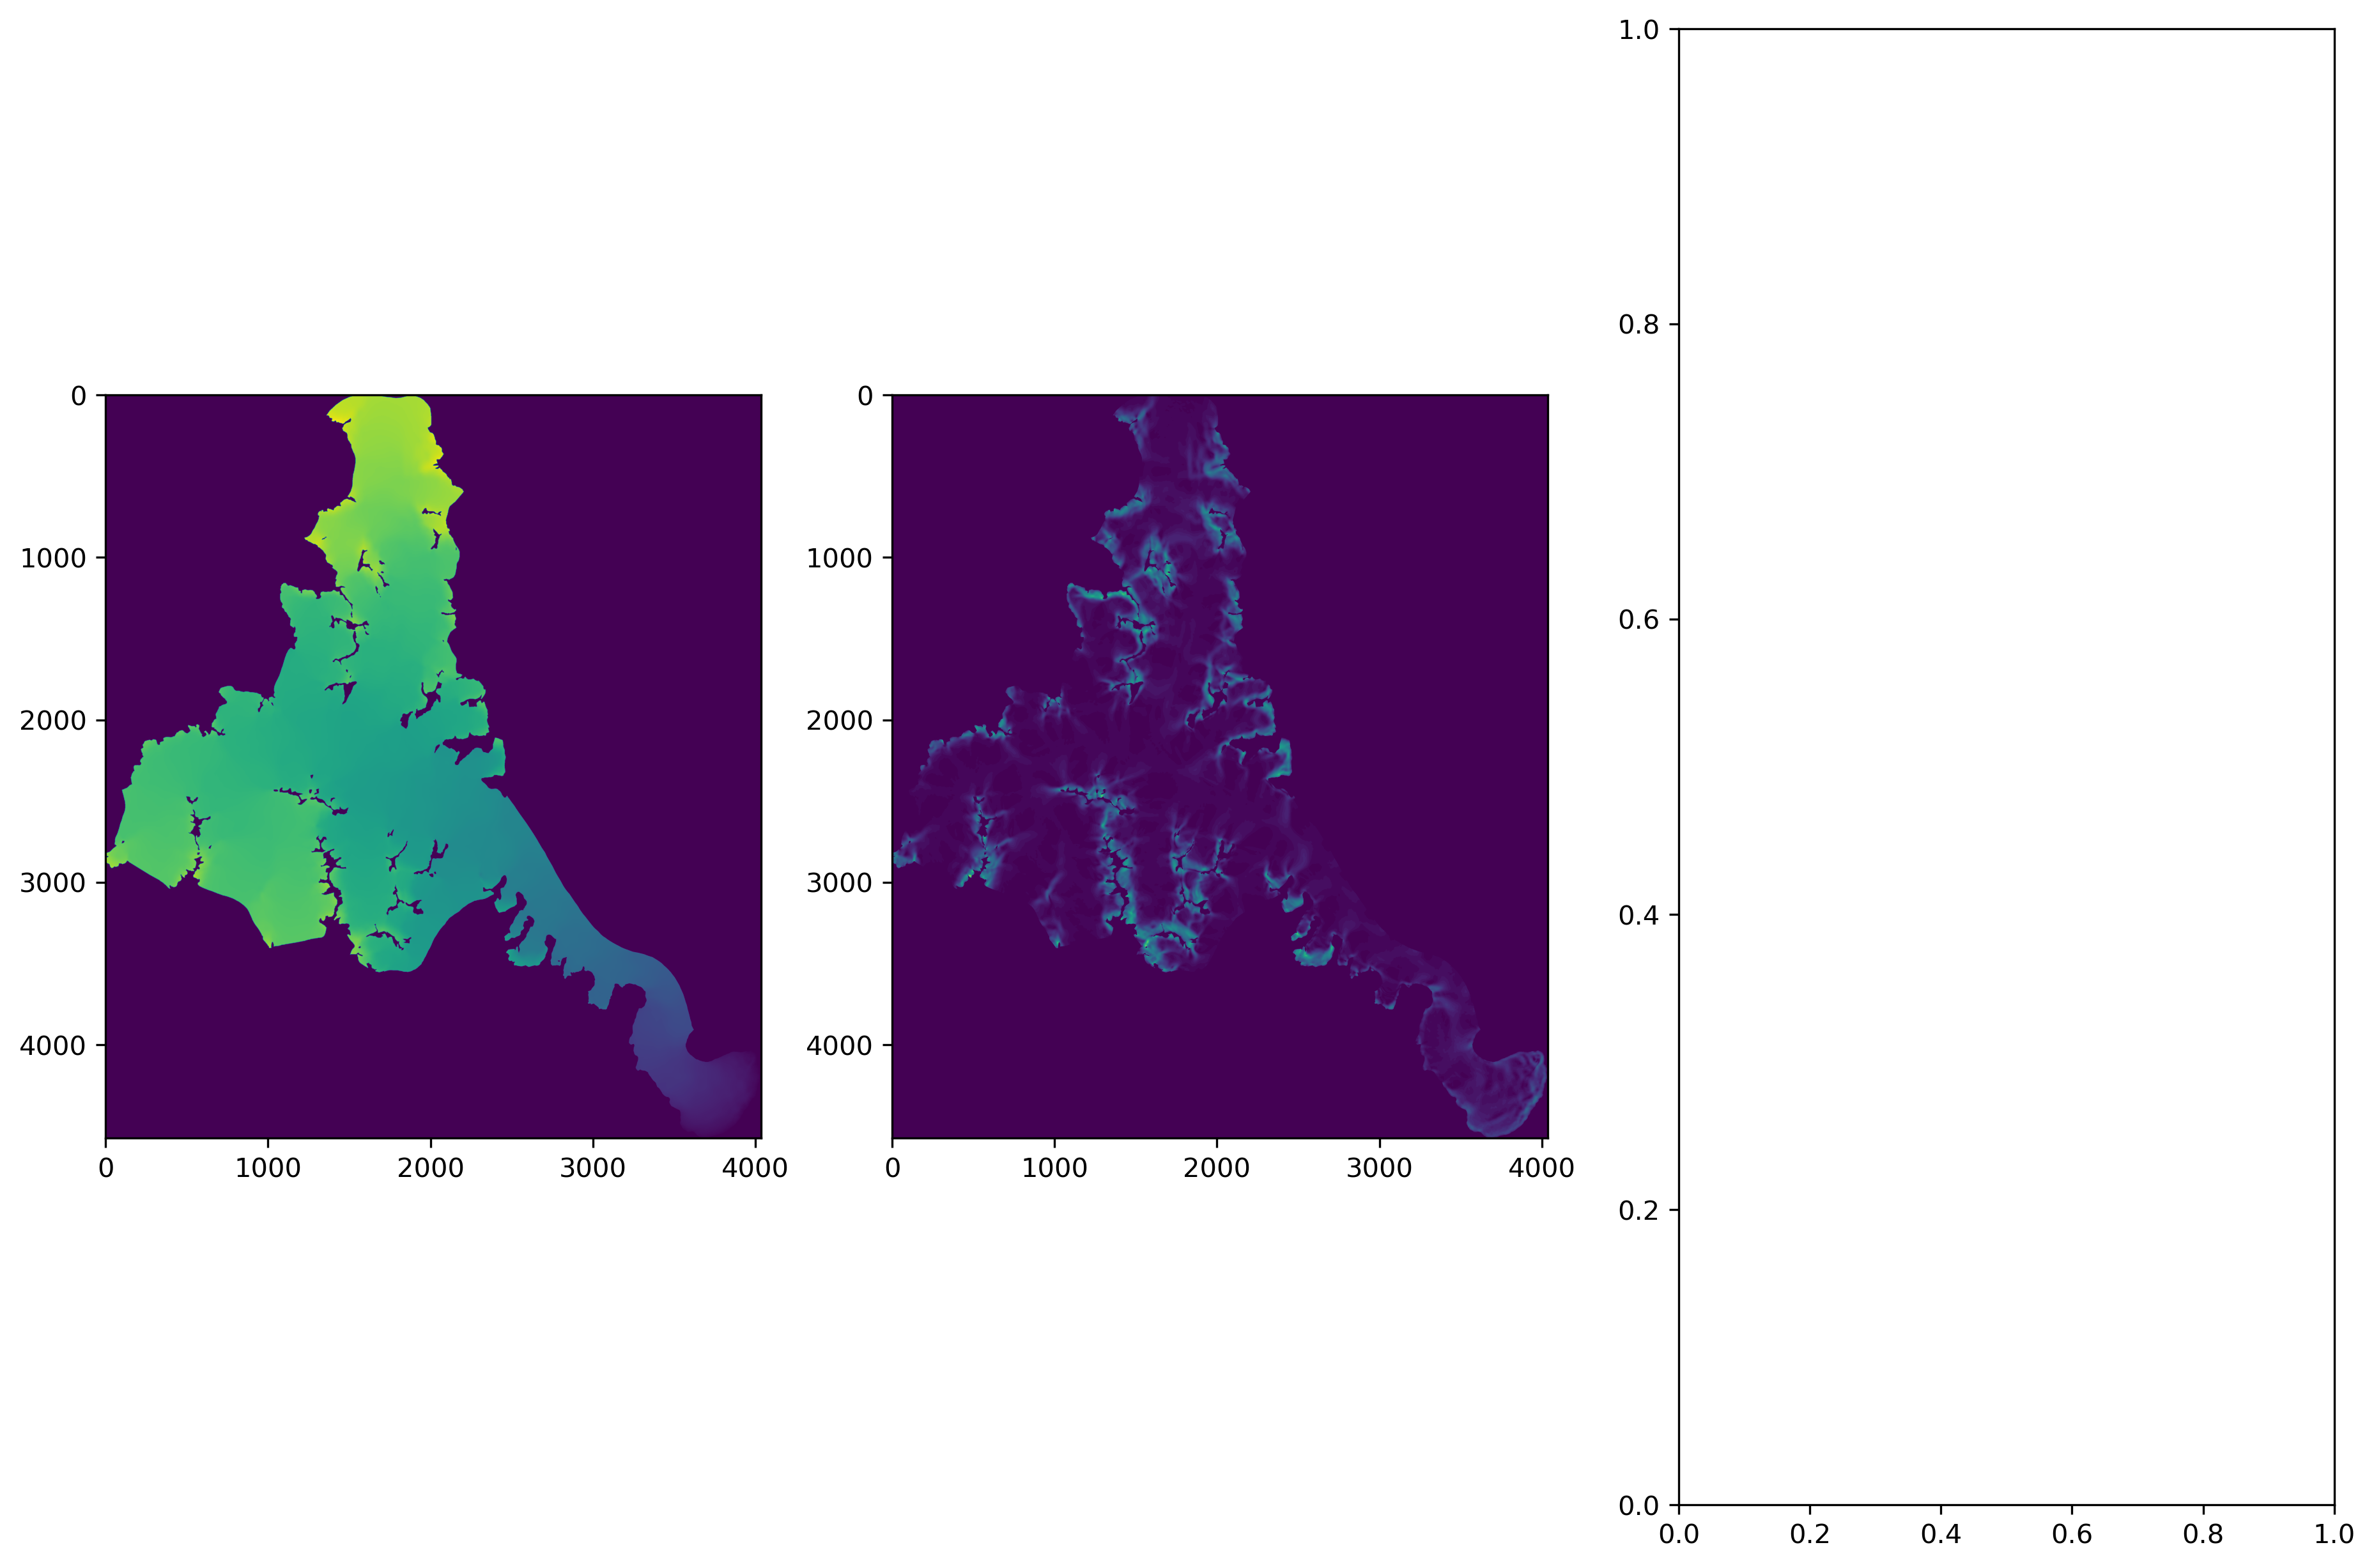

In [14]:
fig,axs = plt.subplots(1,3, figsize=(15,10), dpi=300)
axs[0].imshow(xr_dem.values)
axs[1].imshow(slope)
axs[2].imshow(slope_mask)

for ax in axs:
    ax.axis('off')
    
plt.tight_layout()